In [1]:
from commonfunctions import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from skimage.metrics import structural_similarity as ssim
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def video_to_frames(video_path, output_folder, start_frame=0, end_frame=None):
    """
    Segment a video into frames and save them as images without altering resolution,
    processing frames only within a specified range.

    Args:
        video_path (str): Path to the input video file.
        output_folder (str): Directory where extracted frames will be saved.
        start_frame (int): Frame index to start processing from (default is 0).
        end_frame (int): Frame index to stop processing at (default is None, which means process until the end).
    """
    # Check if the output folder exists, create if not
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    
    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video: {total_frames}")
    
    # Validate the end frame
    if end_frame is None or end_frame > total_frames:
        end_frame = total_frames
    
    # Ensure the start frame is valid
    if start_frame >= total_frames:
        print(f"Error: Start frame {start_frame} exceeds total frames {total_frames}.")
        return
    
    # Ensure the start frame is before the end frame
    if start_frame >= end_frame:
        print(f"Error: Start frame {start_frame} is not less than end frame {end_frame}.")
        return
    
    # Set the starting frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Frame counter
    frame_count = start_frame
    
    while frame_count < end_frame:
        # Read a frame from the video
        ret, frame = cap.read()
        
        # Break the loop if there are no more frames
        if not ret:
            break
        
        # Construct the output file path
        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.png")
        
        # Save the frame as an image (PNG format preserves resolution)
        cv2.imwrite(frame_filename, frame)
        
        # Print progress
        print(f"Saved: {frame_filename}")
        
        # Increment the frame counter
        frame_count += 1
    
    # Release the video capture object
    cap.release()
    print("Video segmentation complete!")

# Example usage
video_path = "input_video.mp4"  # Replace with your video file path
output_folder = "output_frames"  # Replace with desired output folder path
start_frame = 2000  # Start processing after the first 732 frames
end_frame = 3500  # Stop processing after frame 1500

#video_to_frames(video_path, output_folder, start_frame, end_frame)


In [5]:
def adaptiveThreshold(frame):
    # only works on grayscale images represented from 0 to 1 as float, works best with sudden changes such as text
    height, width = np.shape(frame)
    threshold = 15
    window_size = width // 8
    mask = frame.copy()
    integral = frame.copy()
    # calculate the integral of the input image
    for i in range(width):
        sum = 0
        for j in range(height):
            sum += frame[j, i]
            if i == 0:
                integral[j, i] = sum
            else:
                integral[j, i] = integral[j, i - 1] + sum
    i = 0
    j = 0
    for i in range(width):
        for j in range(height):
            x1 = max(0, i - window_size // 2)
            x2 = min (width - 1, i + window_size // 2)
            y1 = max(0, j - window_size // 2)
            y2 = min (height - 1, j + window_size // 2)
            count = (x2 - x1) * (y2 - y1)
            sum = integral[y2, x2]
            if y1 > 0:
                sum -= integral[y1 - 1, x2]
            if x1 > 0:
                sum -= integral[y2, x1 - 1]
            if x1 > 0 and y1 > 0:
                sum += integral[y1 - 1, x1 - 1]
            if (frame[j, i] * count) <= (sum * (100 - threshold) / 100):
                mask[j, i] = 255
            else:
                mask[j, i] = 0
    return mask

img = rgba2rgb(io.imread("./Tests/4.png"))

img_g = rgb2gray(img)

mask =  adaptiveThreshold(img_g)

img_it = iterativeThreshold(img_g)

import numpy as np

f1 = np.array([[0, 0, 1, 0, 0], 
               [0, 0, 1, 0, 0], 
               [0, 0, 1, 0, 0],
               [0, 0, 0, 0, 0], 
               [0, 0, 0, 0, 0]])


img_canny = canny((img_g * 255), sigma=1, low_threshold=240, high_threshold=250)

mask_err = binary_erosion(mask, np.ones((3, 3)))

it_dil = binary_dilation(img_it, np.ones([3,1]))

it_closed = binary_erosion(it_dil, np.ones([3,1]))

mask2 = ((img_g > 0.4) & (img_g < 0.5)) 

mask2_closed = binary_erosion(mask2, np.ones([2,2]))

mask3 = binary_dilation(mask2_closed, np.ones([8,1]))

mask3 = np.logical_or(mask3,img_it)

show_images([img_g,mask,img_it,img_canny,mask_err,it_dil,it_closed,mask2,mask3],["Img","Mask","Iterative","Canny","Mask_err","It_dil","It_closed","mask2","mask3"])

FileNotFoundError: No such file: 'C:\Users\DELL\OneDrive\Desktop\LiscncePlate\Speed-Camera\Tests\4.png'

In [ ]:
img = rgba2rgb(io.imread("./4_2.png"))

img_g = rgb2gray(img)

def seg(img):
    img = (img).astype("uint8")
    imgHist = np.zeros(256)
    for x in range(np.shape(img)[0]):
        for y in range(np.shape(img)[1]):
            imgHist[img[x, y]] += 1

    sum = 0
    for x in range(256):
        sum += (imgHist[x] * x)

    mean = round(sum / (np.shape(img)[0] * np.shape(img)[1]))

    sat = False    
    while(not sat):
        sum1 = 1
        count1 = 1
        sum2 = 1
        count2 = 1
        for x in range(mean):
            sum1 += (imgHist[x] * x)
            count1 += imgHist[x]
        for x in range(mean,256):
            sum2 += (imgHist[x] * x)
            count2 += imgHist[x]
        mean1 = sum1/(count1)
        mean2 = sum2/(count2)
        if math.isnan(mean1):
            print("ERRROR mean1", mean1)
            mean1 = mean2
        if math.isnan(mean2):
            print("ERRROR mean2", mean2)
            mean2 = mean1
        mean3 = round((mean1+mean2)/2)
        if (mean3 == mean):
            sat = True
        mean = mean3

    for x in range(np.shape(img)[0]):
        for y in range(np.shape(img)[1]):
            if(img[x,y] <= mean):
                img[x,y] = 0
            else:
                img[x,y] = 1
    return img

def local_thres(img):
    img = np.copy((img).astype("uint8"))

    x = np.shape(img)[0]
    y = np.shape(img)[1]

    q1 = img[0:round(x/2),0:round(y/2)]
    q2 = img[0:round(x/2),round(y/2):y]
    q3 = img[round(x/2):x,0:round(y/2)]
    q4 = img[round(x/2):x,round(y/2):y]

    q1_s = seg(np.copy(q1))
    q2_s = seg(np.copy(q2))
    q3_s = seg(np.copy(q3))
    q4_s = seg(np.copy(q4))

    return q1_s, q2_s, q3_s, q4_s

def join_quads(quad, sub_quads):
    img = np.zeros(np.shape(quad))
    x = np.shape(img)[0]
    y = np.shape(img)[1]

    img[0:round(x/2),0:round(y/2)] = sub_quads[0]
    img[0:round(x/2),round(y/2):y] = sub_quads[1]
    img[round(x/2):x,0:round(y/2)] = sub_quads[2]
    img[round(x/2):x,round(y/2):y] = sub_quads[3]

    return img

quad = local_thres(img_g * 256)

final = join_quads(img_g,quad)

x = img_g > (0.65 * img.max())

x_err = binary_dilation(x,np.ones([3,1]))

show_images([img_g,final,x,x_err],["original","Final","X","X_err"])


In [3]:
def getHistogram(img):
    # works for grayscale images represented from 0 to 255
    hist = np.zeros(256)
    for i in range(np.shape(img)[0]):
        for j in range(np.shape(img)[1]):
            hist[img[i, j]] += 1
    return hist

def iterativeThreshold(image):
    # only works on grayscale images
    img = (image.copy()*255).astype('uint8') % 255
    hist = getHistogram(img)
    sum = 0
    weighted_sum = 0
    for i in range(256):
        sum += hist[i]
        weighted_sum += hist[i] * i
    Tinit = int(weighted_sum // sum)
    while(True):
        sum1 = 0
        weighted_sum1 = 0
        for j in range(Tinit):
            sum1 += hist[j]
            weighted_sum1 += hist[j] * j
        T1 = int(weighted_sum1 // sum1)

        sum2 = 0
        weighted_sum2 = 0
        for k in range(Tinit,256):
            sum2 += hist[k]
            weighted_sum2 += hist[k] * k
        T2 = int(weighted_sum2 // sum2)

        Told = Tinit
        Tinit = int((T1 + T2) // 2)

        if (Tinit == Told):
            break
    binary_mask = img <= Tinit
    return binary_mask

In [5]:
def refine_binary_half(image):
    binary_image = iterativeThreshold(image)

    show_images([binary_image,image],["image given to refine binary","image"])
    freeze1 = False
    freeze2 = False
    index1 = 0
    index2 = 0
    index3 = 0
    index4 = 0

    print(binary_image[:,0])
    print(binary_image[:,1])
    print(binary_image[:,2])
    # Correctly interpret dimensions
    height, width = np.shape(binary_image)
    
    
    for i in range(2):
        counter1 = 0
        counter2 = 0
        
        # Check the leftmost and rightmost columns at index `i`
        for j in range(5):
            # Top and bottom pixels of the left column
            if binary_image[i, j] == 1:
                counter1 += 1
            if binary_image[height - 1 - i, j] == 1:
                counter1 += 1
            
            # Top and bottom pixels of the right column
            if binary_image[i, width - 1 - j] == 1:
                counter2 += 1
            if binary_image[height - 1 - i, width - 1 - j] == 1:
                counter2 += 1
        
        # Update `index1` for left side
        if counter1 > 3 and not freeze1:
            index3 += 1
        else:
            freeze1 = True

        # Update `index2` for right side
        if counter2 > 3 and not freeze2:
            index4 += 1
        else:
            freeze2 = True
            
            
    freeze1 = False
    freeze2 = False
    strike1=False
    strike2=False
    image=image[index3:height - index4:,:]
    height -= (index3+index4)
    
    for i in range(5):
        counter1 = 0
        counter2 = 0
        
        # Check the leftmost and rightmost columns at index `i`
        for j in range(5):
            # Top and bottom pixels of the left column
            if binary_image[j, i] == 1:
                counter1 += 1
            if binary_image[height - 1 - j, i] == 1:
                counter1 += 1
            
            # Top and bottom pixels of the right column
            if binary_image[j, width - 1 - i] == 1:
                counter2 += 1
            if binary_image[height - 1 - j, width - 1 - i] == 1:
                counter2 += 1
        
        # Update `index1` for left side
        if counter1 > 3 and not freeze1:
            if strike1:       
                index1 += 2
                strike1=False
            else:
                index1 += 1
        elif strike1:
            freeze1 = True
        else:
            strike1=True

        # Update `index2` for right side
        if counter2 > 3 and not freeze2:
            if strike2:       
                index2 += 2
                strike2=False
            else:
                index2 += 1
        elif strike2:
            freeze2 = True
        else:
            strike2=True


    print("After")
    print(binary_image[:,index1])
    # Return the cropped image
    return image[:, index1:width - index2]


In [17]:
def extract_half(img_it_dil,image_n):
    # # Find contours
    contours = find_contours(img_it_dil, 0.)
    bounding_boxes = []
    for contour in contours:
        Ymin = np.min(contour[:,0])
        Ymax = np.max(contour[:,0])
        Xmin = np.min(contour[:,1])
        Xmax = np.max(contour[:,1])
        aspect_ratio = (Xmax-Xmin)/(Ymax-Ymin)
        if 0 <= aspect_ratio <= 5 and (Xmax-Xmin) > 40:
            print(Xmin, Xmax, Ymin, Ymax)
            bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
    
    
    # #When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
    img_with_boxes = np.zeros_like(img_it_dil)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img_it_dil.shape)
        img_with_boxes[rr, cc] = 1 #set color white
        return image_n[int(Ymin+2):int(Ymax-2),int(Xmin):int(Xmax)]
    return image_n[2:int(np.shape(image_n)[0]-4),:]

import numpy as np

def refine_half(image):
    freeze1 = False
    freeze2 = False
    index1 = 0
    index2 = 0
    index3 = 0
    index4 = 0

    print(image[:,0])
    print(image[:,1])
    print(image[:,2])
    # Correctly interpret dimensions
    height, width = np.shape(image)
    
    
    for i in range(4):
        counter1 = 0
        counter2 = 0
        
        # Check the leftmost and rightmost columns at index `i`
        for j in range(5):
            # Top and bottom pixels of the left column
            if image[i, j] < 0.2:
                counter1 += 1
            if image[height - 1 - i, j] < 0.2:
                counter1 += 1
            
            # Top and bottom pixels of the right column
            if image[i, width - 1 - j] < 0.2:
                counter2 += 1
            if image[height - 1 - i, width - 1 - j] < 0.2:
                counter2 += 1
        
        # Update `index1` for left side
        if counter1 > 3 and not freeze1:
            index3 += 1
        else:
            freeze1 = True

        # Update `index2` for right side
        if counter2 > 3 and not freeze2:
            index4 += 1
        else:
            freeze2 = True
            
            
    freeze1 = False
    freeze2 = False
    image=image[index3:height - index4:,:]
    height -= (index3+index4)
    
    for i in range(15):
        counter1 = 0
        counter2 = 0
        
        # Check the leftmost and rightmost columns at index `i`
        for j in range(5):
            # Top and bottom pixels of the left column
            if image[j, i] < 0.2:
                counter1 += 1
            if image[height - 1 - j, i] < 0.2:
                counter1 += 1
            
            # Top and bottom pixels of the right column
            if image[j, width - 1 - i] < 0.2:
                counter2 += 1
            if image[height - 1 - j, width - 1 - i] < 0.3:
                counter2 += 1
        
        # Update `index1` for left side
        if counter1 > 4 and not freeze1:
            index1 += 1
        else:
            freeze1 = True

        # Update `index2` for right side
        if counter2 > 4 and not freeze2:
            index2 += 1
        else:
            freeze2 = True


    print("After")
    print(image[:,index1])
    # Return the cropped image
    return image[:, index1:width - index2]


def split_plate(img):

    img_g = rgb2gray(img)
    
    # Crop 40% from the top
    height, width = img_g.shape
    cropped_img = img_g[int(height * 0.4):, :]
    
    # Split the cropped image into two parts vertically
    image1 = cropped_img[:, :int(width * 0.5)]  # Left half
    image2 = cropped_img[:, int(width * 0.5):]  # Right half

    img_it = iterativeThreshold(image1)
    
    #img_it_dil = binary_dilation(img_it, np.ones([3,1]))
    
    image1 = extract_half2(img_it,image1)
    #show_images([image1],['1'])
    
    #image1 = refine_half(image1)
    #show_images([image1],['11'])
    #image1 = refine_binary_half(image1)
    
    img_it = iterativeThreshold(image2)
    
    #img_it_dil = binary_dilation(img_it, np.ones([3,1]))
    
    image2 = extract_half2(img_it,image2)
    #show_images([image2],['2'])
    
    #image2 = refine_half(image2)
    #show_images([image2],['22'])
    #image2 = refine_binary_half(image2)
    #print("to horizonatal")
    show_images([image1,image2],['1','2'])

    return image1,image2

In [9]:
def horizontal_segmentation(image, min_width=1, max_width=20, min_height=4):
    """
    Segment digits horizontally
    
    Args:
        binary_image (numpy.ndarray): Binary image of the license plate
        min_width (int): Minimum width of a valid digit region
        max_width (int): Maximum width of a valid digit region
        min_height (int): Minimum height of a valid digit region
    
    Returns:
        list: List of segmented digit images
    """
    print("welcome to horizontal seg")
    binary_image = iterativeThreshold(image)

    show_images([image,binary_image],["image","binary"])
    
    # Find horizontal projection
    horizontal_projection = np.sum(binary_image, axis=0)
    
    # Find potential digit regions
    digit_regions = []
    in_digit = False
    start = 0
    
    for x in range(len(horizontal_projection)):
        # Check if we're in a potential digit region
        if not in_digit and horizontal_projection[x] > 0:
            start = x
            in_digit = True
        
        # Check if we've exited a digit region
        elif in_digit and (horizontal_projection[x] == 0 or x == len(horizontal_projection)-1):
            end = x
            print(start,end)

            #filtering
            if (end - start >= min_width and end - start <= max_width and np.sum(binary_image[:,start:end]) > min_height * (end - start)):
        
                # Extract potential digit
                digit_region = image[:, start:end]
                digit_region = iterativeThreshold(digit_region)
                
                digit_regions.append((start, end, digit_region))
            
            in_digit = False
    
    return digit_regions

def refine_segmentation(digit_regions, max_digits=4, min_separation=1):
    """
    Refine segmentation by merging or filtering regions
    
    Args:
        digit_regions (list): List of detected digit regions
        max_digits (int): Maximum number of expected digits
        min_separation (int): Minimum separation between digits
    
    Returns:
        list: Refined list of digit regions
    """
    # Sort regions from left to right
    sorted_regions = sorted(digit_regions, key=lambda x: x[0])
    
    # Merge closely connected regions
    refined_regions = []
    i = 0
    while i < len(sorted_regions):
        current = sorted_regions[i]
        
        # Look ahead to see if next region is close
        if i + 1 < len(sorted_regions):
            next_region = sorted_regions[i + 1]
            
            # If regions are close, merge them
            if next_region[0] - current[1] < min_separation:
                # Merge the two regions
                merged_region = (
                    current[0], 
                    next_region[1], 
                    np.hstack((current[2], next_region[2]))
                )
                refined_regions.append(merged_region)
                i += 2
                continue
        
        refined_regions.append(current)
        i += 1

    # Limit to max expected digits
    return refined_regions[:max_digits]

def pad_and_center_digit(digit, target_size=40, pad_value=0):
    """
    Pad and center a digit image to a target size
    
    Args:
        digit (numpy.ndarray): Input digit image
        target_size (int): Desired size of the padded image
        pad_value (int): Value to use for padding (0 for black)
    
    Returns:
        numpy.ndarray: Padded and centered digit image
    """
    # Ensure the input is a numpy array of uint8
    if not isinstance(digit, np.ndarray):
        digit = np.array(digit)
    
    # Convert to grayscale if it's a color image
    if len(digit.shape) > 2:
        digit = digit.mean(axis=2).astype(np.uint8)
    
    # Get current digit dimensions
    h, w = digit.shape
    
    # Determine scaling factor if larger than target size
    if h > target_size or w > target_size:
        # Calculate scale factor to fit within target size while maintaining aspect ratio
        scale_h = target_size / h
        scale_w = target_size / w
        scale = min(scale_h, scale_w)
        
        # Calculate new dimensions
        new_h = int(h * scale)
        new_w = int(w * scale)
        
        # Resize the digit
        from skimage.transform import resize
        digit = resize(digit, (new_h, new_w), mode='constant', cval=pad_value)
        digit = (digit * 255).astype(np.uint8)
        h, w = digit.shape
    
    # Create a blank image with pad_value
    padded = np.full((target_size, target_size), pad_value, dtype=np.uint8)
    
    # Calculate centering offsets
    start_y = (target_size - h) // 2
    start_x = (target_size - w) // 2
    
    # Place the resized (or original) digit in the center
    padded[start_y:start_y+h, start_x:start_x+w] = digit
    
    return padded

def visualize_segmentation(original, digit_regions, padded_digits):
    """
    Visualize the segmentation process
    
    Args:
        original (numpy.ndarray): Original grayscale image
        binary (numpy.ndarray): Binary image
        digit_regions (list): List of detected digit regions
        padded_digits (list): List of padded digit images
    """
    # Visualization of original and binary images
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 1, 1)
    plt.title('Original Image')
    plt.imshow(original, cmap='gray')
    plt.axis('off')

    '''
    plt.subplot(1, 2, 2)
    plt.title('Binary Image')
    plt.imshow(binary, cmap='gray')
    plt.axis('off')
    '''
    
    plt.tight_layout()
    plt.show()
    
    # Visualize original and padded digits
    plt.figure(figsize=(15, 3))
    
    # Original digits
    plt.subplot(2, len(digit_regions), 1)
    plt.title('Original Digits')
    for i, (start, end, digit) in enumerate(digit_regions, 1):
        plt.subplot(2, len(digit_regions), i)
        plt.imshow(digit, cmap='gray')
        plt.axis('off')
    
    # Padded digits
    plt.subplot(2, len(padded_digits), len(digit_regions) + 1)
    plt.title('Padded Digits')
    for i, digit in enumerate(padded_digits, 1):
        plt.subplot(2, len(padded_digits), len(digit_regions) + i)
        plt.imshow(digit, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def resize(img):
    
    # Step 0: Ensure the image is binary and of the correct type
    img = (img > 0).astype(np.uint8)  # Ensure binary mask of type uint8
    
    # Step 1: Check if the input image has non-zero pixels
    if np.count_nonzero(img) == 0:
        # If empty, return a blank 40x40 binary image
        return np.zeros((40, 40), dtype=np.uint8)

    max_dimension = 30  # Limit the maximum dimension of the image
    scale = max_dimension / max(img.shape[:2])
    if scale < 1:  # Only shrink large images
        img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
    
    # Step 1: Find the bounding box of the digit
    x, y, w, h = cv2.boundingRect(img)

    # Step 2: Crop the digit using the bounding box
    cropped_digit = img[y:y+h, x:x+w]
    
    # Step 3: Compute the scaling factor
    target_size = 32
    scale = min(target_size / w, target_size / h)
    
    # Step 4: Resize the cropped digit while maintaining the aspect ratio
    new_width = int(w * scale)
    new_height = int(h * scale)
    resized_digit = cv2.resize(cropped_digit, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    # Step 5: Create a 40x40 canvas and center the resized digit
    padded_digit = np.zeros((target_size, target_size), dtype=np.uint8)
    
    # Compute padding offsets
    pad_top = (target_size - new_height) // 2
    pad_bottom = target_size - new_height - pad_top
    pad_left = (target_size - new_width) // 2
    pad_right = target_size - new_width - pad_left
    
    # Place the resized digit in the center
    padded_digit[pad_top:pad_top+new_height, pad_left:pad_left+new_width] = resized_digit
    
    return pad_and_center_digit(padded_digit) * 255

#img = rgba2rgb(io.imread("./Tests/5_1.png"))

#img_g = rgb2gray(img)

#img_it = iterativeThreshold(img_g)

def prepare_half(image_n):  
    
    #img_it = iterativeThreshold(image_n)
    
    #img_it = binary_dilation(img_it, np.ones([2,1]))
        
    digit_regions = horizontal_segmentation(image_n,2,20,3)
        
    # Refine segmentation
    refined_regions = refine_segmentation(digit_regions)
    
    # Pad and center digits
    padded_digits = [
        resize(region[2]) 
        for region in refined_regions
    ]
    # Visualize segmentation
    visualize_segmentation(image_n, refined_regions,padded_digits)
    return padded_digits

In [11]:
def compare_images(image1,image2,hith_thresh,hitv_thresh,ratio):

    linesh = 0
    linesv = 0
    linesh_max = 0
    linesv_max = 0
    for i in range(40):
        hitsh = 0
        hitsv = 0
        counth1 = 0
        countv1 = 0
        counth2 = 0
        countv2 = 0
        for j in range(40):
            if (image1[i][j] == image2[i][j] and image1[i][j] == 255):
                hitsh += 1
            if (image1[j][i] == image2[j][i] and image1[j][i] == 255):
                hitsv += 1
            if image1[i][j] == 255:
                counth1 += 1
            if image1[j][i] == 255:
                countv1 += 1
            if image2[i][j] == 255:
                counth2 += 1
            if image2[j][i] == 255:
                countv2 += 1
        if hitsh>(max(counth2,counth1)*hith_thresh):
            linesh += 1
        if hitsv>(max(countv2,countv1)*hitv_thresh):
            linesv += 1
        if counth1 + counth2 > 0:
            linesh_max += 1
        if countv1 + countv2 > 0:
            linesv_max += 1


    return (ratio * linesh/linesh_max) + (linesv/linesv_max)
        

In [13]:
def compare_binary_images(image1, image2, current_half):
    """
    Multiple methods to compare binary images
    
    Args:
        image1 (numpy.ndarray): First binary image
        image2 (numpy.ndarray): Second binary image
    
    Returns:
        dict: Comparison metrics
    """
    # Ensure images are binary and same size
    assert image1.shape == image2.shape, "Images must be the same size"

    #old = np.copy(image1)
    #intersection = np.logical_and(image1, image2)
    #dil = binary_dilation(image1,np.ones([3,3]))
    #image1 = (np.logical_and(dil, image2)*255).astype('uint8')
    #image1 = (np.logical_and(intersection2, image1) * 255).astype('uint8')
    
    #intersection = np.logical_and(intersection3, image2)
    #dil = binary_dilation(intersection,np.ones([4,4]))
    #intersection2 = np.logical_and(dil, image2)
    #image1 = ((np.logical_and(intersection2, image1)) * 255).astype('uint8')
    #new = np.copy(image1)

    image3 = np.copy(image1)
    for i in range(40):
        for j in range(40):
            if image2[i][j] == 255:
                image3[i][j] = 100
    #show_images([image3],['image3'])
    
    # 1. Pixel-wise Accuracy (Accuracy Score)
    pixel_accuracy = np.mean(image1 == image2)
    
    # 2. Euclidean Distance
    euclidean_distance = euclidean(image1.ravel(), image2.ravel())
    
    # 3. Structural Similarity Index (SSIM)
    ssim_score = ssim(image1, image2)
    
    # 4. Normalized Cross-Correlation
    norm_cross_corr = np.corrcoef(image1.ravel(), image2.ravel())[0, 1]
    
    # 5. Hamming Distance
    hamming_distance = np.sum(image1 != image2) / image1.size

    # 6. Countour matching
    # Find contours for both images
    contours1, _ = cv2.findContours(image1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours2, _ = cv2.findContours(image2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Compare shapes using cv2.matchShapes (Hu Moments)
    similarity = cv2.matchShapes(contours1[0], contours2[0], cv2.CONTOURS_MATCH_I1, 0.0)

    # 7. IoU
    intersection = np.logical_and(image1, image2).sum()
    union = np.logical_or(image1, image2).sum()
    iou = intersection / union

    # 8. Template matching
    result = cv2.matchTemplate(image1, image2, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # 9. Fourier difference
    fft1 = np.fft.fft2(image1)
    fft2 = np.fft.fft2(image2)
    similarity_fourier = np.sum(np.abs(fft1 - fft2)) / np.sum(np.abs(fft1 + fft2))

    # 10. Dice
    dice = 2 * intersection / (image1.sum() + image2.sum())
    
    #11. HU
    # Compute Hu Moments
    moments1 = cv2.moments(image1)
    moments2 = cv2.moments(image2)
    
    hu1 = cv2.HuMoments(moments1).flatten()
    hu2 = cv2.HuMoments(moments2).flatten()
    
    # Compare using log-scale difference
    hu = np.sum(np.abs(np.log(np.abs(hu1) + 1e-10) - np.log(np.abs(hu2) + 1e-10)))

    #12. Custom
    if current_half == 1:
        custom = compare_images(image1,image2,0.65,0.45,1)
    else:
        custom = compare_images(image1,image2,0.65,0.45,1)
        #0.65,0.65,2
    
    
    return {
        'pixel_accuracy': pixel_accuracy,
        'euclidean_distance': euclidean_distance,
        'ssim_score': ssim_score,
        'normalized_cross_correlation': norm_cross_corr,
        'hamming_distance': hamming_distance,
        'countour_matching' : similarity,
        'IoU' : iou,
        'template_matching' : max_val,
        'fourier_difference' : similarity_fourier,
        'dice' : dice,
        'hu' : hu,
        'custom' : custom
    }

def recommend_best_match(reference_images, test_image, current_half):
    """
    Compare test image against multiple reference images
    
    Args:
        reference_images (dict): Dictionary of reference images
        test_image (numpy.ndarray): Image to match
    
    Returns:
        str: Best matching digit
    """
    # Store comparison results
    comparison_results = {}
    
    for digit, ref_image in reference_images.items():
        # Perform comparison
        metrics = compare_binary_images(test_image, ref_image, current_half)
        
        # Use a weighted score (you can adjust weights)
        weighted_score = (
            0 * metrics['pixel_accuracy'] + 
            0 * (1 - metrics['euclidean_distance']) + 
            0 * metrics['ssim_score'] +
            0 * metrics['normalized_cross_correlation'] +
            0 * (1 - metrics['hamming_distance']) + 
            -0 * metrics['countour_matching'] + 
            0 * metrics['IoU'] + 
            0 * metrics['template_matching'] + 
            -0 * metrics['fourier_difference'] + 
            0 * metrics['dice'] + 
            -0 * metrics['hu'] +
            1 * metrics['custom']
        )
        
        comparison_results[digit] = weighted_score
    
    # Find the best match
    best_match = max(comparison_results, key=comparison_results.get)
    
    return best_match, comparison_results

def visualize_comparison(images, titles):
    """
    Visualize a set of binary images
    
    Args:
        images (list): List of binary images
        titles (list): List of titles for each image
    """
    plt.figure(figsize=(12, 4))
    
    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.title(title)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example of preparing reference images
def prepare_reference_images():
    """
    Helper function to prepare reference binary images
    
    Returns:
        dict: Dictionary of reference digit and letter images
    """
    reference_digits = {}
    reference_letters = {}
    
    # Load and preprocess reference images for each digit
    for digit in '١٢٣٤٥٦٧٨٩':
        # Load image
        img = (io.imread(f'./Reference_Numbers/{digit}.jpg'))
        img_g = rgb2gray(img)
        img_it = iterativeThreshold(img_g)
        reference_digits[digit] = resize(img_it)
        pass

    # Load and preprocess reference images for each letter
    for letter in 'أبجدرسصطعفقكلمنهوي':
        # Load image
        img = (io.imread(f'./Reference_Letters/{letter}.jpg'))
        img_g = rgb2gray(img)
        img_it = iterativeThreshold(img_g)
        reference_letters[letter] = resize(img_it)
        pass
    
    return reference_digits,reference_letters

def test_half(current_half,padded_digits):

    # Simulate reference images (replace with your actual reference images)
    reference_digits,reference_letters = prepare_reference_images()
    
    # Your test image

    answer = []
    
    for i  in range(len(padded_digits)):
        test_image = padded_digits[i]
        if current_half == 1:
            #show_images([test_image,reference_digits['١'],reference_digits['٢'],reference_digits['٣'],reference_digits['٤'],reference_digits['٥'],reference_digits['٦'],reference_digits['٧'],reference_digits['٨'],reference_digits['٩']],["Test_iamge","1","2","3","4","5","6","7","8","9"])
        
            # Find best match
            best_digit, results = recommend_best_match(reference_digits, test_image, current_half)
    
        else:
            #show_images([test_image,reference_letters['أ'],reference_letters['ب'],reference_letters['ج'],reference_letters['د'],reference_letters['ر'],reference_letters['س'],reference_letters['ص'],reference_letters['ط'],reference_letters['ع']],["Test_image","أ","ب","ج","د","ر","س","ص","ط","ع"])
            #show_images([reference_letters['ف'],reference_letters['ق'],reference_letters['ك'],reference_letters['ل'],reference_letters['م'],reference_letters['ن'],reference_letters['ه'],reference_letters['و'],reference_letters['ي']],["ف","ق","ك","ل","م","ن","ه","و","ي"])
            # Find best match
            best_digit, results = recommend_best_match(reference_letters, test_image, current_half)
            
        print(f"Best match: {best_digit}")
        print("Full comparison results:", results)
        
        sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    
        # Get the first two values
        first_two_values = [value for _, value in sorted_results[:2]]
    
        # Calculate and print the confidence difference
        if current_half == 1:
            print("Confidence : ", (first_two_values[0] - first_two_values[1]) / 2)
        else:
            print("Confidence : ", (first_two_values[0] - first_two_values[1]) / 2)

        answer.append(best_digit)

    return answer

# Visualize comparison
#visualize_comparison(test_image, reference_images['0'])

# Compare images
#comparison = compare_binary_images(test_image, reference_images['0'])

# Print comparison metrics
#for metric, value in comparison.items():
   # print(f"{metric}: {value}")




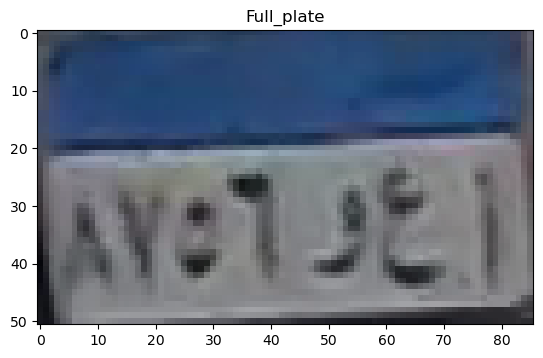

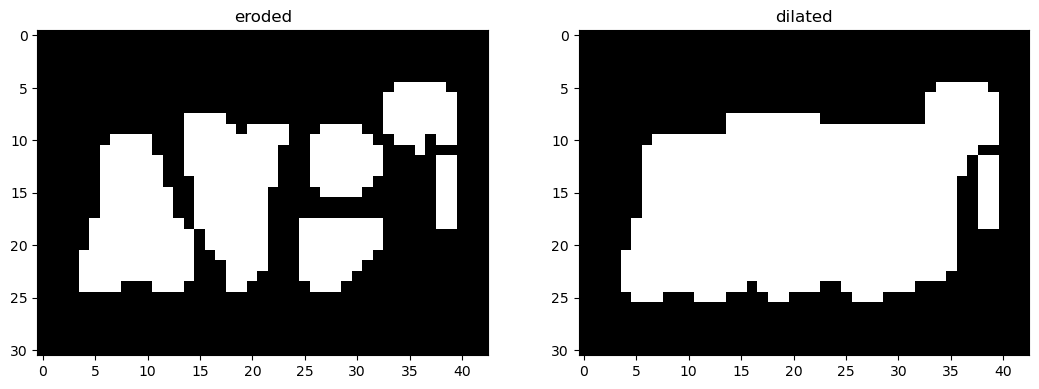

4.0 39.0 5.0 25.0


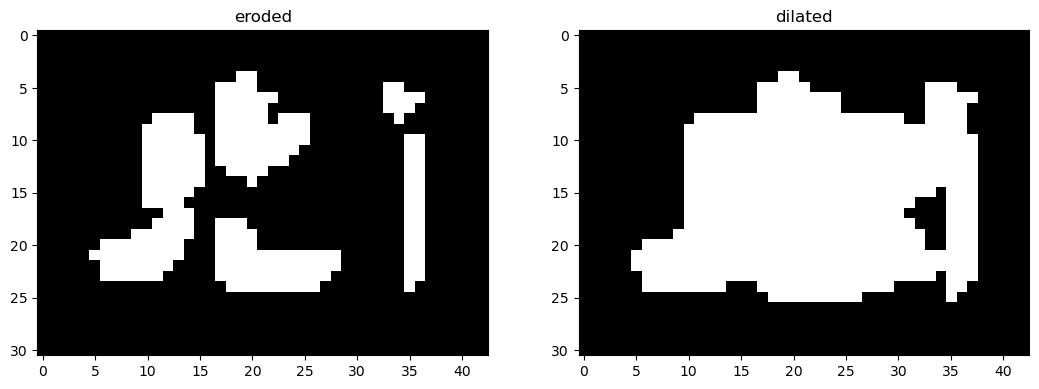

5.0 37.0 4.0 25.0


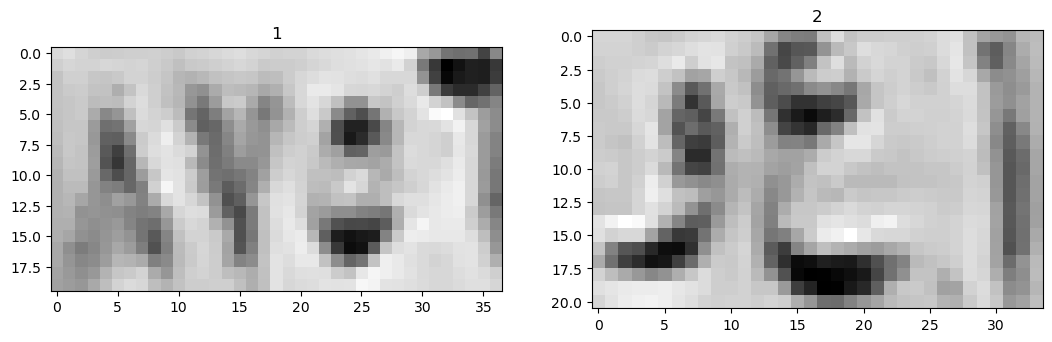

welcome to horizontal seg


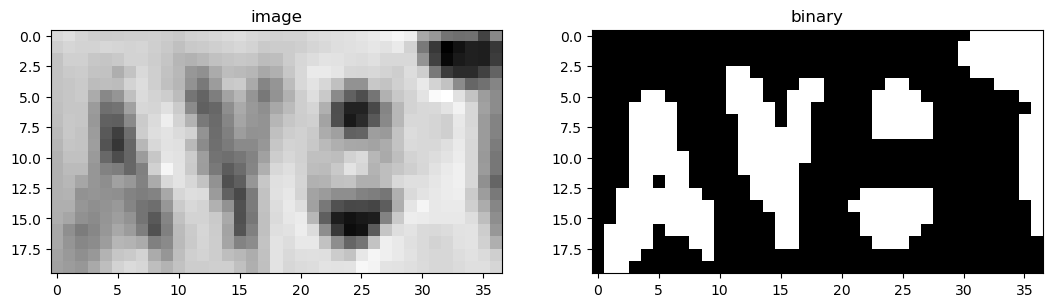

1 10
11 19
21 28
30 36


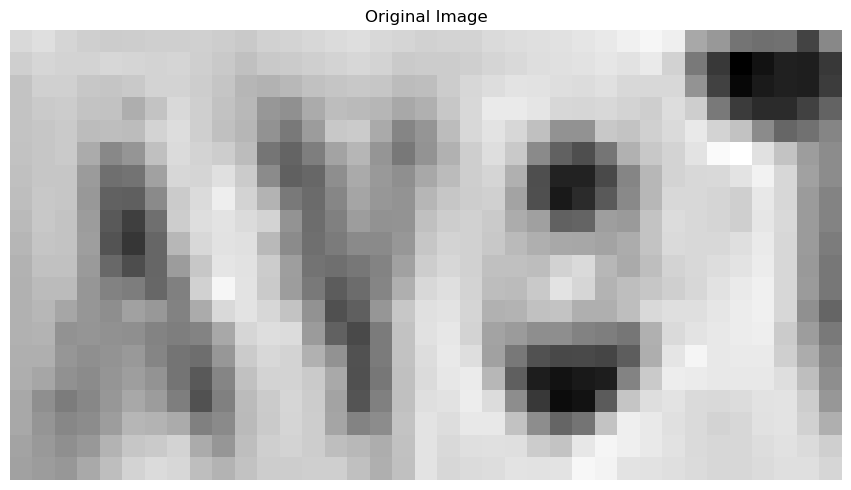

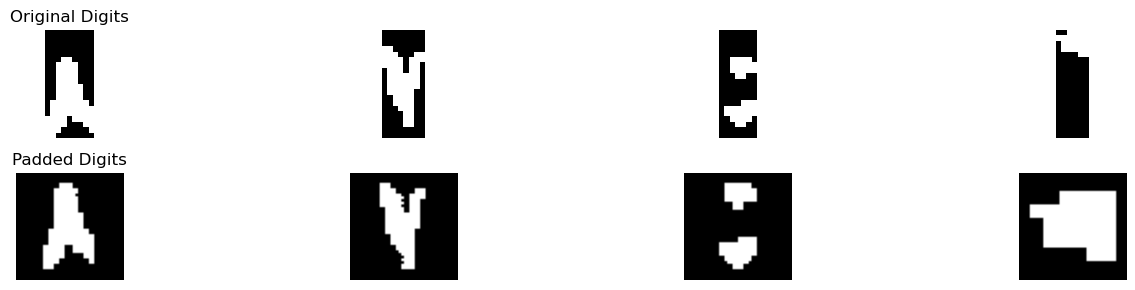

Best match: ٨
Full comparison results: {'١': 0.21052631578947367, '٢': 0.3881578947368421, '٣': 0.22039473684210525, '٤': 0.2944078947368421, '٥': 0.4895833333333333, '٦': 0.24177631578947367, '٧': 0.05263157894736842, '٨': 0.6726973684210527, '٩': 0.4720394736842105}
Confidence :  0.09155701754385967
Best match: ٧
Full comparison results: {'١': 0.11764705882352941, '٢': 0.35294117647058826, '٣': 0.5367647058823529, '٤': 0.35294117647058826, '٥': 0.3005952380952381, '٦': 0.44669117647058826, '٧': 0.6544117647058824, '٨': 0.1111111111111111, '٩': 0.3290441176470588}
Confidence :  0.05882352941176472
Best match: ٥
Full comparison results: {'١': 0.23660714285714285, '٢': 0.3392857142857143, '٣': 0.21507352941176472, '٤': 0.5, '٥': 0.8526785714285714, '٦': 0.6071428571428572, '٧': 0.17647058823529413, '٨': 0.3715277777777778, '٩': 0.0625}
Confidence :  0.1227678571428571
Best match: ٥
Full comparison results: {'١': 0.125, '٢': 0.125, '٣': 0.09375, '٤': 0.15625, '٥': 0.375, '٦': 0.15625, '٧

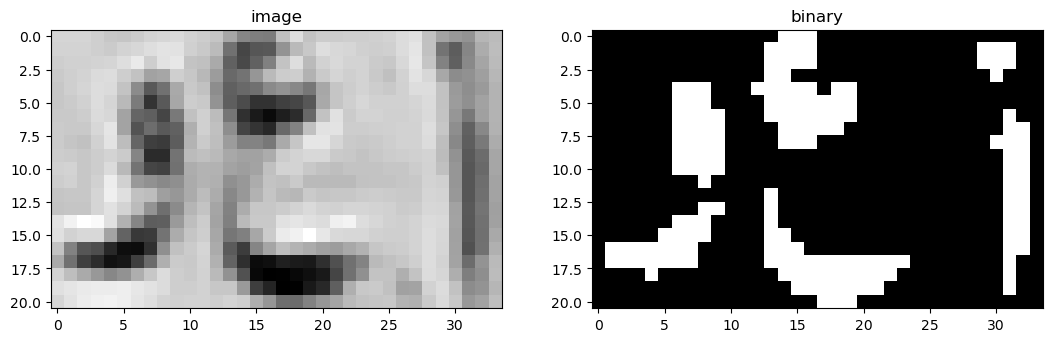

1 10
12 24
29 33


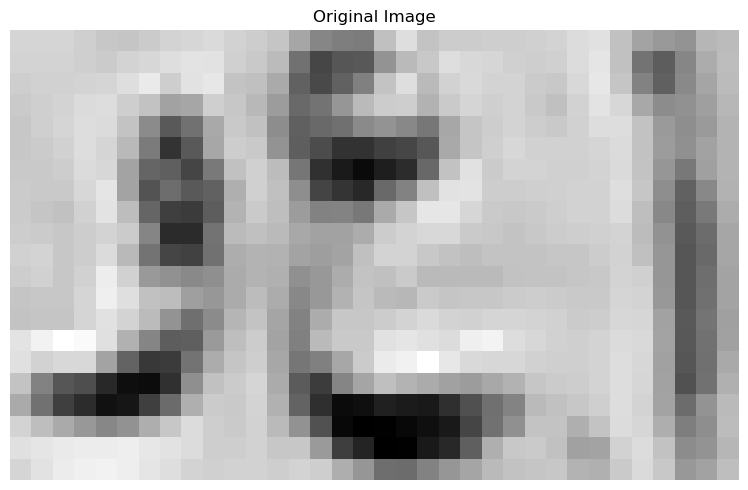

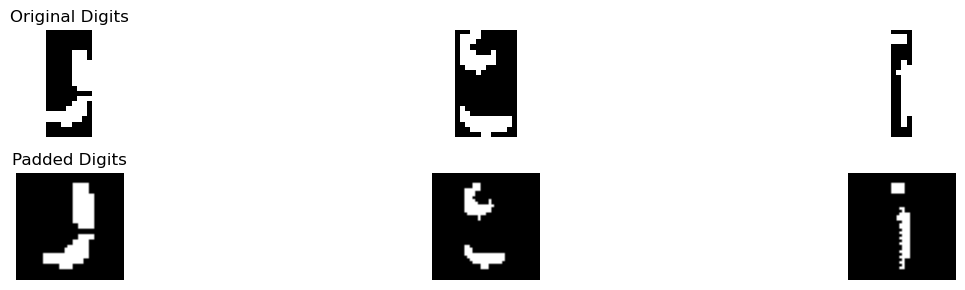

Best match: و
Full comparison results: {'أ': 0.0, 'ب': 0.03125, 'ج': 0.15625, 'د': 0.8380681818181818, 'ر': 0.5668103448275862, 'س': 0.5625, 'ص': 0.1875, 'ط': 0.4583333333333333, 'ع': 0.25164473684210525, 'ف': 0.46412037037037035, 'ق': 0.4407894736842105, 'ك': 0.3854166666666667, 'ل': 0.6513157894736842, 'م': 0.08388157894736842, 'ن': 0.675, 'ه': 0.59375, 'و': 1.1666666666666665, 'ي': 0.6634615384615384}
Confidence :  0.16429924242424238
Best match: ع
Full comparison results: {'أ': 0.0, 'ب': 0.03125, 'ج': 0.39809782608695654, 'د': 0.3068181818181818, 'ر': 0.2693965517241379, 'س': 0.125, 'ص': 0.03125, 'ط': 0.15625, 'ع': 1.0797962648556876, 'ف': 0.14814814814814814, 'ق': 0.25164473684210525, 'ك': 0.3229166666666667, 'ل': 0.46875, 'م': 0.1875, 'ن': 0.525, 'ه': 0.0, 'و': 0.26041666666666663, 'ي': 0.2091346153846154}
Confidence :  0.2773981324278438
Best match: أ
Full comparison results: {'أ': 0.9714285714285714, 'ب': 0.03125, 'ج': 0.16168478260869565, 'د': 0.0625, 'ر': 0.0, 'س': 0.03125, '

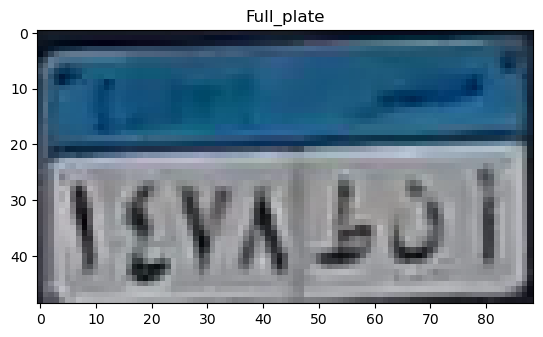

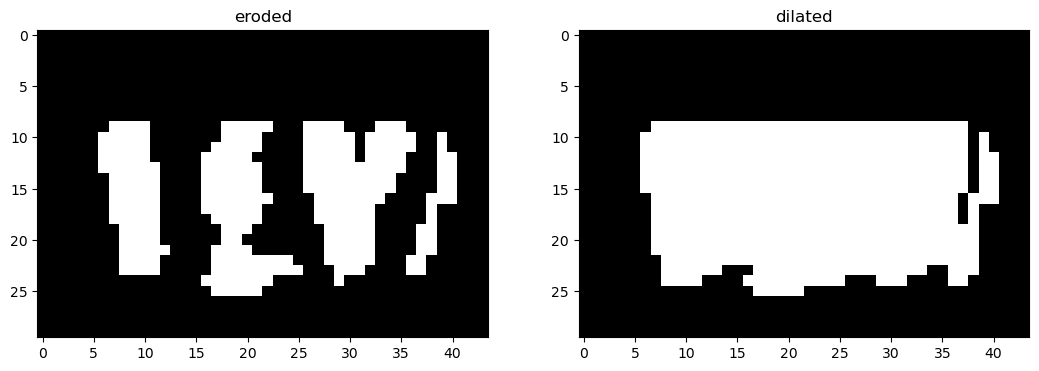

6.0 38.0 9.0 25.0


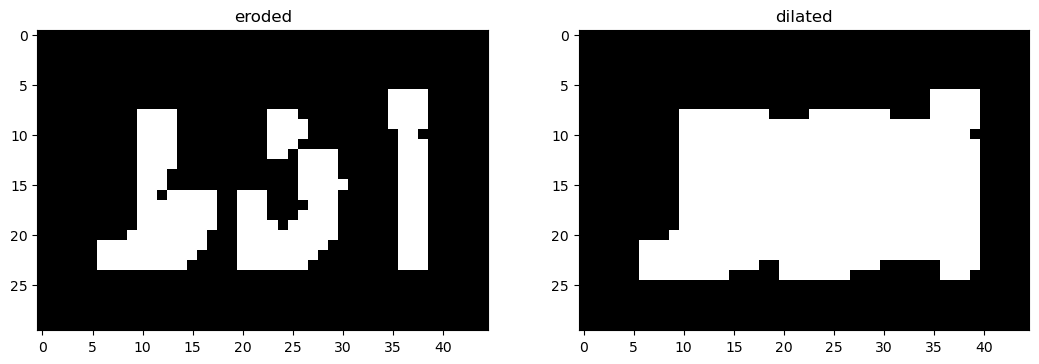

6.0 39.0 6.0 24.0


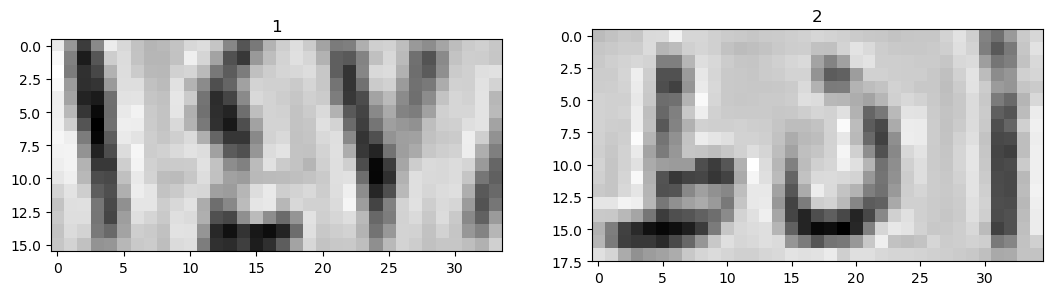

welcome to horizontal seg


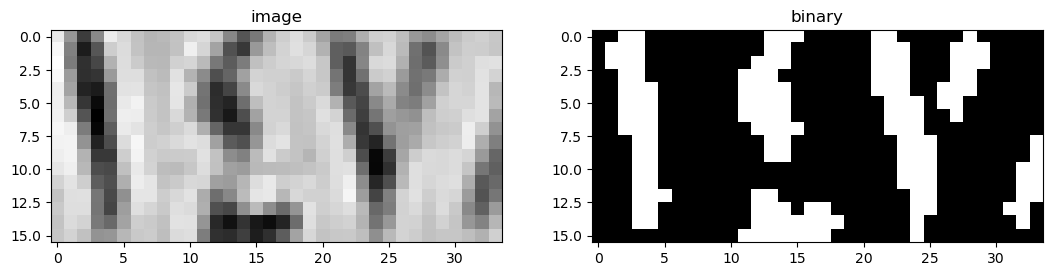

1 6
11 19
21 30
31 33


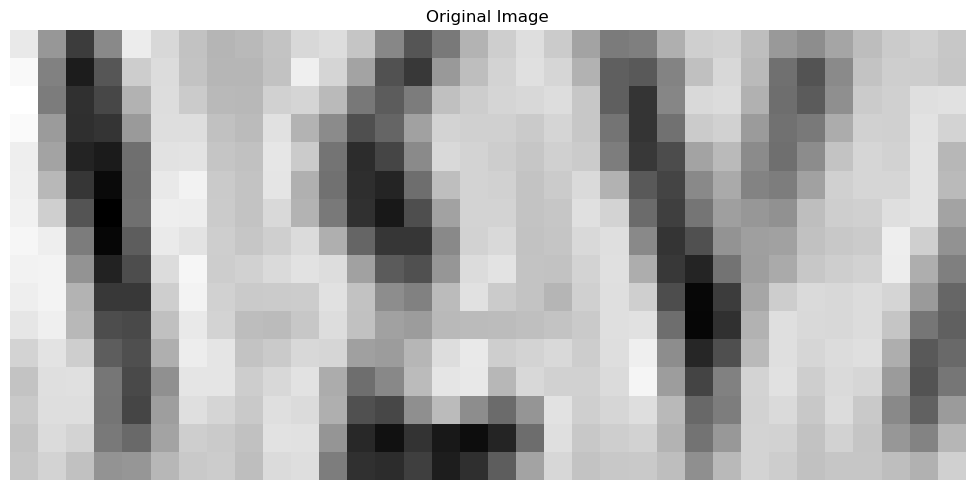

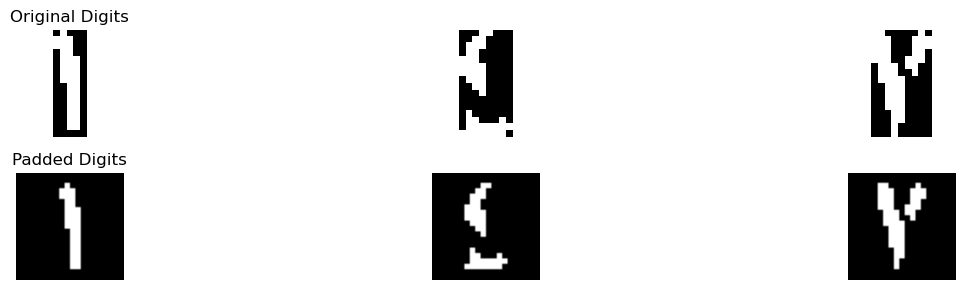

Best match: ١
Full comparison results: {'١': 0.9375, '٢': 0.22916666666666666, '٣': 0.0, '٤': 0.4375, '٥': 0.2857142857142857, '٦': 0.5446428571428572, '٧': 0.5238970588235294, '٨': 0.5590277777777778, '٩': 0.23897058823529413}
Confidence :  0.1892361111111111
Best match: ٢
Full comparison results: {'١': 0.0625, '٢': 0.5625, '٣': 0.23897058823529413, '٤': 0.53125, '٥': 0.5208333333333333, '٦': 0.0, '٧': 0.0625, '٨': 0.0, '٩': 0.3602941176470588}
Confidence :  0.015625
Best match: ٧
Full comparison results: {'١': 0.0, '٢': 0.4270833333333333, '٣': 0.5, '٤': 0.16666666666666666, '٥': 0.12648809523809523, '٦': 0.1111111111111111, '٧': 0.65625, '٨': 0.0, '٩': 0.19791666666666666}
Confidence :  0.078125
welcome to horizontal seg


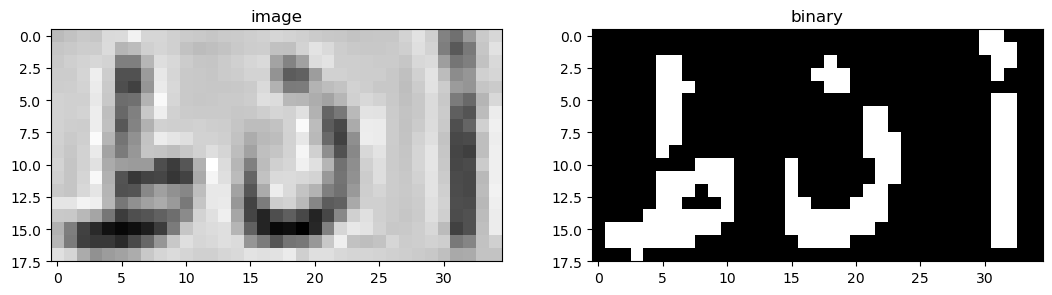

1 11
15 24
30 33


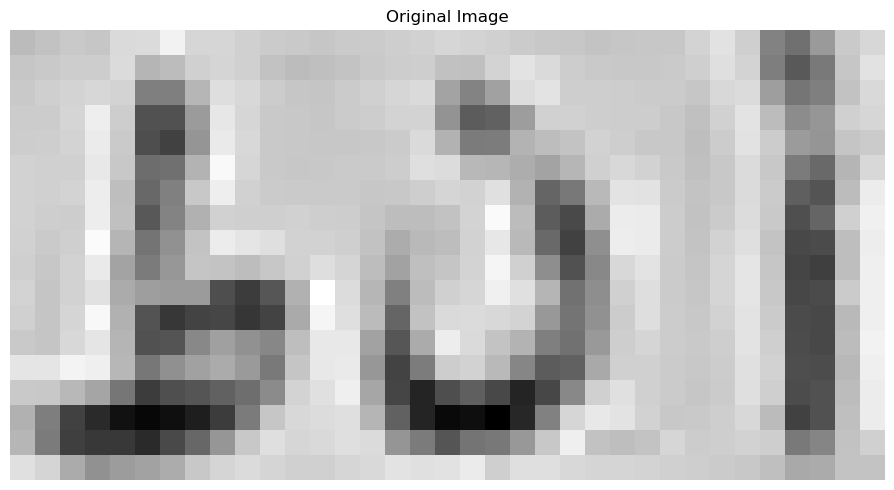

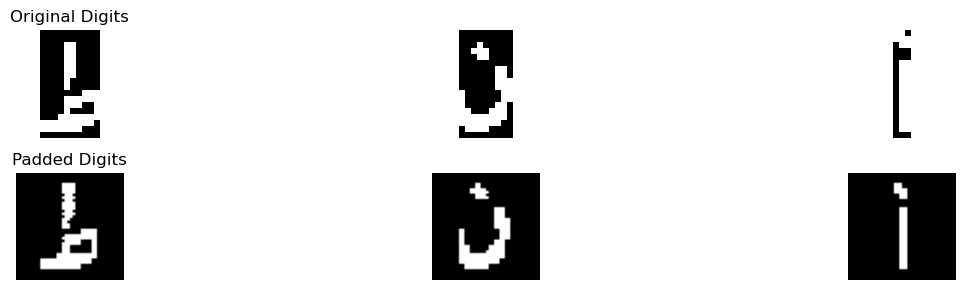

Best match: ط
Full comparison results: {'أ': 0.20535714285714285, 'ب': 0.0625, 'ج': 0.4171195652173913, 'د': 0.7642045454545454, 'ر': 0.4698275862068966, 'س': 0.0625, 'ص': 0.0, 'ط': 1.3229166666666665, 'ع': 0.22023809523809523, 'ف': 0.7372685185185185, 'ق': 0.31547619047619047, 'ك': 0.6145833333333333, 'ل': 0.17410714285714285, 'م': 0.11011904761904762, 'ن': 0.7261904761904762, 'ه': 0.0625, 'و': 0.4270833333333333, 'ي': 0.43990384615384615}
Confidence :  0.27935606060606055
Best match: ق
Full comparison results: {'أ': 0.05263157894736842, 'ب': 0.09375, 'ج': 0.5163043478260869, 'د': 0.9034090909090909, 'ر': 0.3351293103448276, 'س': 0.28125, 'ص': 0.09375, 'ط': 0.4895833333333333, 'ع': 0.6085526315789473, 'ف': 0.6747685185185185, 'ق': 1.1280701754385964, 'ك': 0.4166666666666667, 'ل': 0.6825657894736842, 'م': 0.05263157894736842, 'ن': 0.7435483870967743, 'ه': 0.25, 'و': 0.5, 'ي': 0.6802884615384616}
Confidence :  0.11233054226475275
Best match: أ
Full comparison results: {'أ': 1.4666666666

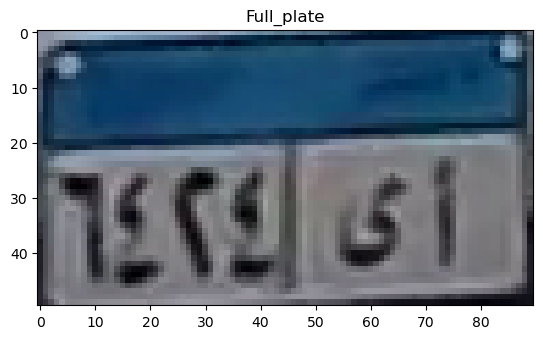

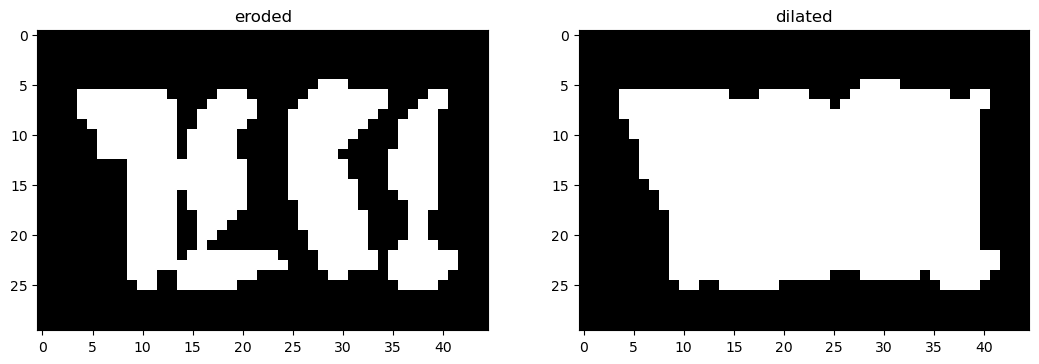

4.0 41.0 5.0 25.0


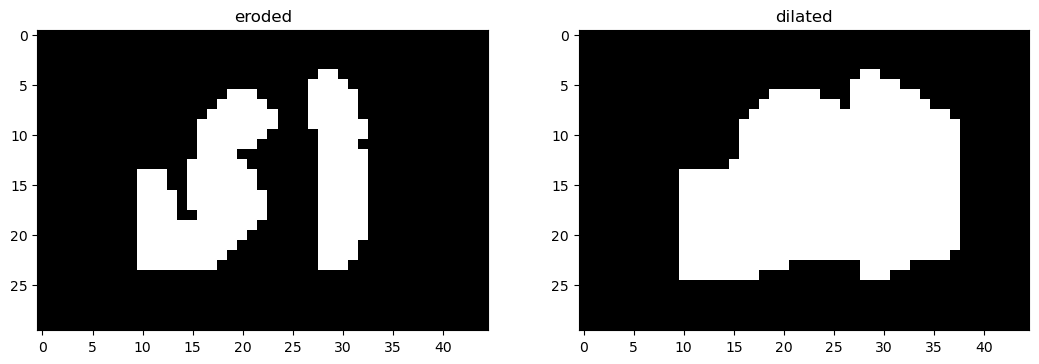

10.0 37.0 4.0 24.0


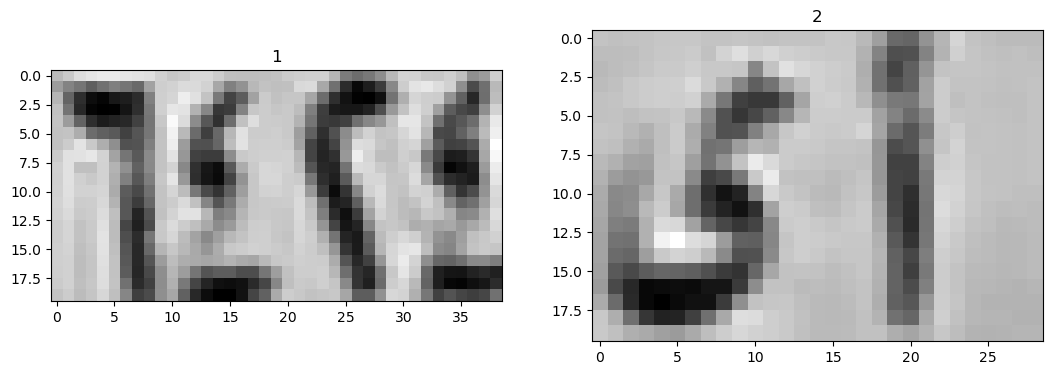

welcome to horizontal seg


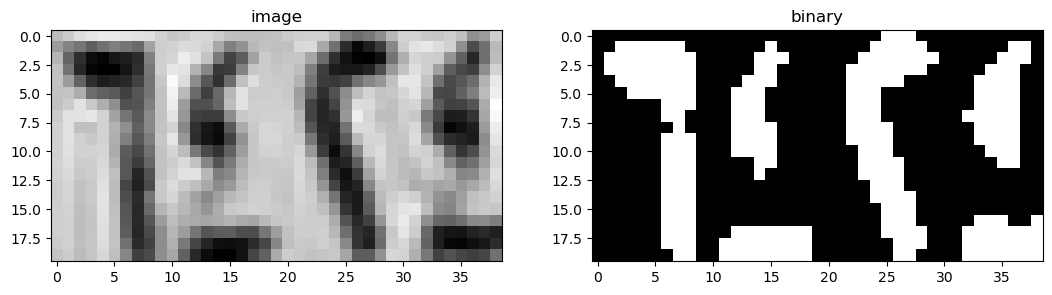

1 9
11 19
22 30
32 38


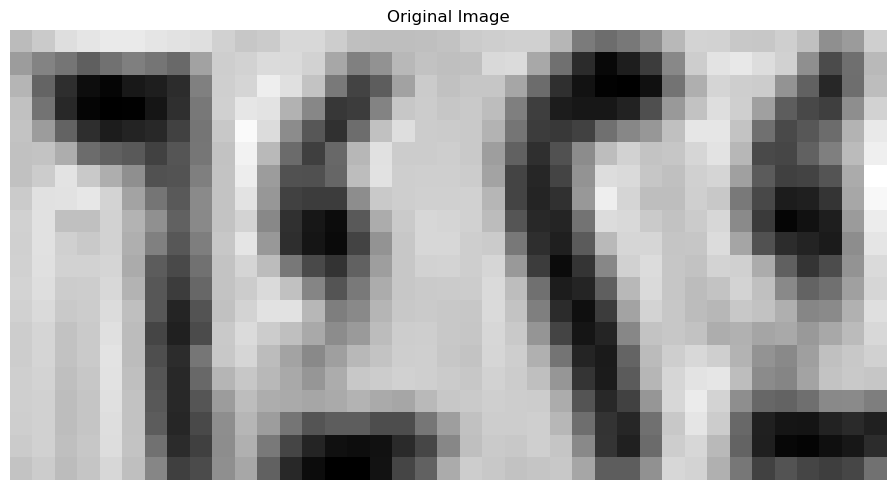

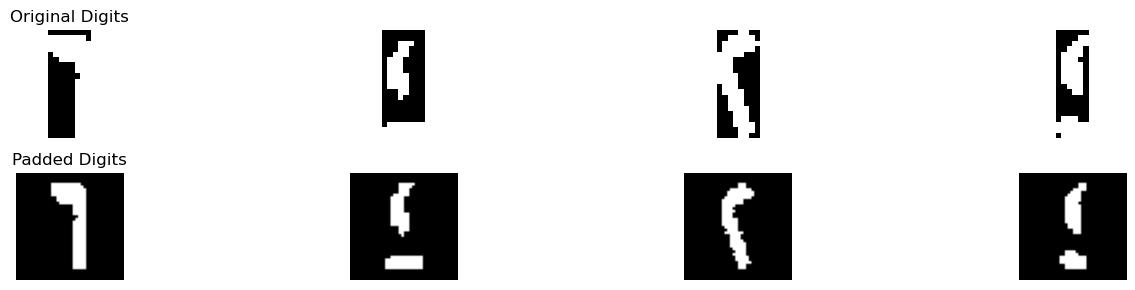

Best match: ٦
Full comparison results: {'١': 0.23076923076923078, '٢': 0.20192307692307693, '٣': 0.4540441176470588, '٤': 0.0625, '٥': 0.4255952380952381, '٦': 1.6473214285714286, '٧': 0.11764705882352941, '٨': 0.3472222222222222, '٩': 0.2665441176470588}
Confidence :  0.5966386554621849
Best match: ٤
Full comparison results: {'١': 0.3169642857142857, '٢': 0.42857142857142855, '٣': 0.17647058823529413, '٤': 1.125, '٥': 0.5208333333333333, '٦': 0.07142857142857142, '٧': 0.058823529411764705, '٨': 0.29166666666666663, '٩': 0.1488970588235294}
Confidence :  0.30208333333333337
Best match: ٢
Full comparison results: {'١': 0.08333333333333333, '٢': 1.5104166666666665, '٣': 0.5716911764705883, '٤': 0.53125, '٥': 0.3630952380952381, '٦': 0.26785714285714285, '٧': 0.6029411764705883, '٨': 0.0, '٩': 0.058823529411764705}
Confidence :  0.4537377450980391
Best match: ٤
Full comparison results: {'١': 0.7125, '٢': 0.0, '٣': 0.058823529411764705, '٤': 0.96875, '٥': 0.2857142857142857, '٦': 0.1428571

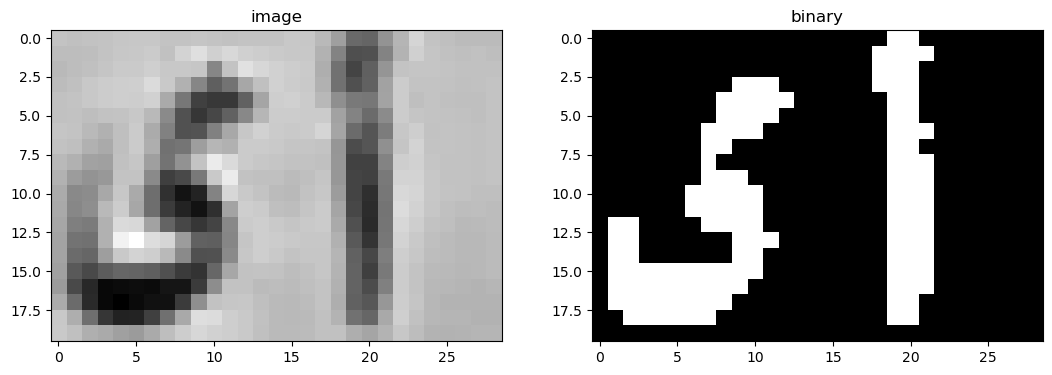

1 13
18 22


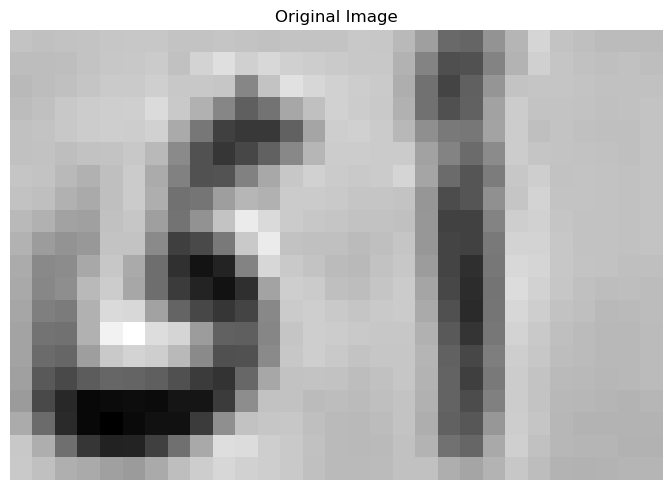

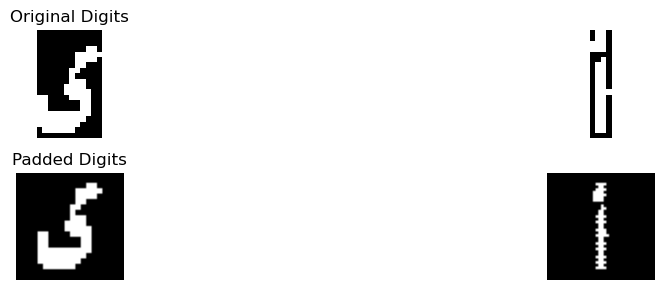

Best match: ي
Full comparison results: {'أ': 0.041666666666666664, 'ب': 0.09375, 'ج': 0.59375, 'د': 0.6770833333333333, 'ر': 0.4665948275862069, 'س': 0.53125, 'ص': 0.375, 'ط': 0.4375, 'ع': 0.23958333333333331, 'ف': 0.49537037037037035, 'ق': 0.59375, 'ك': 0.5625, 'ل': 0.4166666666666667, 'م': 0.03125, 'ن': 0.4895833333333333, 'ه': 0.28125, 'و': 0.8020833333333334, 'ي': 1.0673076923076923}
Confidence :  0.13261217948717946
Best match: أ
Full comparison results: {'أ': 1.118279569892473, 'ب': 0.0625, 'ج': 0.20516304347826086, 'د': 0.07670454545454546, 'ر': 0.0, 'س': 0.0, 'ص': 0.0625, 'ط': 0.21875, 'ع': 0.0, 'ف': 0.13657407407407407, 'ق': 0.05263157894736842, 'ك': 0.0, 'ل': 0.0, 'م': 0.03125, 'ن': 0.175, 'ه': 0.03125, 'و': 0.03125, 'ي': 0.0}
Confidence :  0.4497647849462365
[['٦', '٤', '٢', '٤'], ['ي', 'أ']]


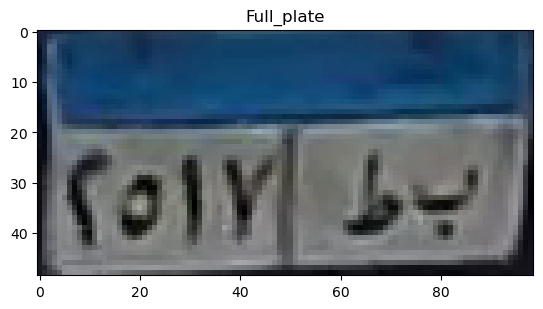

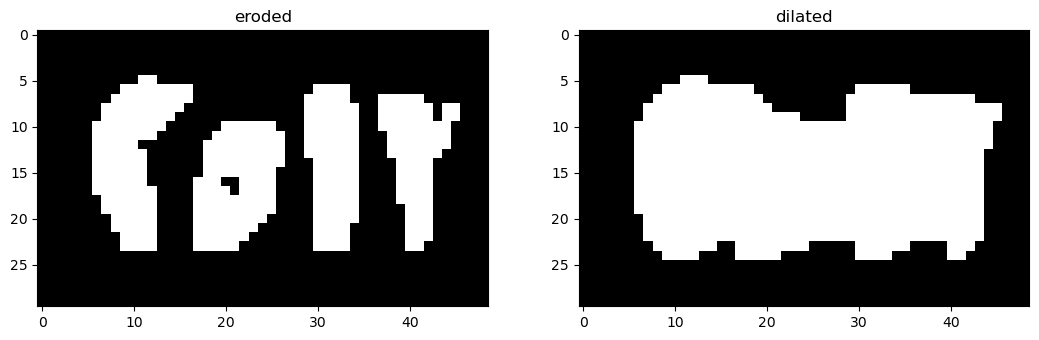

6.0 45.0 5.0 24.0


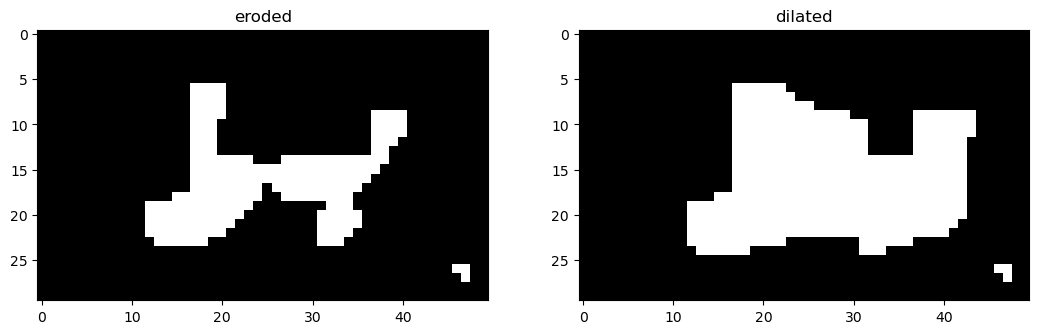

12.0 43.0 6.0 24.0


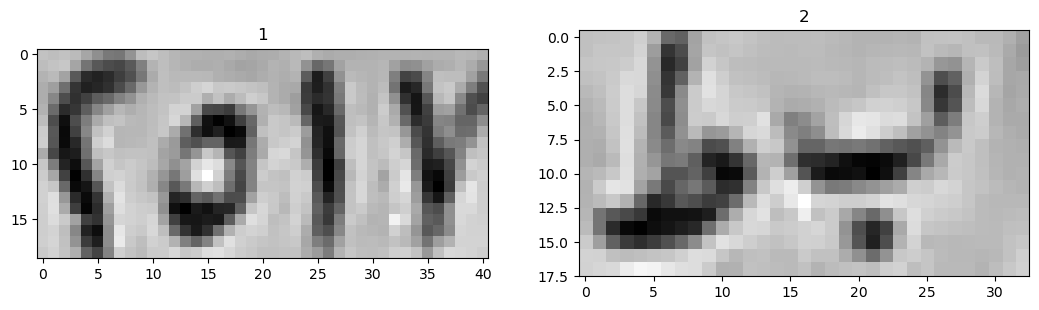

welcome to horizontal seg


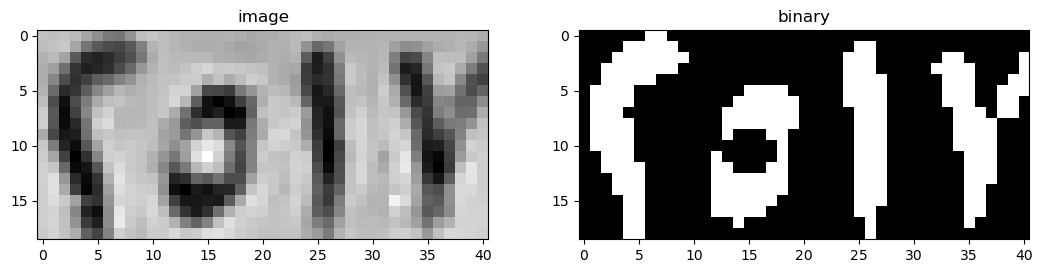

1 10
12 20
24 28
32 40


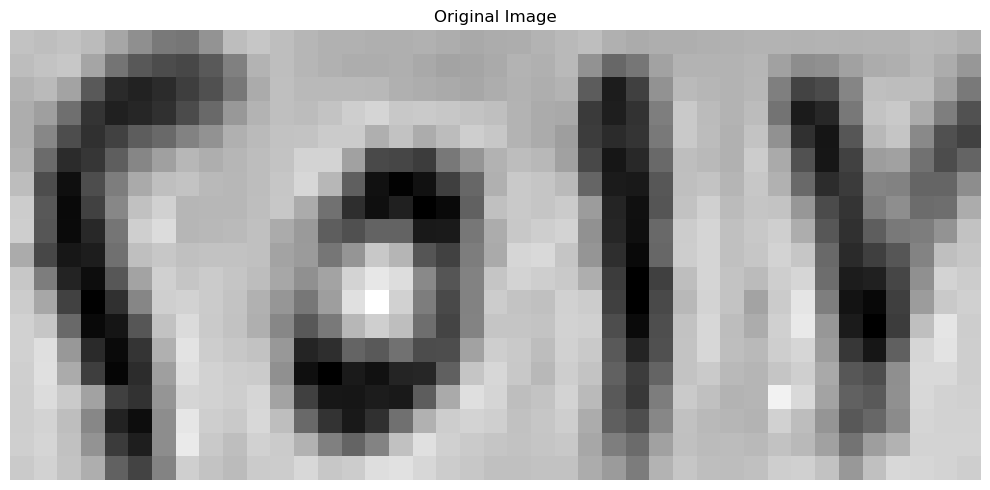

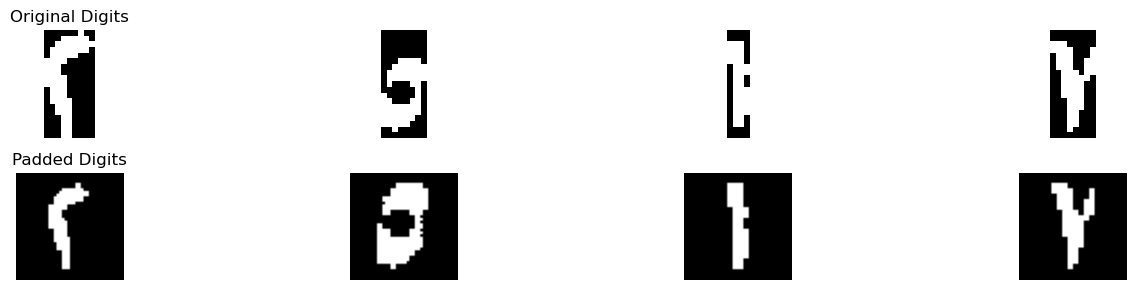

Best match: ٢
Full comparison results: {'١': 0.0, '٢': 0.7875, '٣': 0.7481617647058824, '٤': 0.3125, '٥': 0.29910714285714285, '٦': 0.16041666666666665, '٧': 0.0, '٨': 0.0, '٩': 0.11764705882352941}
Confidence :  0.01966911764705881
Best match: ٥
Full comparison results: {'١': 0.05263157894736842, '٢': 0.25164473684210525, '٣': 0.29276315789473684, '٤': 0.3569078947368421, '٥': 1.2782738095238095, '٦': 0.4506578947368421, '٧': 0.21052631578947367, '٨': 0.05263157894736842, '٩': 0.0}
Confidence :  0.41380795739348375
Best match: ١
Full comparison results: {'١': 0.65625, '٢': 0.3125, '٣': 0.0, '٤': 0.53125, '٥': 0.3005952380952381, '٦': 0.35714285714285715, '٧': 0.33639705882352944, '٨': 0.38541666666666663, '٩': 0.2977941176470588}
Confidence :  0.0625
Best match: ٧
Full comparison results: {'١': 0.125, '٢': 0.59375, '٣': 0.23529411764705882, '٤': 0.34375, '٥': 0.25297619047619047, '٦': 0.25, '٧': 0.7169117647058824, '٨': 0.26041666666666663, '٩': 0.38786764705882354}
Confidence :  0.06

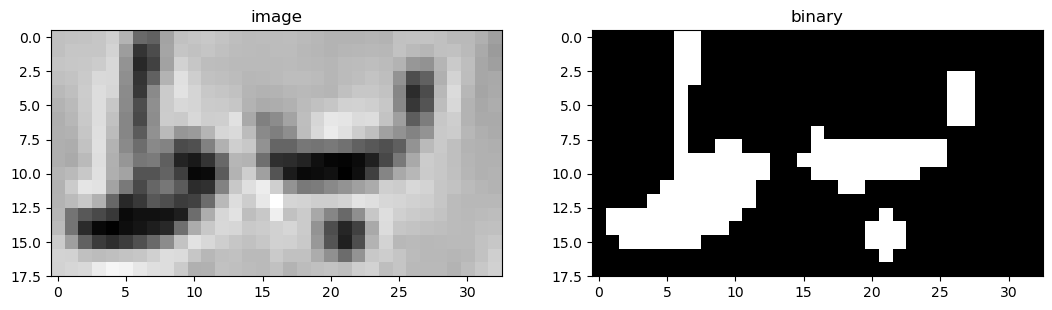

1 13
15 28


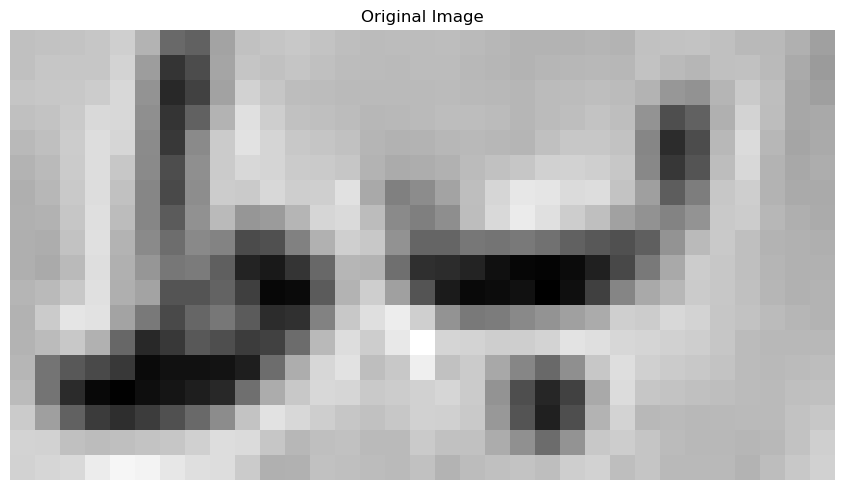

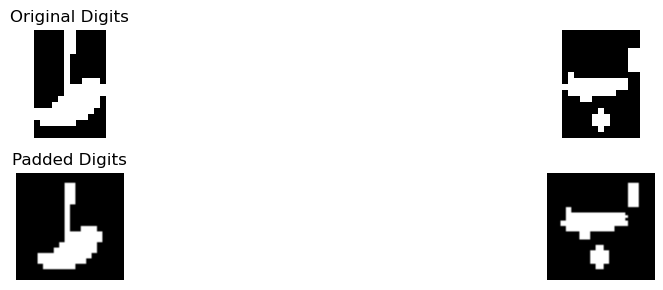

Best match: ط
Full comparison results: {'أ': 0.1875, 'ب': 0.0, 'ج': 0.32291666666666663, 'د': 0.8333333333333334, 'ر': 0.6077586206896552, 'س': 0.375, 'ص': 0.28125, 'ط': 1.6354166666666665, 'ع': 0.15625, 'ف': 0.7372685185185185, 'ق': 0.5833333333333333, 'ك': 0.4895833333333333, 'ل': 0.3125, 'م': 0.07291666666666666, 'ن': 0.6875, 'ه': 0.5, 'و': 0.4583333333333333, 'ي': 0.8028846153846154}
Confidence :  0.4010416666666666
Best match: ب
Full comparison results: {'أ': 0.1314655172413793, 'ب': 0.6958333333333333, 'ج': 0.1724137931034483, 'د': 0.0, 'ر': 0.06573275862068965, 'س': 0.09375, 'ص': 0.4375, 'ط': 0.06896551724137931, 'ع': 0.06896551724137931, 'ف': 0.034482758620689655, 'ق': 0.06896551724137931, 'ك': 0.20689655172413793, 'ل': 0.0, 'م': 0.16594827586206895, 'ن': 0.0, 'ه': 0.03125, 'و': 0.10344827586206896, 'ي': 0.1724137931034483}
Confidence :  0.12916666666666665
[['٢', '٥', '١', '٧'], ['ط', 'ب']]


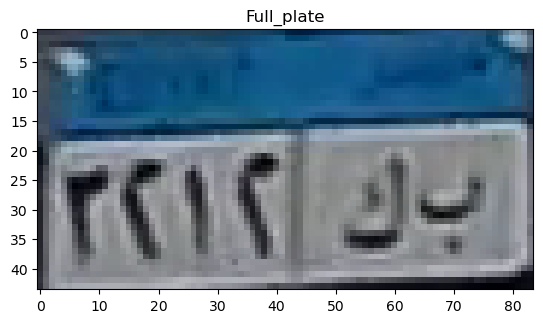

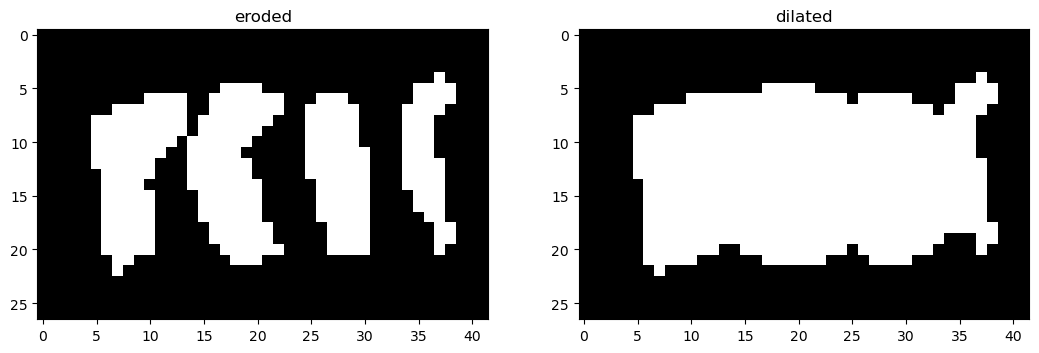

5.0 38.0 4.0 22.0


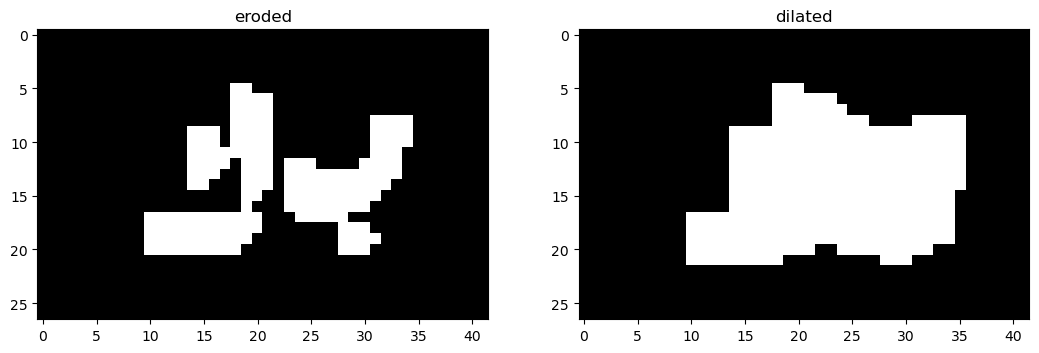

10.0 35.0 5.0 21.0


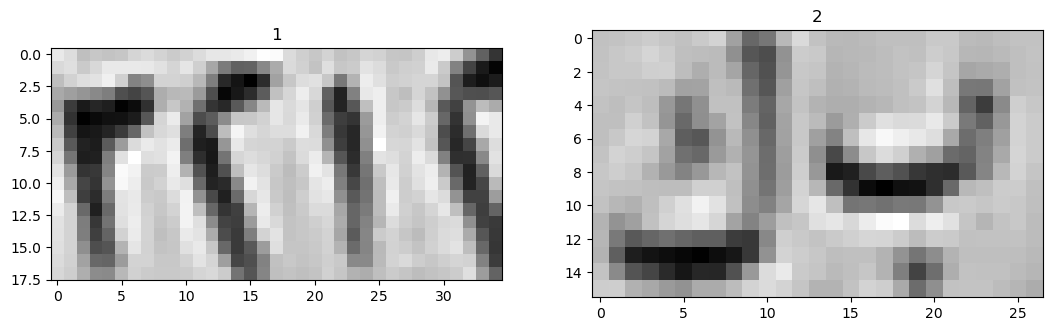

welcome to horizontal seg


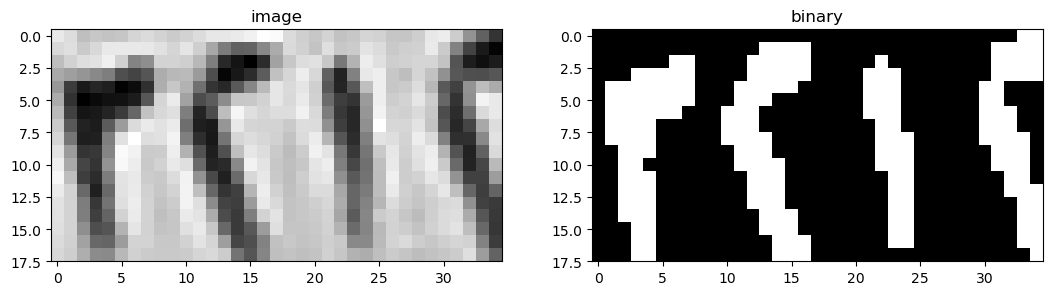

1 8
10 17
21 25
30 34


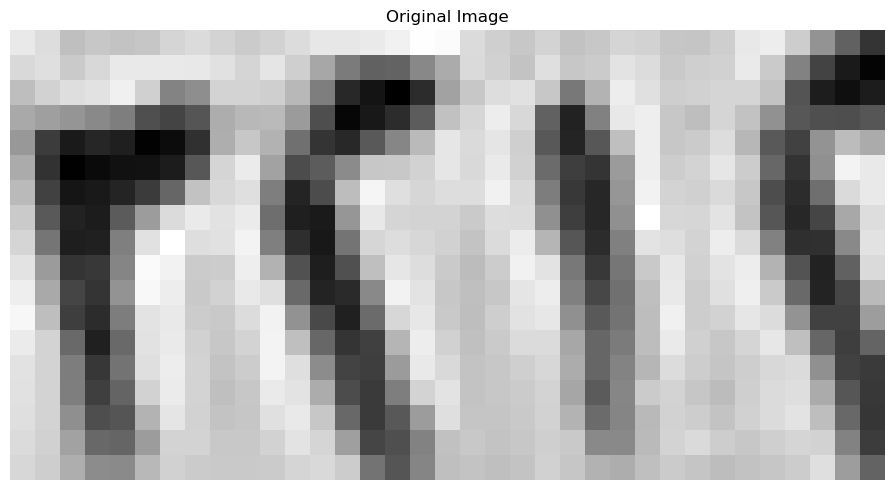

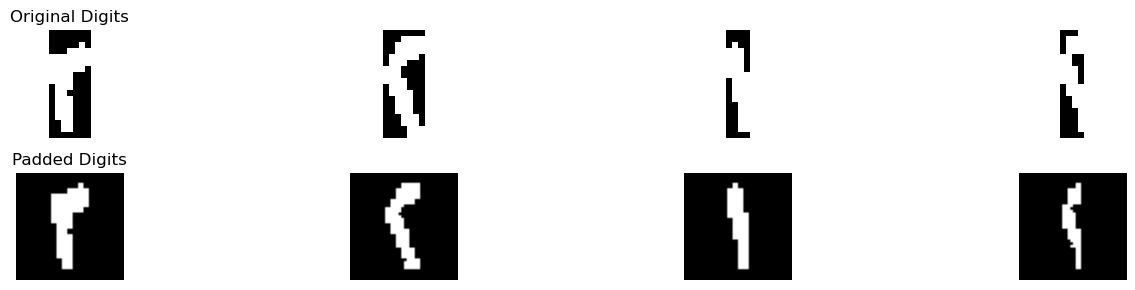

Best match: ٣
Full comparison results: {'١': 0.07142857142857142, '٢': 0.6160714285714286, '٣': 0.7132352941176471, '٤': 0.53125, '٥': 0.5044642857142857, '٦': 0.13392857142857142, '٧': 0.29411764705882354, '٨': 0.1111111111111111, '٩': 0.30147058823529416}
Confidence :  0.04858193277310924
Best match: ٢
Full comparison results: {'١': 0.15384615384615385, '٢': 1.0360576923076923, '٣': 0.5367647058823529, '٤': 0.59375, '٥': 0.3943452380952381, '٦': 0.17410714285714285, '٧': 0.45036764705882354, '٨': 0.0, '٩': 0.1488970588235294}
Confidence :  0.22115384615384615
Best match: ١
Full comparison results: {'١': 0.875, '٢': 0.3958333333333333, '٣': 0.058823529411764705, '٤': 0.625, '٥': 0.19047619047619047, '٦': 0.3080357142857143, '٧': 0.6452205882352942, '٨': 0.5034722222222222, '٩': 0.3290441176470588}
Confidence :  0.11488970588235292
Best match: ٧
Full comparison results: {'١': 0.6026785714285714, '٢': 0.3645833333333333, '٣': 0.0, '٤': 0.53125, '٥': 0.09523809523809523, '٦': 0.267857142

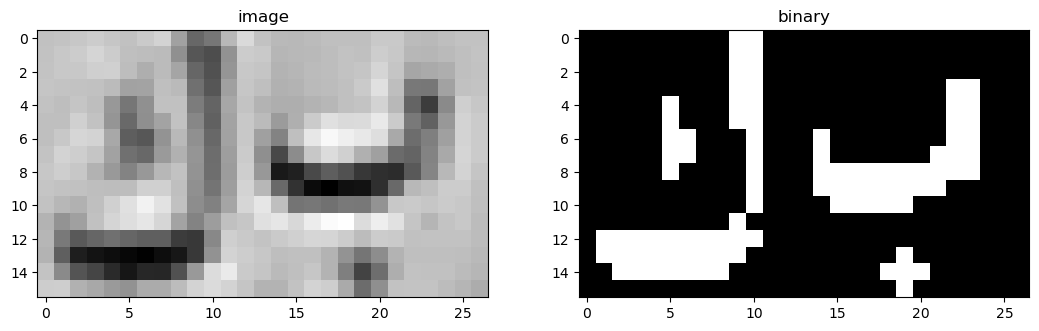

1 11
14 24


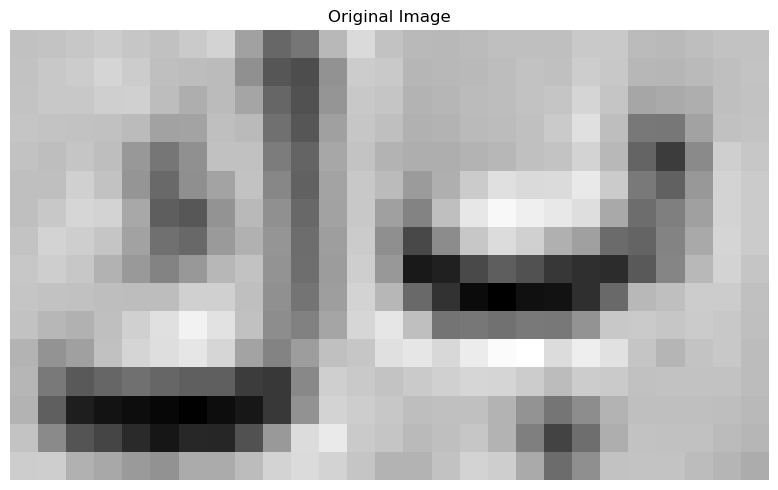

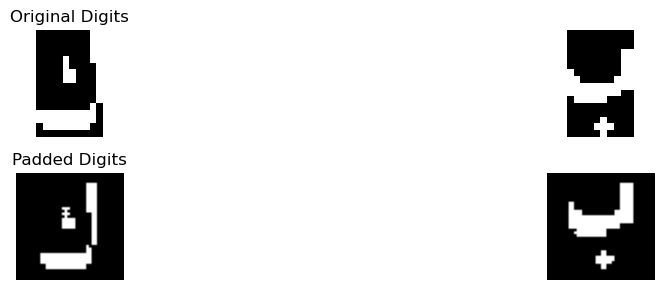

Best match: ك
Full comparison results: {'أ': 0.0, 'ب': 0.125, 'ج': 0.33016304347826086, 'د': 0.6903409090909092, 'ر': 0.8674568965517241, 'س': 0.28125, 'ص': 0.28125, 'ط': 0.78125, 'ع': 0.5535714285714286, 'ف': 0.7002314814814814, 'ق': 0.3630952380952381, 'ك': 1.1041666666666665, 'ل': 0.5074404761904762, 'م': 0.0, 'ن': 0.8854166666666666, 'ه': 0.28125, 'و': 0.7395833333333334, 'ي': 0.65625}
Confidence :  0.10937499999999994
Best match: ب
Full comparison results: {'أ': 0.1875, 'ب': 0.7366071428571428, 'ج': 0.08333333333333333, 'د': 0.0, 'ر': 0.3976293103448276, 'س': 0.125, 'ص': 0.4375, 'ط': 0.041666666666666664, 'ع': 0.0, 'ف': 0.07407407407407407, 'ق': 0.125, 'ك': 0.4583333333333333, 'ل': 0.041666666666666664, 'م': 0.08333333333333333, 'ن': 0.08333333333333333, 'ه': 0.09375, 'و': 0.2916666666666667, 'ي': 0.2620192307692308}
Confidence :  0.13913690476190474
[['٣', '٢', '١', '٧'], ['ك', 'ب']]


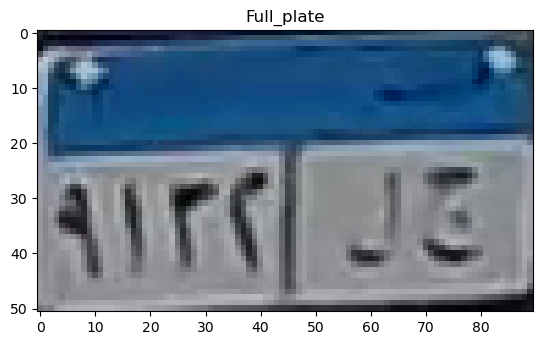

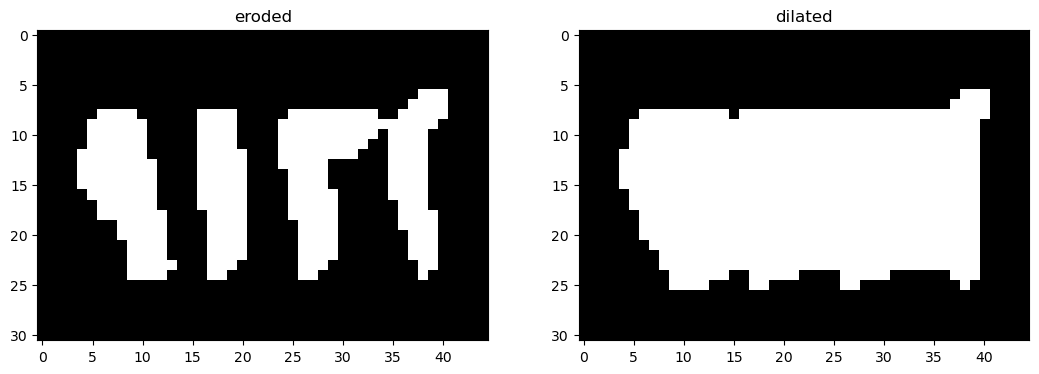

4.0 40.0 6.0 25.0


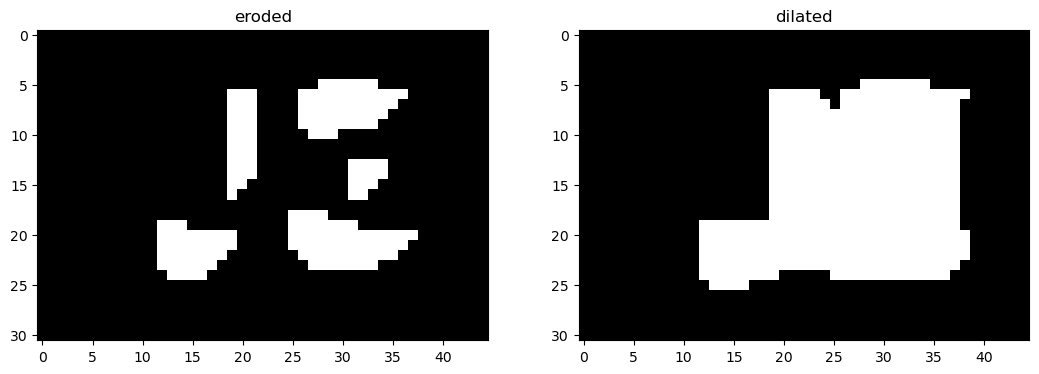

12.0 38.0 5.0 25.0


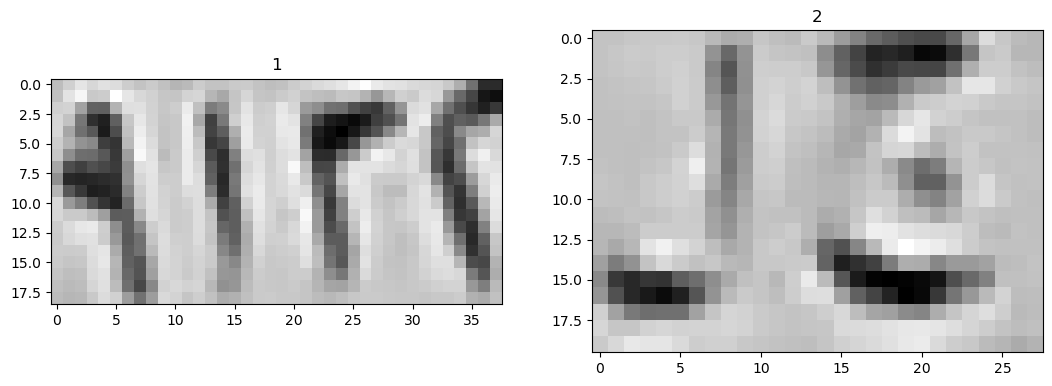

welcome to horizontal seg


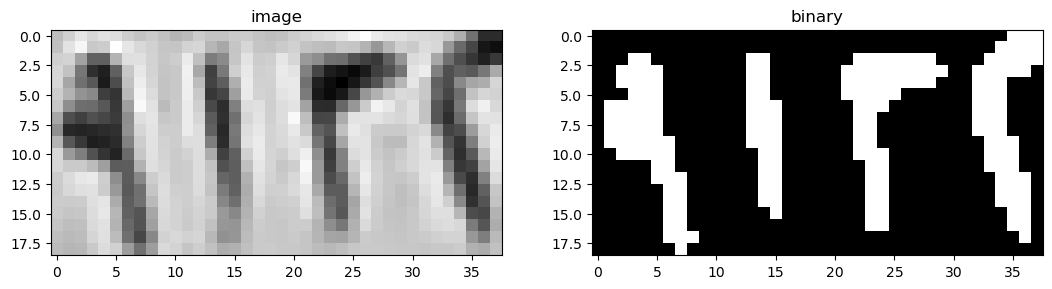

1 9
13 16
21 30
32 37


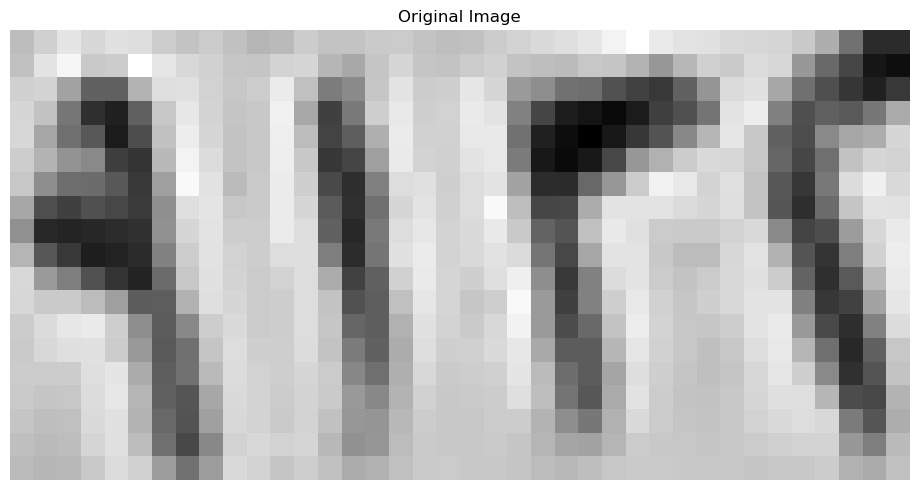

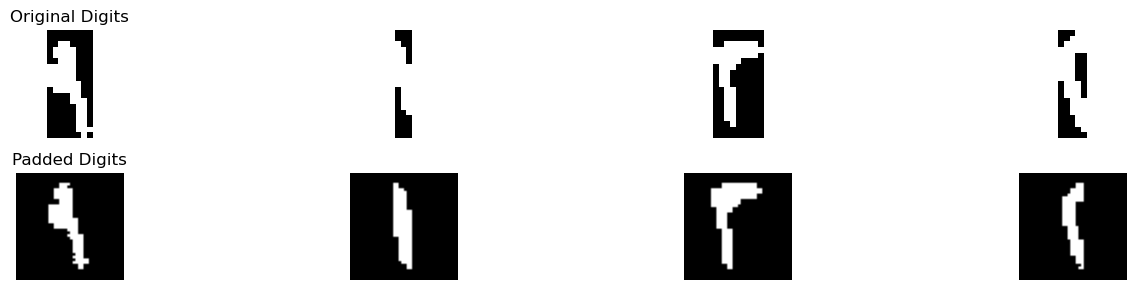

Best match: ٩
Full comparison results: {'١': 0.4583333333333333, '٢': 0.3333333333333333, '٣': 0.17647058823529413, '٤': 0.4375, '٥': 0.047619047619047616, '٦': 0.4145833333333333, '٧': 0.38786764705882354, '٨': 0.3333333333333333, '٩': 1.0183823529411766}
Confidence :  0.2800245098039217
Best match: ٤
Full comparison results: {'١': 0.4419642857142857, '٢': 0.4479166666666667, '٣': 0.058823529411764705, '٤': 0.65625, '٥': 0.23809523809523808, '٦': 0.17410714285714285, '٧': 0.39889705882352944, '٨': 0.2673611111111111, '٩': 0.27022058823529416}
Confidence :  0.10416666666666666
Best match: ٣
Full comparison results: {'١': 0.10526315789473684, '٢': 0.24177631578947367, '٣': 0.9654605263157895, '٤': 0.2730263157894737, '٥': 0.3482142857142857, '٦': 0.3980263157894737, '٧': 0.18914473684210525, '٨': 0.10526315789473684, '٩': 0.21052631578947367}
Confidence :  0.2837171052631579
Best match: ٤
Full comparison results: {'١': 0.46875, '٢': 0.4791666666666667, '٣': 0.0900735294117647, '٤': 0.90

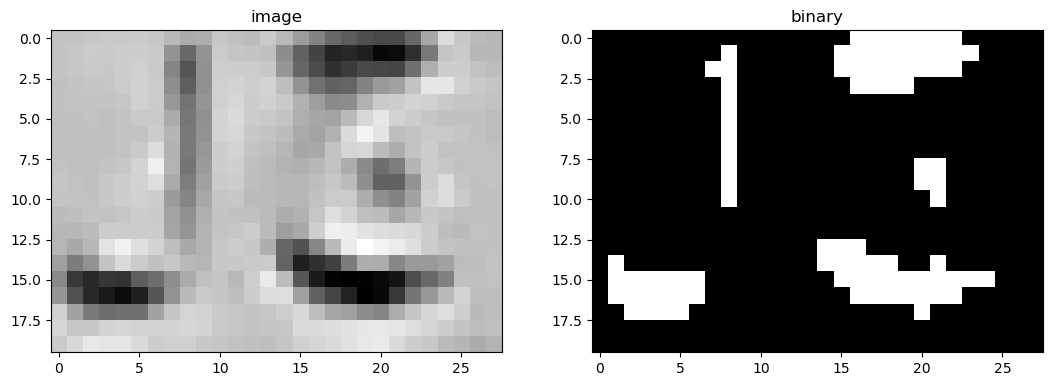

1 9
14 25


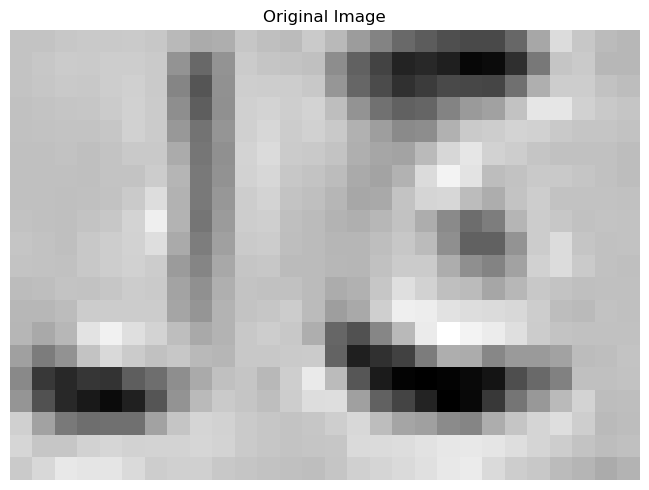

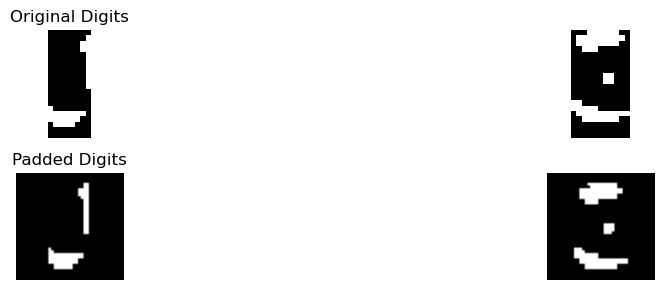

Best match: ل
Full comparison results: {'أ': 0.0, 'ب': 0.03125, 'ج': 0.13722826086956522, 'د': 0.3522727272727273, 'ر': 0.4418103448275862, 'س': 0.21875, 'ص': 0.125, 'ط': 0.3229166666666667, 'ع': 0.2546689303904923, 'ف': 0.2534722222222222, 'ق': 0.4934210526315789, 'ك': 0.25, 'ل': 0.96875, 'م': 0.0625, 'ن': 0.625, 'ه': 0.125, 'و': 0.6770833333333333, 'ي': 0.5096153846153846}
Confidence :  0.14583333333333337
Best match: ج
Full comparison results: {'أ': 0.0, 'ب': 0.09375, 'ج': 0.9524456521739131, 'د': 0.7159090909090909, 'ر': 0.09375, 'س': 0.125, 'ص': 0.125, 'ط': 0.25, 'ع': 0.6935483870967742, 'ف': 0.49537037037037035, 'ق': 0.6790322580645162, 'ك': 0.20833333333333331, 'ل': 0.1625, 'م': 0.18125, 'ن': 0.525, 'ه': 0.125, 'و': 0.17708333333333331, 'ي': 0.3245192307692308}
Confidence :  0.11826828063241107
[['٩', '٤', '٣', '٤'], ['ل', 'ج']]


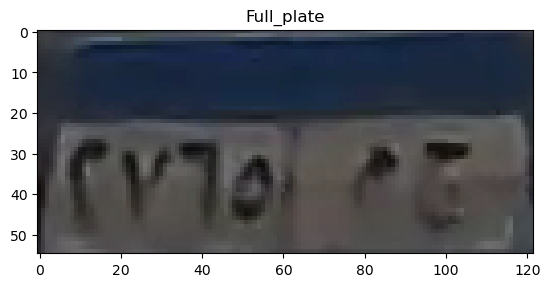

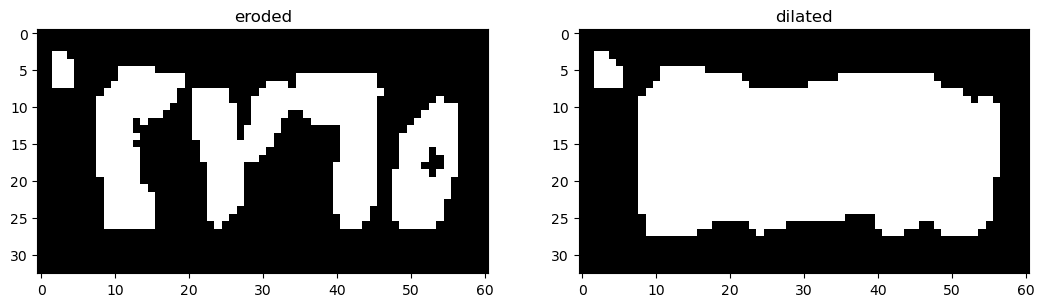

8.0 56.0 5.0 27.0


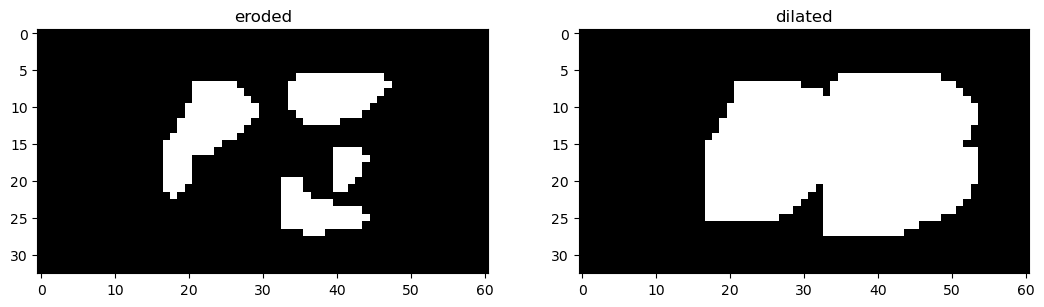

17.0 53.0 6.0 27.0


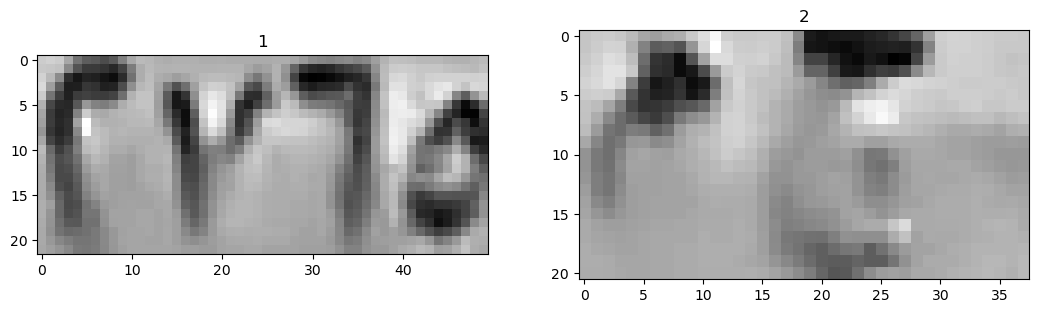

welcome to horizontal seg


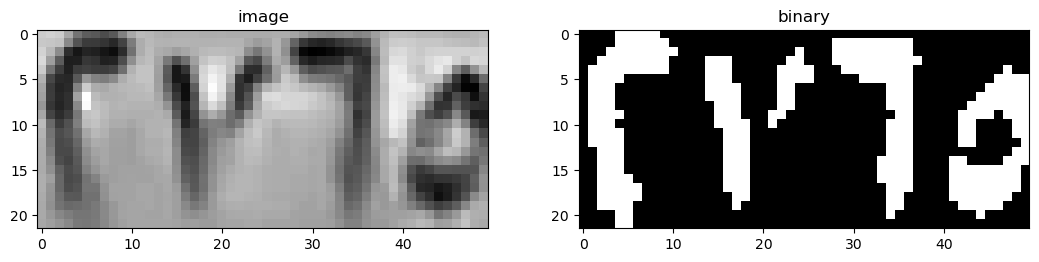

1 11
14 19
21 26
28 38
41 49


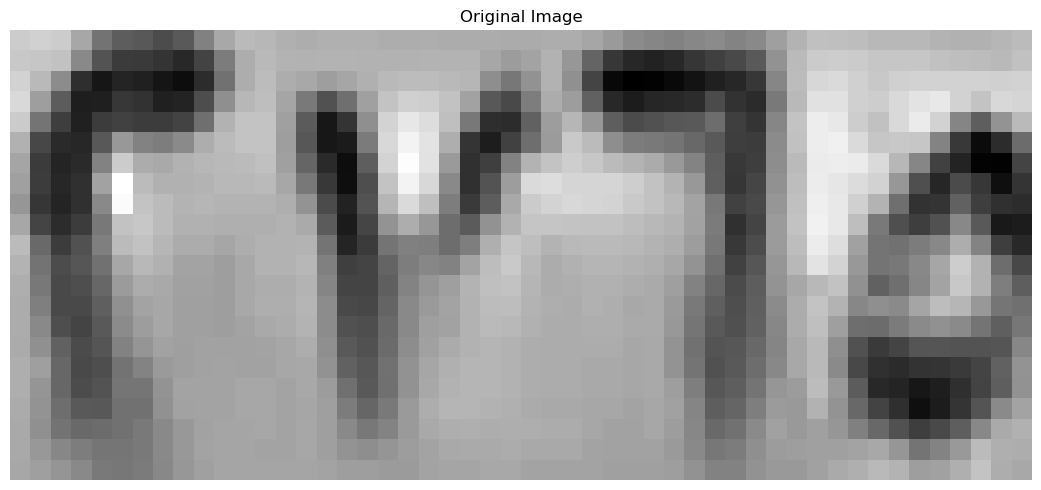

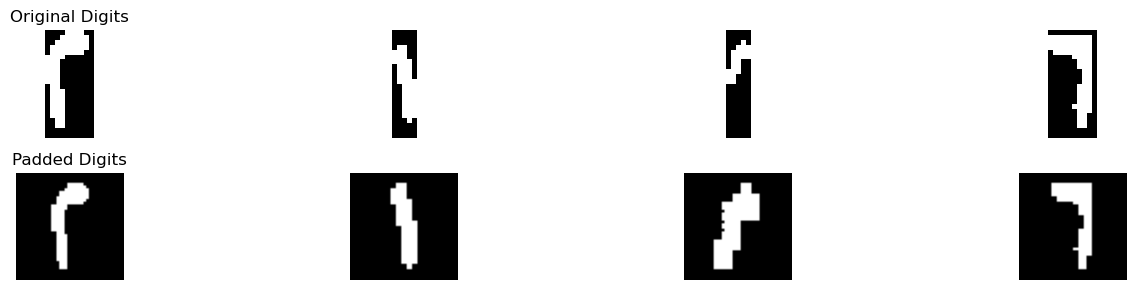

Best match: ٣
Full comparison results: {'١': 0.0, '٢': 0.6785714285714286, '٣': 0.8970588235294118, '٤': 0.40625, '٥': 0.44047619047619047, '٦': 0.3080357142857143, '٧': 0.1801470588235294, '٨': 0.1111111111111111, '٩': 0.058823529411764705}
Confidence :  0.1092436974789916
Best match: ٦
Full comparison results: {'١': 0.61875, '٢': 0.3645833333333333, '٣': 0.0625, '٤': 0.46875, '٥': 0.23809523809523808, '٦': 0.8035714285714286, '٧': 0.36764705882352944, '٨': 0.6145833333333333, '٩': 0.36397058823529416}
Confidence :  0.09241071428571429
Best match: ٥
Full comparison results: {'١': 0.17647058823529413, '٢': 0.2113970588235294, '٣': 0.32536764705882354, '٤': 0.5367647058823529, '٥': 0.6488095238095238, '٦': 0.20772058823529413, '٧': 0.20772058823529413, '٨': 0.2777777777777778, '٩': 0.23529411764705882}
Confidence :  0.05602240896358546
Best match: ٦
Full comparison results: {'١': 0.13333333333333333, '٢': 0.0625, '٣': 0.5992647058823529, '٤': 0.0, '٥': 0.4419642857142857, '٦': 1.3, '٧':

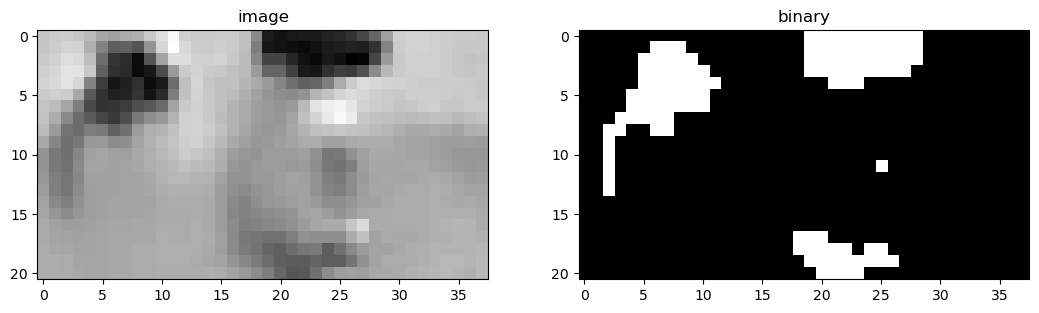

2 12
18 29


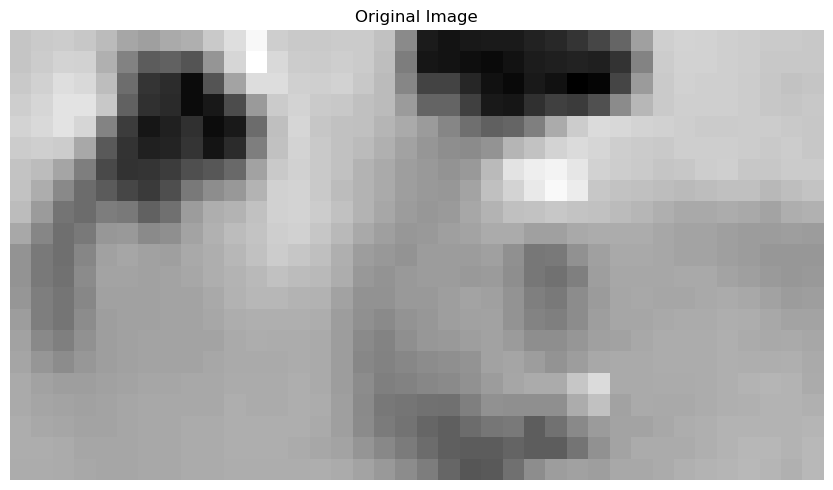

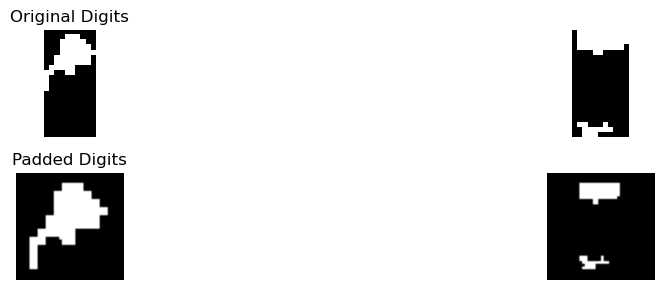

Best match: م
Full comparison results: {'أ': 0.06896551724137931, 'ب': 0.25, 'ج': 0.23168103448275862, 'د': 0.16594827586206895, 'ر': 0.034482758620689655, 'س': 0.53125, 'ص': 0.46875, 'ط': 0.06896551724137931, 'ع': 0.06896551724137931, 'ف': 0.06896551724137931, 'ق': 0.13793103448275862, 'ك': 0.0, 'ل': 0.06896551724137931, 'م': 0.5668103448275862, 'ن': 0.13469827586206895, 'ه': 0.34375, 'و': 0.3103448275862069, 'ي': 0.034482758620689655}
Confidence :  0.017780172413793094
Best match: ج
Full comparison results: {'أ': 0.0, 'ب': 0.0, 'ج': 0.49184782608695654, 'د': 0.42613636363636365, 'ر': 0.03125, 'س': 0.0, 'ص': 0.0, 'ط': 0.08333333333333333, 'ع': 0.10526315789473684, 'ف': 0.25925925925925924, 'ق': 0.465195246179966, 'ك': 0.041666666666666664, 'ل': 0.15625, 'م': 0.34375, 'ن': 0.33125, 'ه': 0.0, 'و': 0.03125, 'ي': 0.10096153846153846}
Confidence :  0.013326289953495274
[['٣', '٦', '٥', '٦'], ['م', 'ج']]


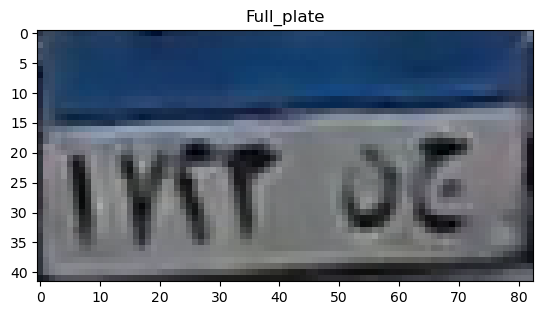

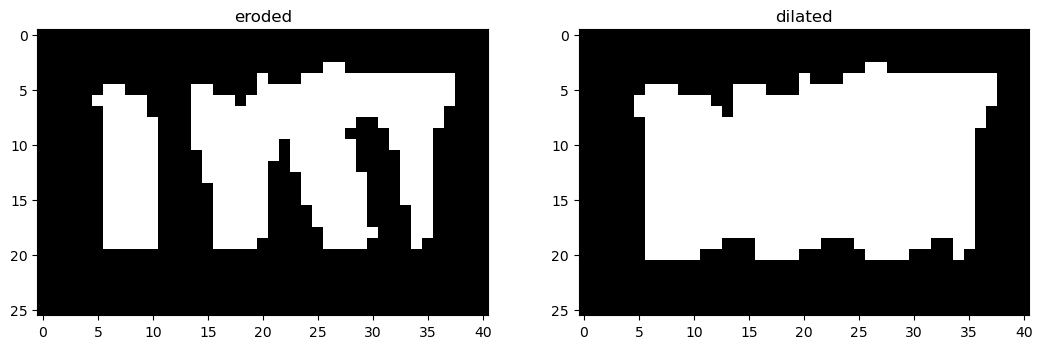

5.0 37.0 3.0 20.0


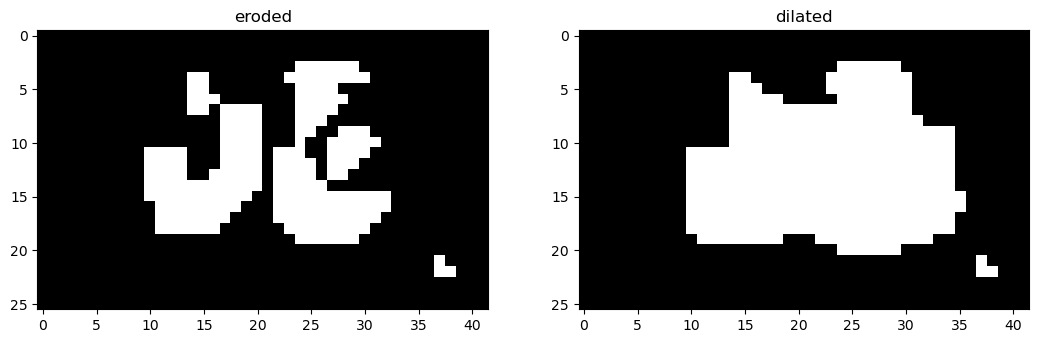

10.0 35.0 3.0 20.0


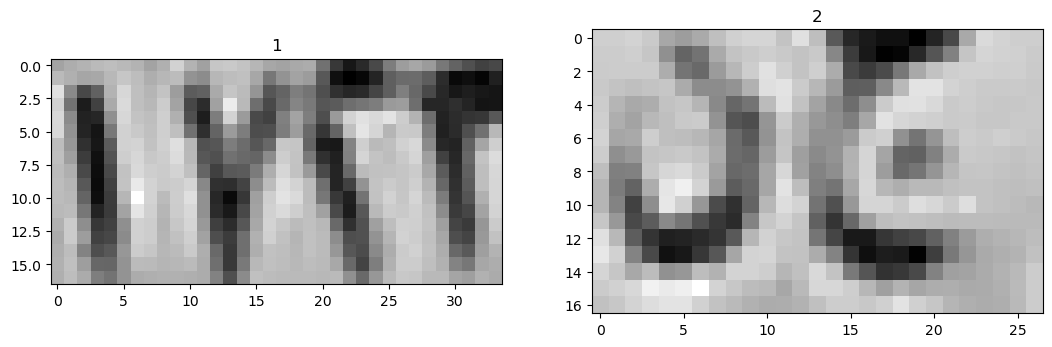

welcome to horizontal seg


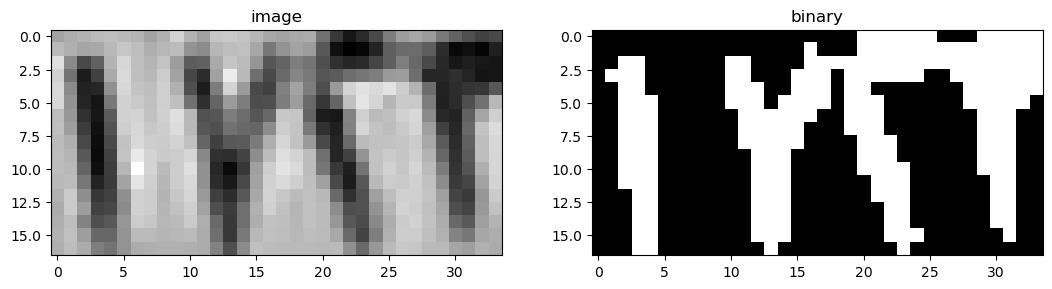

1 5
10 33


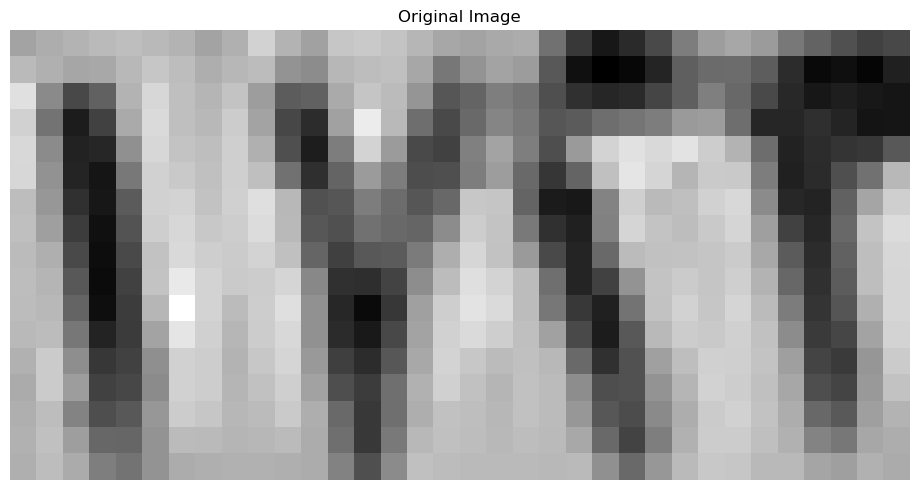

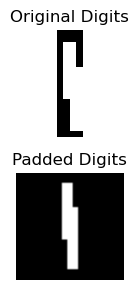

Best match: ١
Full comparison results: {'١': 0.78125, '٢': 0.5208333333333333, '٣': 0.058823529411764705, '٤': 0.6875, '٥': 0.19047619047619047, '٦': 0.14285714285714285, '٧': 0.5863970588235294, '٨': 0.3298611111111111, '٩': 0.23897058823529413}
Confidence :  0.046875
welcome to horizontal seg


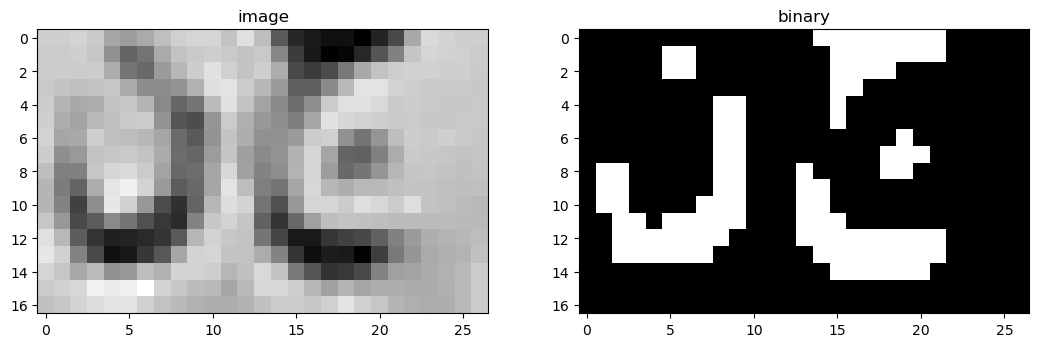

1 10
13 22


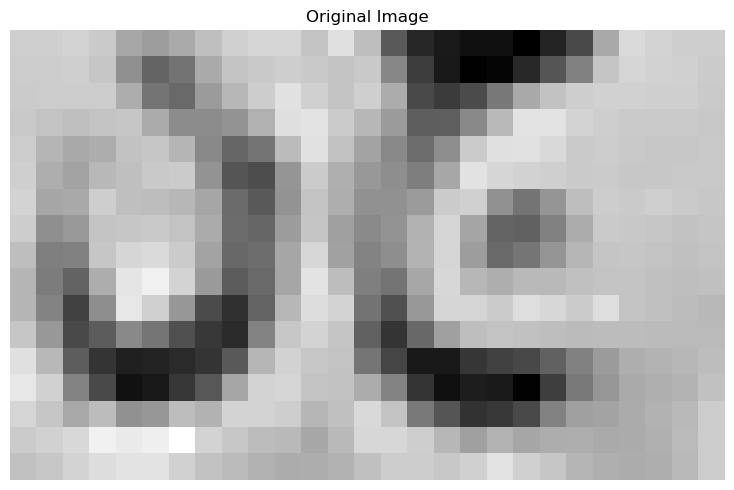

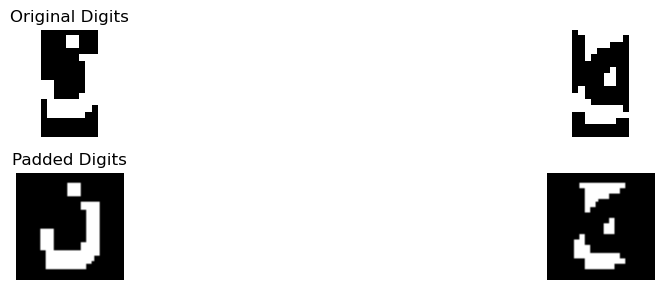

Best match: د
Full comparison results: {'أ': 0.0, 'ب': 0.0, 'ج': 0.4171195652173913, 'د': 1.1306818181818183, 'ر': 0.6422413793103449, 'س': 0.25, 'ص': 0.0, 'ط': 0.4895833333333333, 'ع': 0.3977272727272727, 'ف': 0.7997685185185185, 'ق': 0.7159090909090909, 'ك': 0.32291666666666663, 'ل': 0.42613636363636365, 'م': 0.0, 'ن': 0.8818181818181818, 'ه': 0.34375, 'و': 0.6979166666666666, 'ي': 0.4254807692307692}
Confidence :  0.12443181818181825
Best match: ج
Full comparison results: {'أ': 0.0, 'ب': 0.09375, 'ج': 0.9714673913043478, 'د': 0.6278409090909092, 'ر': 0.22844827586206895, 'س': 0.09375, 'ص': 0.09375, 'ط': 0.3125, 'ع': 0.5773026315789473, 'ف': 0.5578703703703703, 'ق': 0.7664473684210527, 'ك': 0.375, 'ل': 0.17763157894736842, 'م': 0.22039473684210525, 'ن': 0.6375, 'ه': 0.09375, 'و': 0.375, 'ي': 0.3485576923076923}
Confidence :  0.10251001144164756
[['١'], ['د', 'ج']]


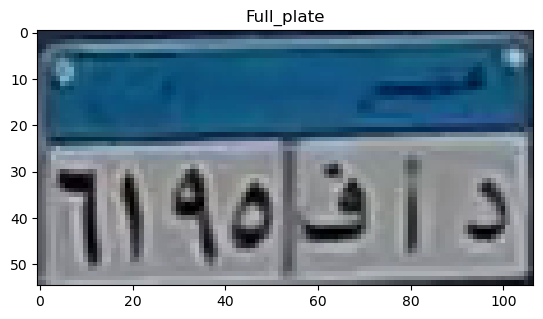

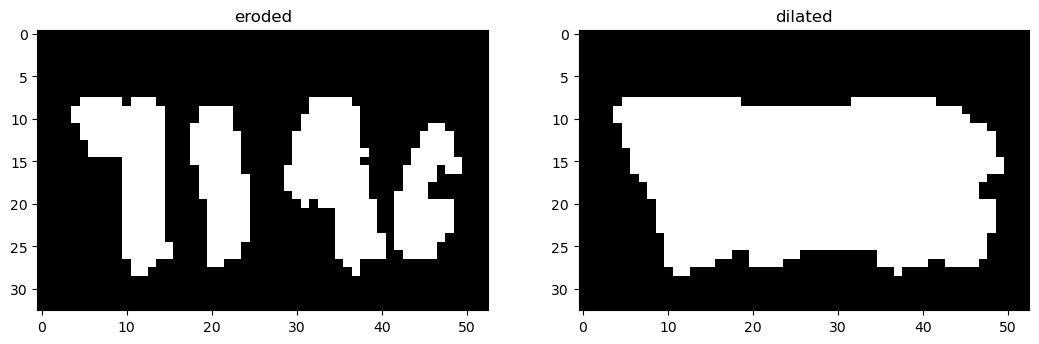

4.0 49.0 8.0 28.0


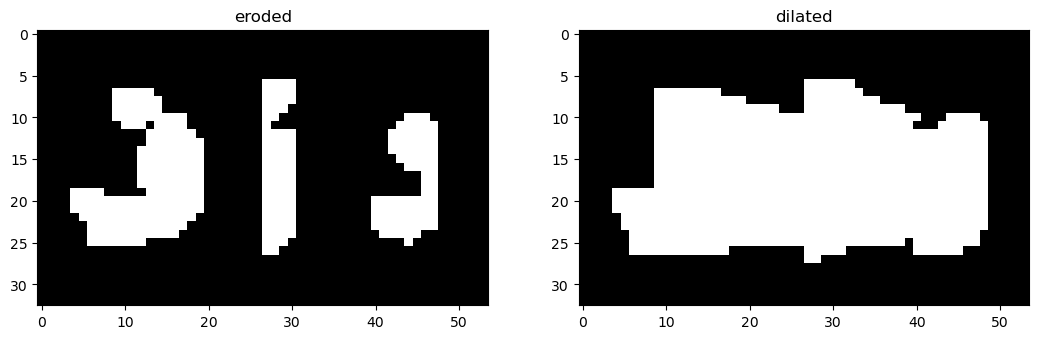

4.0 48.0 6.0 27.0


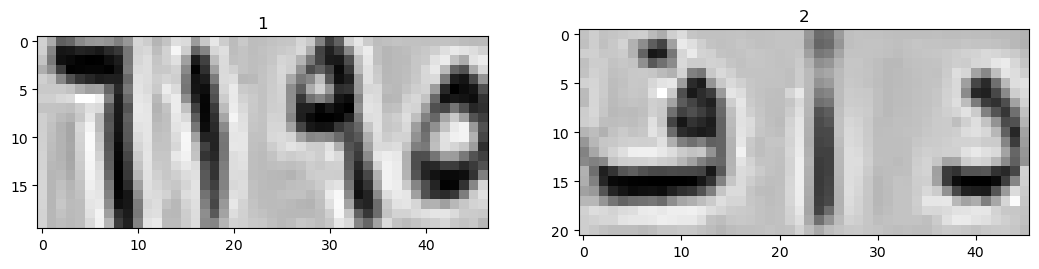

welcome to horizontal seg


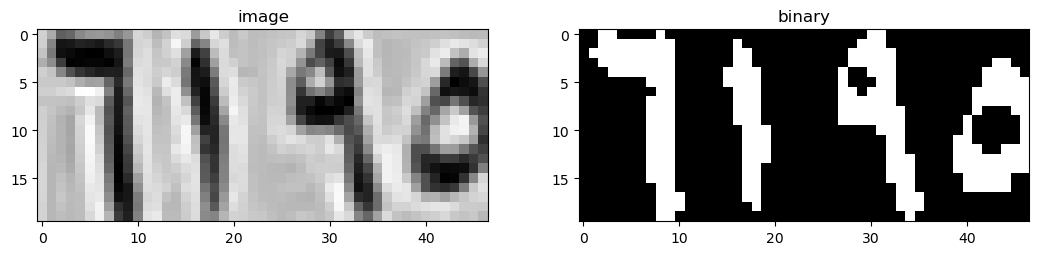

1 11
15 20
27 36
39 46


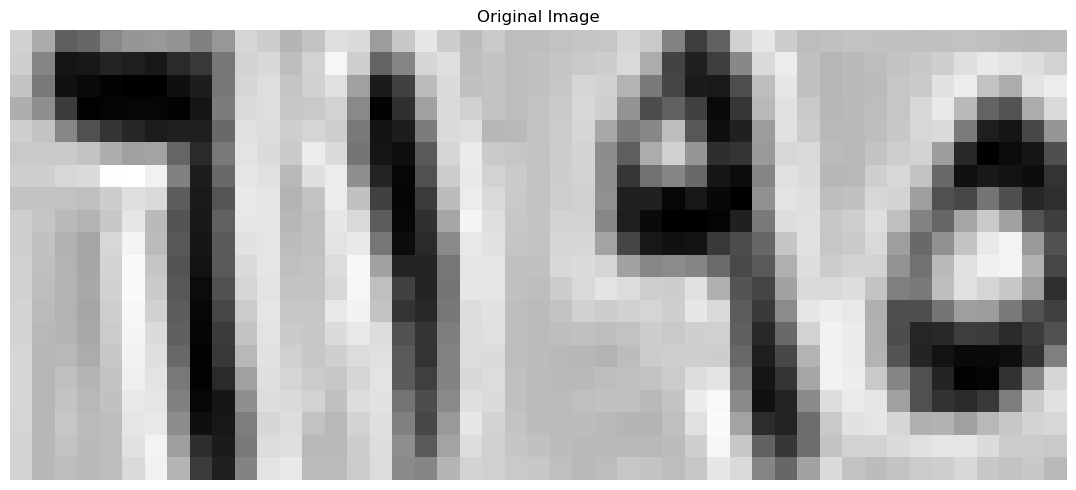

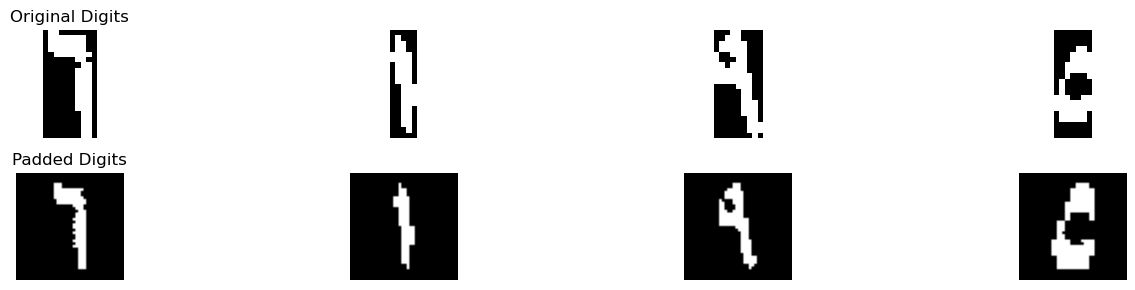

Best match: ٦
Full comparison results: {'١': 0.08333333333333333, '٢': 0.125, '٣': 0.38786764705882354, '٤': 0.0, '٥': 0.37797619047619047, '٦': 1.3794642857142856, '٧': 0.0, '٨': 0.3715277777777778, '٩': 0.4540441176470588}
Confidence :  0.46271008403361336
Best match: ١
Full comparison results: {'١': 0.875, '٢': 0.46875, '٣': 0.0, '٤': 0.4375, '٥': 0.19047619047619047, '٦': 0.10267857142857142, '٧': 0.49264705882352944, '٨': 0.4722222222222222, '٩': 0.23897058823529413}
Confidence :  0.19117647058823528
Best match: ٩
Full comparison results: {'١': 0.3169642857142857, '٢': 0.41964285714285715, '٣': 0.23529411764705882, '٤': 0.25, '٥': 0.14285714285714285, '٦': 0.4955357142857143, '٧': 0.35294117647058826, '٨': 0.5694444444444444, '٩': 0.9908088235294118}
Confidence :  0.2106821895424837
Best match: ٥
Full comparison results: {'١': 0.0625, '٢': 0.15625, '٣': 0.18382352941176472, '٤': 0.6875, '٥': 1.0729166666666665, '٦': 0.34375, '٧': 0.0, '٨': 0.2847222222222222, '٩': 0.0}
Confidence 

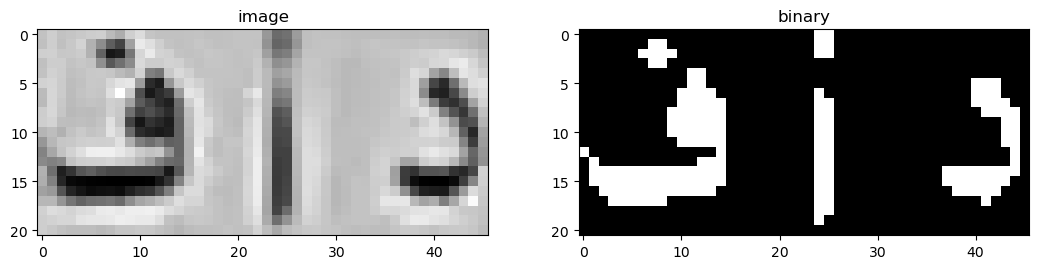

0 15
24 26
37 45


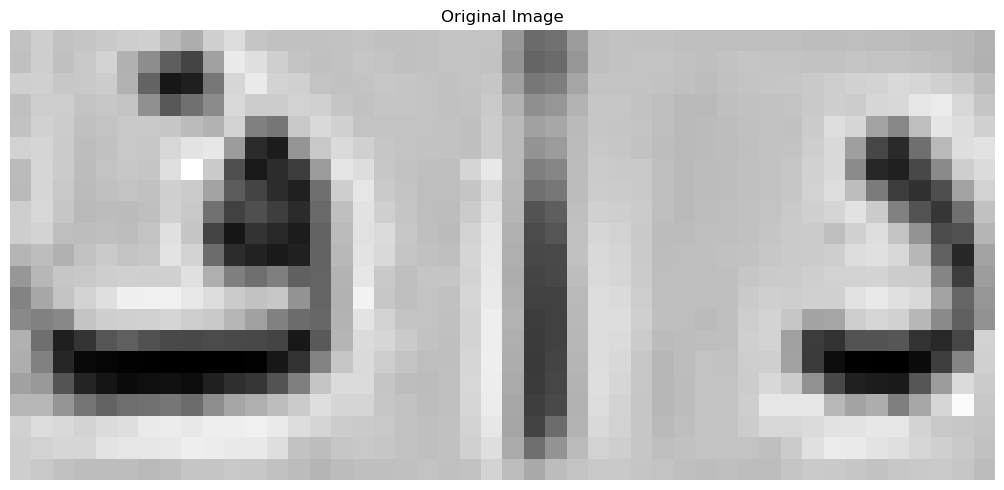

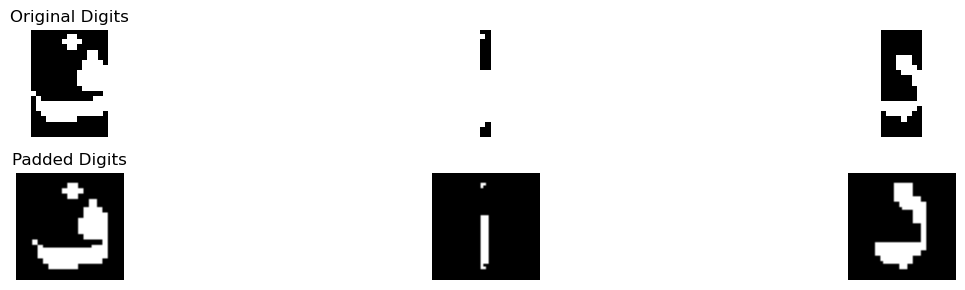

Best match: ف
Full comparison results: {'أ': 0.06696428571428571, 'ب': 0.0, 'ج': 0.4107142857142857, 'د': 0.9285714285714286, 'ر': 0.6109913793103449, 'س': 0.375, 'ص': 0.28125, 'ط': 0.5758928571428572, 'ع': 0.29910714285714285, 'ف': 1.09375, 'ق': 0.45982142857142855, 'ك': 0.5491071428571428, 'ل': 0.3169642857142857, 'م': 0.0625, 'ن': 0.8169642857142857, 'ه': 0.78125, 'و': 0.6919642857142857, 'ي': 0.75}
Confidence :  0.0825892857142857
Best match: أ
Full comparison results: {'أ': 0.9333333333333333, 'ب': 0.0, 'ج': 0.08695652173913043, 'د': 0.0, 'ر': 0.0, 'س': 0.0, 'ص': 0.09375, 'ط': 0.25, 'ع': 0.0, 'ف': 0.0, 'ق': 0.0, 'ك': 0.0, 'ل': 0.0, 'م': 0.0, 'ن': 0.03333333333333333, 'ه': 0.09375, 'و': 0.0, 'ي': 0.038461538461538464}
Confidence :  0.3416666666666667
Best match: د
Full comparison results: {'أ': 0.05263157894736842, 'ب': 0.0, 'ج': 0.39809782608695654, 'د': 1.1505681818181817, 'ر': 0.0625, 'س': 0.4375, 'ص': 0.28125, 'ط': 0.27083333333333337, 'ع': 0.08388157894736842, 'ف': 0.432870370

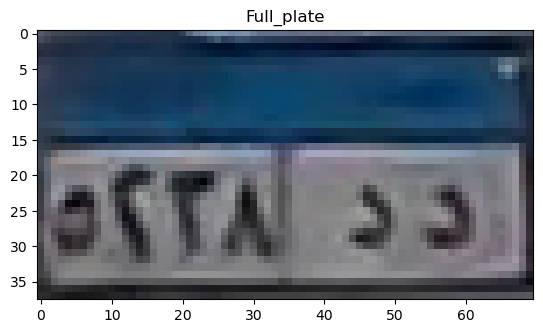

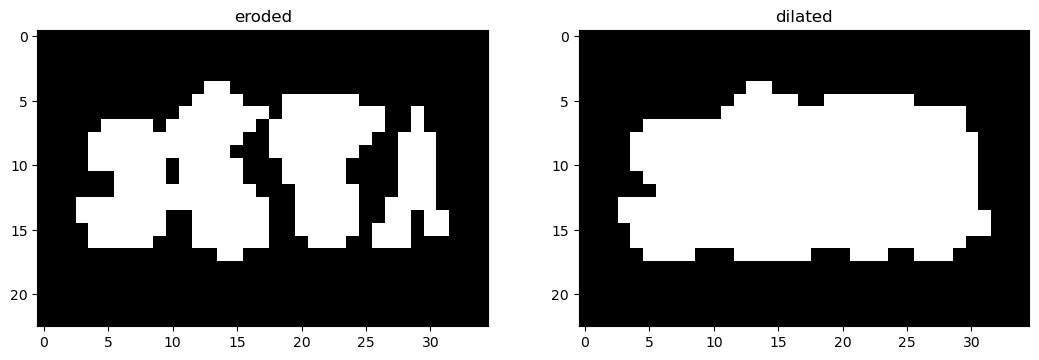

3.0 31.0 4.0 17.0


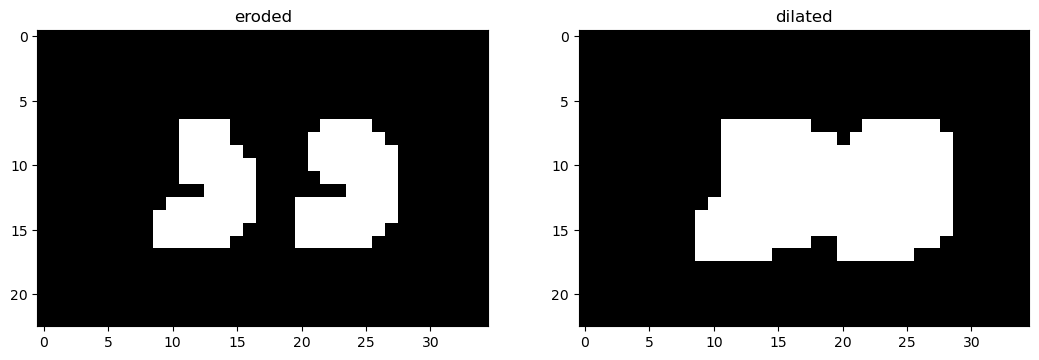

9.0 28.0 7.0 17.0


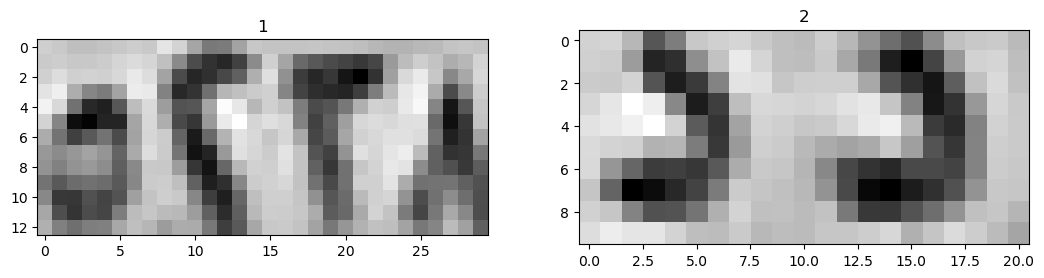

welcome to horizontal seg


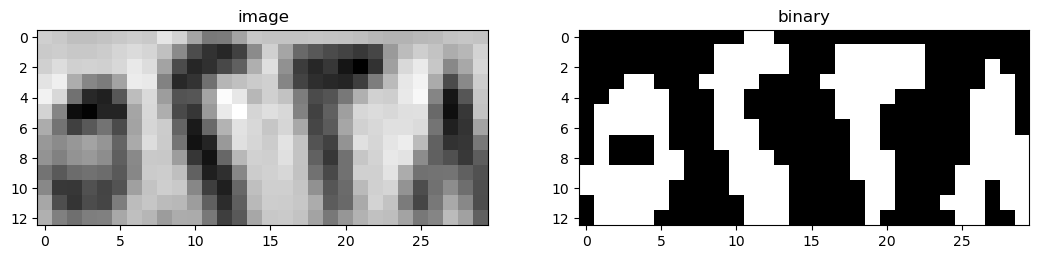

0 7
8 14
16 23
24 29


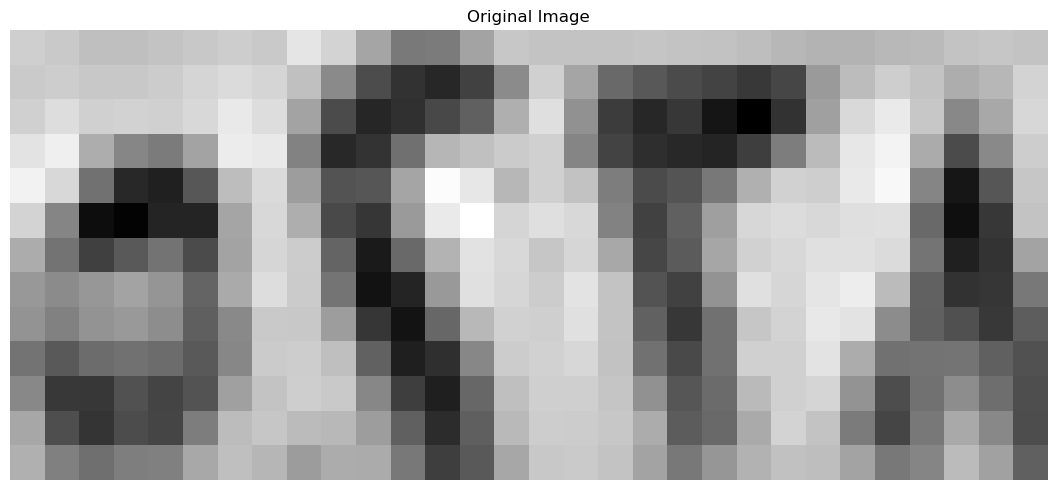

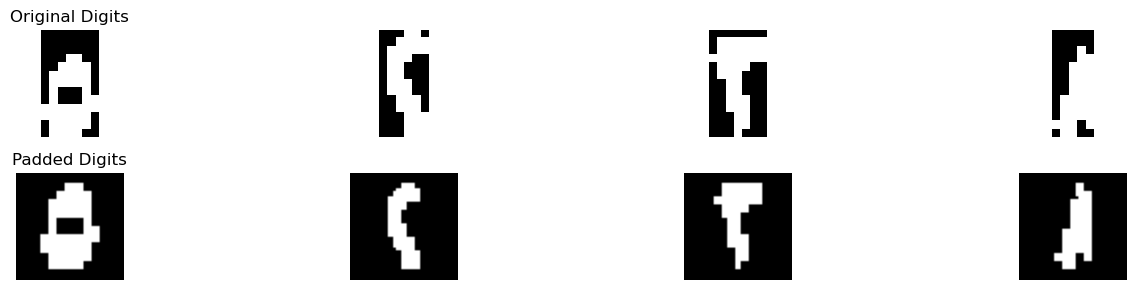

Best match: ٥
Full comparison results: {'١': 0.09090909090909091, '٢': 0.26136363636363635, '٣': 0.2471590909090909, '٤': 0.5369318181818181, '٥': 1.3977272727272727, '٦': 0.3210227272727273, '٧': 0.13636363636363635, '٨': 0.045454545454545456, '٩': 0.03125}
Confidence :  0.4303977272727273
Best match: ٢
Full comparison results: {'١': 0.16666666666666666, '٢': 0.9166666666666666, '٣': 0.2977941176470588, '٤': 0.59375, '٥': 0.4568452380952381, '٦': 0.3392857142857143, '٧': 0.3915441176470588, '٨': 0.0, '٩': 0.058823529411764705}
Confidence :  0.16145833333333331
Best match: ٢
Full comparison results: {'١': 0.16666666666666666, '٢': 0.625, '٣': 0.6076388888888888, '٤': 0.4895833333333333, '٥': 0.4732142857142857, '٦': 0.4652777777777778, '٧': 0.5069444444444444, '٨': 0.0, '٩': 0.2222222222222222}
Confidence :  0.00868055555555558
Best match: ٥
Full comparison results: {'١': 0.14285714285714285, '٢': 0.07142857142857142, '٣': 0.058823529411764705, '٤': 0.46875, '٥': 0.5238095238095238, '٦

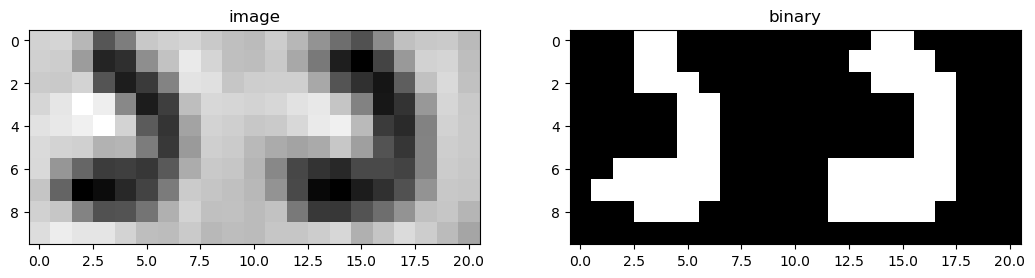

1 7
12 18


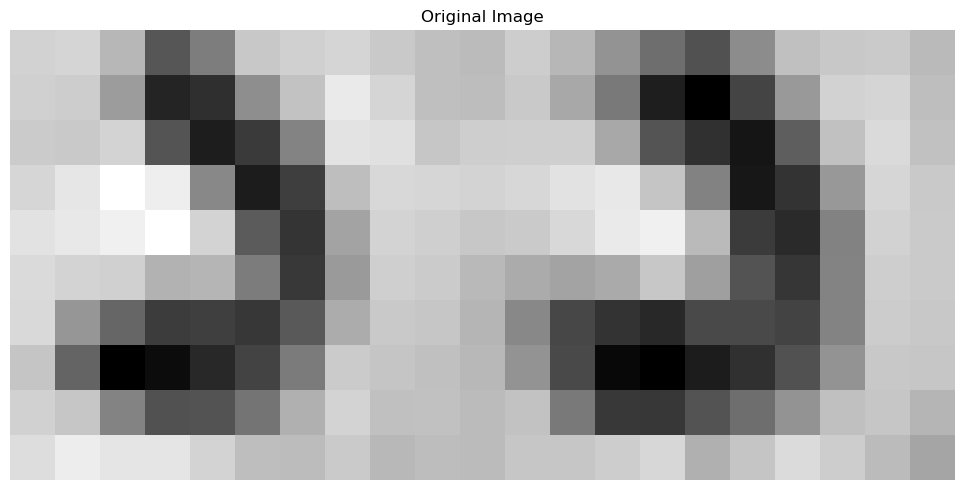

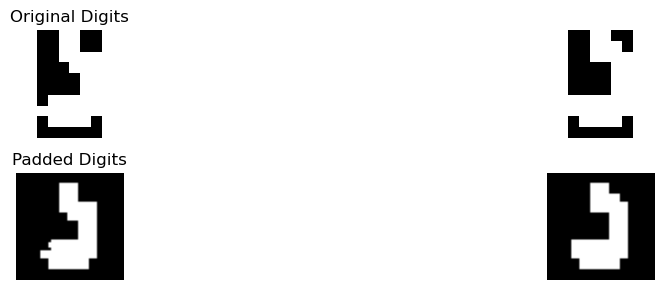

Best match: د
Full comparison results: {'أ': 0.047619047619047616, 'ب': 0.0, 'ج': 0.40489130434782605, 'د': 1.1619318181818183, 'ر': 0.1939655172413793, 'س': 0.375, 'ص': 0.1875, 'ط': 0.5729166666666667, 'ع': 0.25148809523809523, 'ف': 0.9363425925925926, 'ق': 0.6800595238095238, 'ك': 0.40625, 'ل': 0.3005952380952381, 'م': 0.34523809523809523, 'ن': 0.6309523809523809, 'ه': 0.875, 'و': 0.59375, 'ي': 0.5721153846153846}
Confidence :  0.11279461279461289
Best match: د
Full comparison results: {'أ': 0.09523809523809523, 'ب': 0.0, 'ج': 0.5788043478260869, 'د': 1.3323863636363638, 'ر': 0.1939655172413793, 'س': 0.40625, 'ص': 0.21875, 'ط': 0.4895833333333333, 'ع': 0.29910714285714285, 'ف': 0.8738425925925926, 'ق': 0.7113095238095238, 'ك': 0.40625, 'ل': 0.3005952380952381, 'م': 0.5505952380952381, 'ن': 0.8690476190476191, 'ه': 0.90625, 'و': 0.5, 'ي': 0.5336538461538461}
Confidence :  0.21306818181818188
[['٥', '٢', '٢', '٥'], ['د', 'د']]


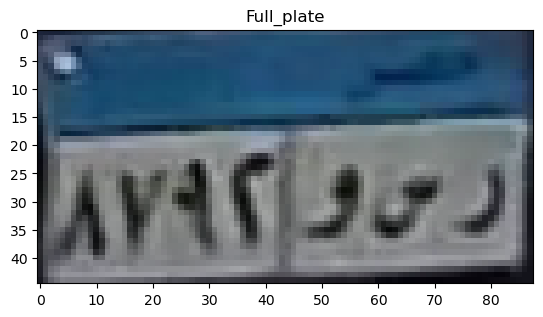

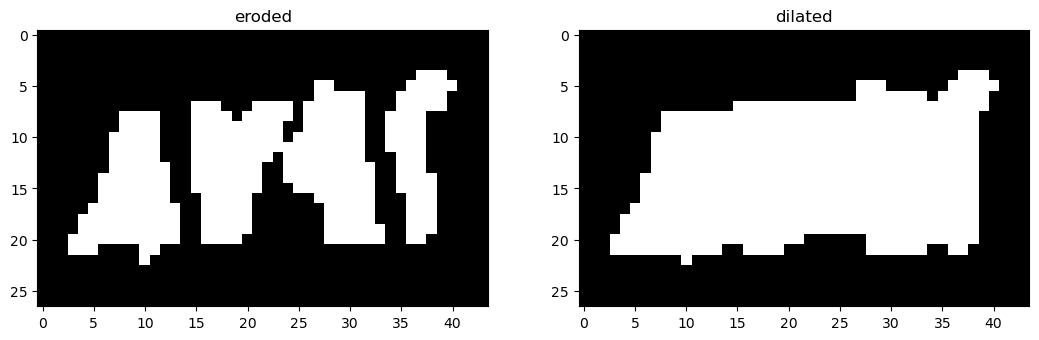

3.0 40.0 4.0 22.0


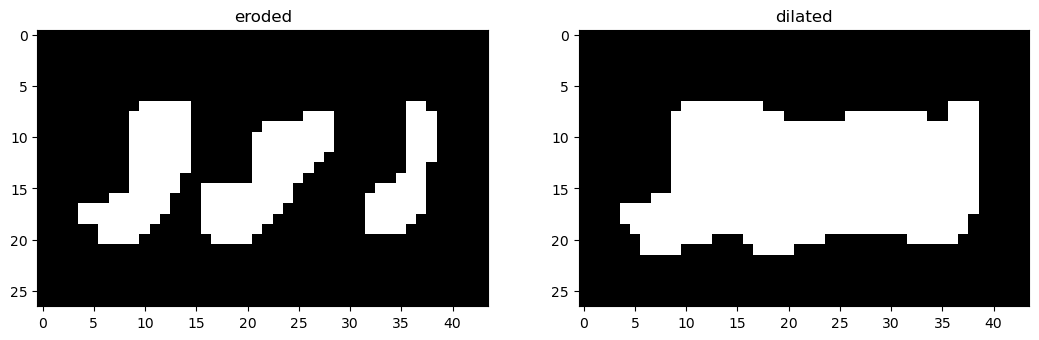

4.0 38.0 7.0 21.0


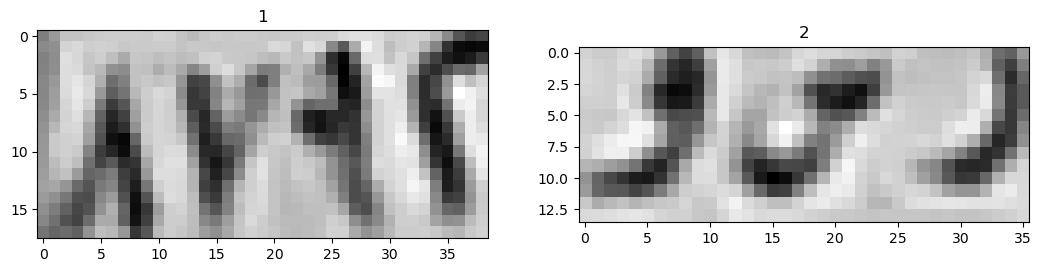

welcome to horizontal seg


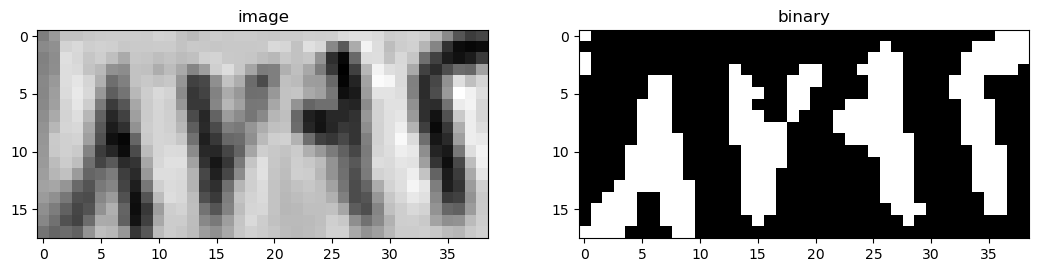

0 10
13 21
22 30
32 38


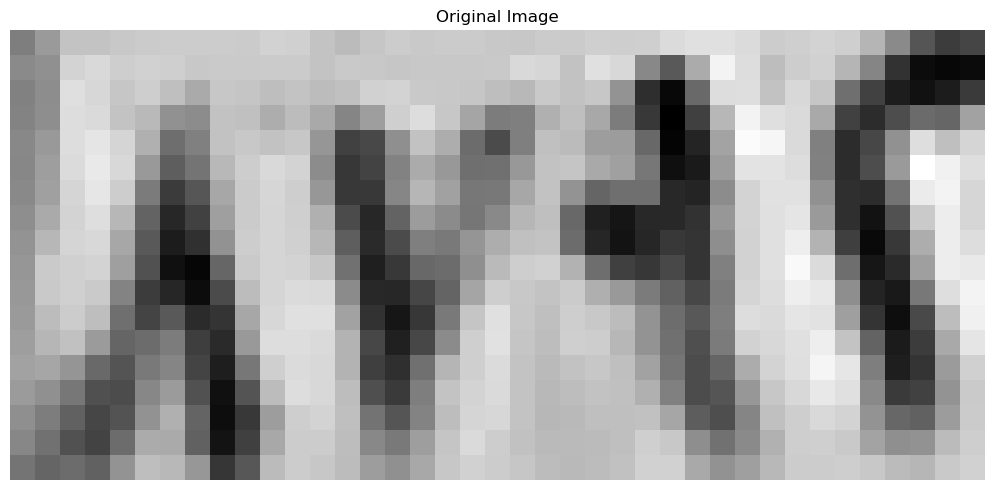

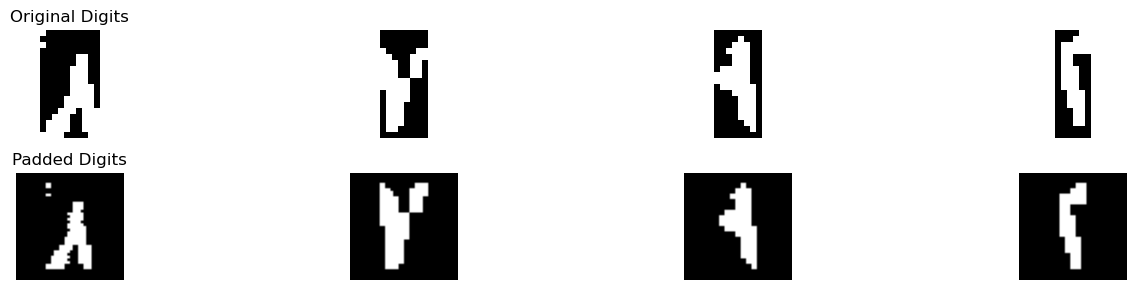

Best match: ٨
Full comparison results: {'١': 0.11764705882352941, '٢': 0.058823529411764705, '٣': 0.0, '٤': 0.3290441176470588, '٥': 0.19047619047619047, '٦': 0.30147058823529416, '٧': 0.1213235294117647, '٨': 0.5451388888888888, '٩': 0.17647058823529413}
Confidence :  0.10804738562091501
Best match: ٣
Full comparison results: {'١': 0.1111111111111111, '٢': 0.2777777777777778, '٣': 0.6493055555555556, '٤': 0.2222222222222222, '٥': 0.3630952380952381, '٦': 0.1423611111111111, '٧': 0.2777777777777778, '٨': 0.05555555555555555, '٩': 0.18055555555555555}
Confidence :  0.14310515873015875
Best match: ٨
Full comparison results: {'١': 0.21428571428571427, '٢': 0.2767857142857143, '٣': 0.058823529411764705, '٤': 0.28125, '٥': 0.22172619047619047, '٦': 0.5669642857142857, '٧': 0.23529411764705882, '٨': 0.7361111111111112, '٩': 0.48161764705882354}
Confidence :  0.08457341269841273
Best match: ٢
Full comparison results: {'١': 0.3, '٢': 1.21875, '٣': 0.38786764705882354, '٤': 0.6875, '٥': 0.31547

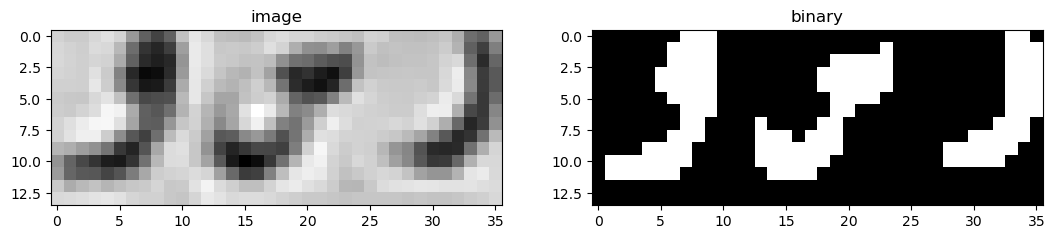

1 10
13 24
28 35


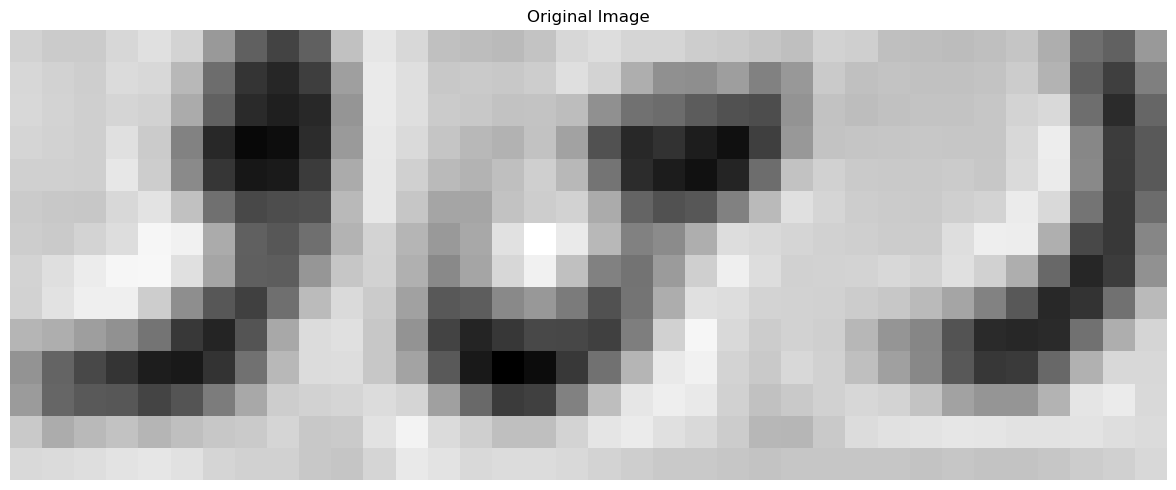

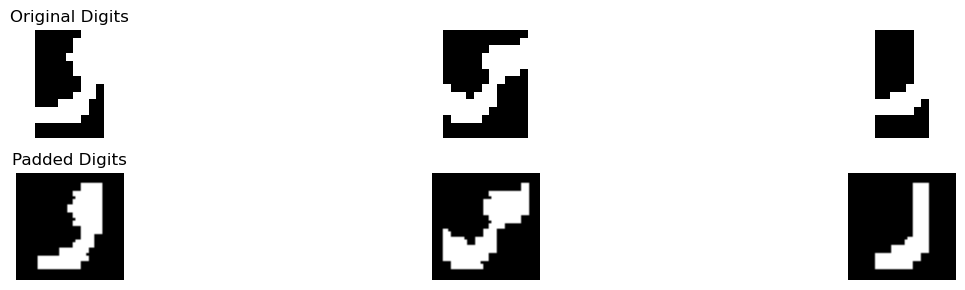

Best match: و
Full comparison results: {'أ': 0.0, 'ب': 0.0625, 'ج': 0.16666666666666666, 'د': 0.7083333333333334, 'ر': 0.6734913793103449, 'س': 0.6875, 'ص': 0.21875, 'ط': 0.4895833333333333, 'ع': 0.25, 'ف': 0.6944444444444444, 'ق': 0.26041666666666663, 'ك': 0.6145833333333333, 'ل': 0.4375, 'م': 0.03125, 'ن': 0.5416666666666667, 'ه': 0.75, 'و': 1.1458333333333335, 'ي': 1.0360576923076923}
Confidence :  0.054887820512820595
Best match: س
Full comparison results: {'أ': 0.0625, 'ب': 0.15625, 'ج': 0.1875, 'د': 0.4375, 'ر': 0.21875, 'س': 1.375, 'ص': 0.96875, 'ط': 0.21875, 'ع': 0.0625, 'ف': 0.375, 'ق': 0.21875, 'ك': 0.28125, 'ل': 0.15625, 'م': 0.125, 'ن': 0.25, 'ه': 0.75, 'و': 0.5, 'ي': 0.53125}
Confidence :  0.203125
Best match: د
Full comparison results: {'أ': 0.05, 'ب': 0.0625, 'ج': 0.15625, 'د': 1.0255681818181817, 'ر': 0.7079741379310345, 'س': 0.375, 'ص': 0.1875, 'ط': 0.6145833333333333, 'ع': 0.325, 'ف': 0.7060185185185185, 'ق': 0.375, 'ك': 0.6354166666666667, 'ل': 0.69375, 'م': 0.05, 'ن

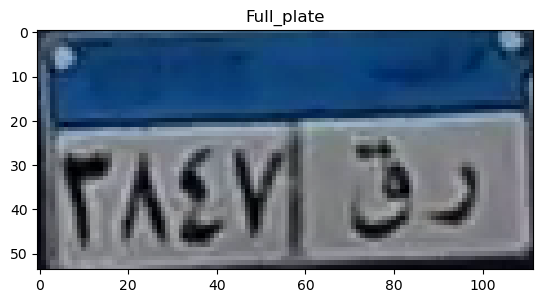

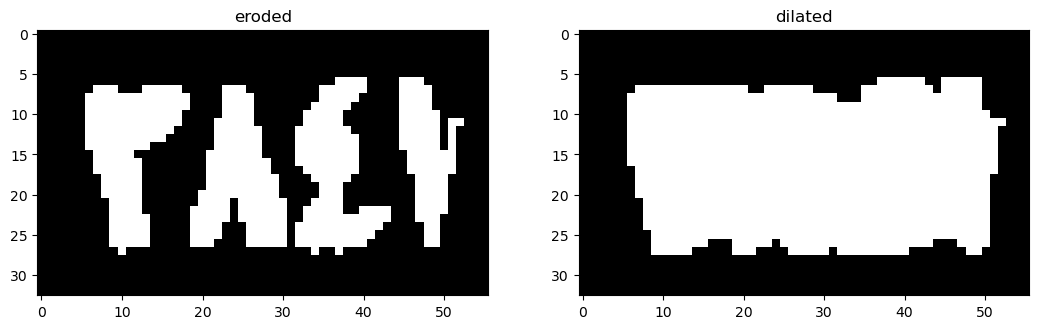

6.0 52.0 6.0 27.0


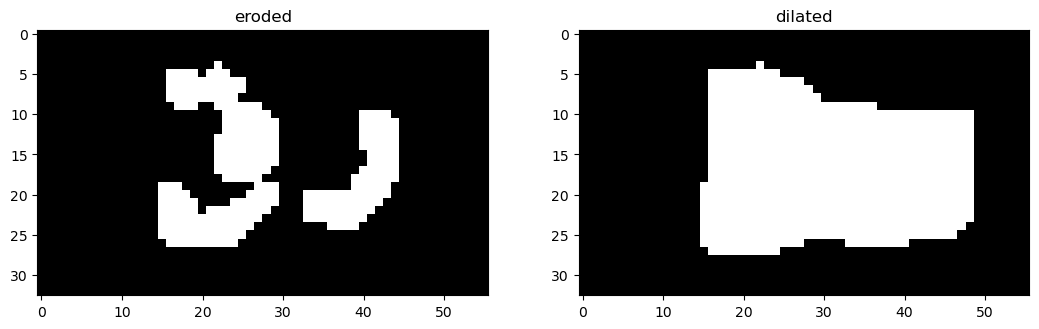

15.0 48.0 4.0 27.0


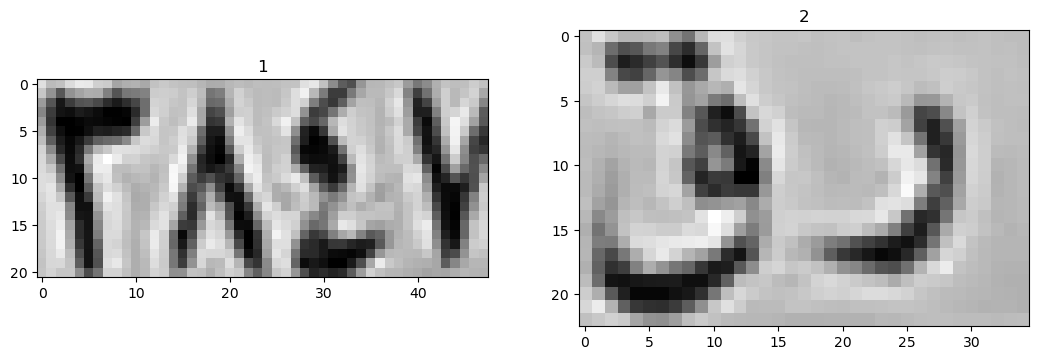

welcome to horizontal seg


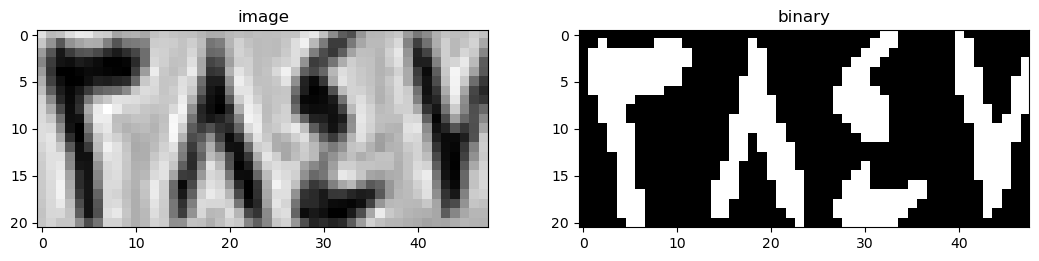

1 12
14 24
27 37
40 47


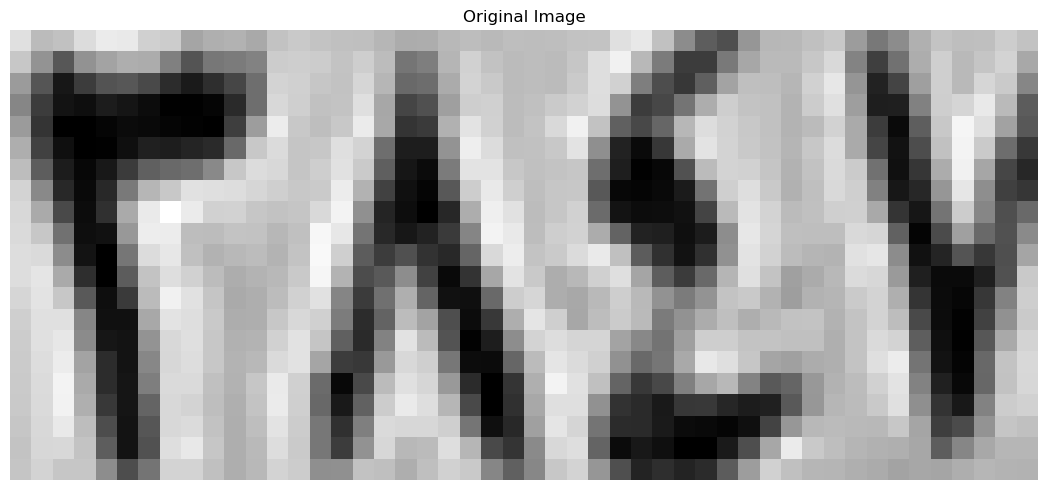

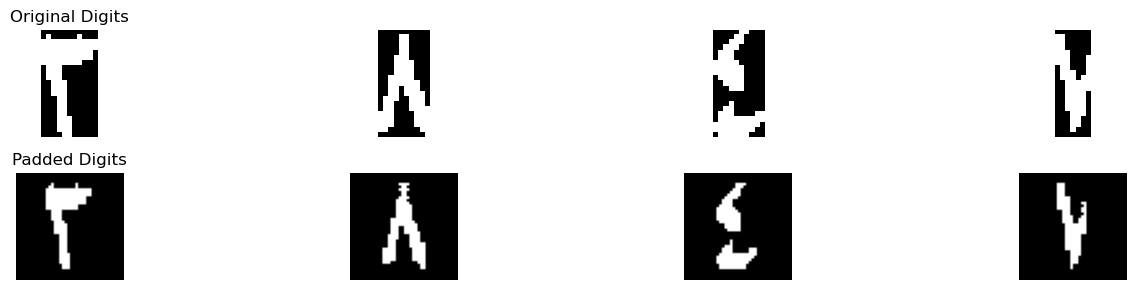

Best match: ٣
Full comparison results: {'١': 0.0, '٢': 0.6305147058823529, '٣': 1.2022058823529411, '٤': 0.3915441176470588, '٥': 0.3943452380952381, '٦': 0.2426470588235294, '٧': 0.35294117647058826, '٨': 0.1111111111111111, '٩': 0.23529411764705882}
Confidence :  0.2858455882352941
Best match: ٨
Full comparison results: {'١': 0.40625, '٢': 0.09375, '٣': 0.058823529411764705, '٤': 0.6875, '٥': 0.12648809523809523, '٦': 0.125, '٧': 0.17647058823529413, '٨': 1.6145833333333335, '٩': 0.6856617647058824}
Confidence :  0.46354166666666674
Best match: ٤
Full comparison results: {'١': 0.09791666666666667, '٢': 0.5208333333333333, '٣': 0.23897058823529413, '٤': 0.90625, '٥': 0.6473214285714286, '٦': 0.0, '٧': 0.0, '٨': 0.03125, '٩': 0.3602941176470588}
Confidence :  0.1294642857142857
Best match: ٢
Full comparison results: {'١': 0.09090909090909091, '٢': 0.8854166666666666, '٣': 0.2665441176470588, '٤': 0.1875, '٥': 0.0, '٦': 0.2857142857142857, '٧': 0.7904411764705883, '٨': 0.173611111111111

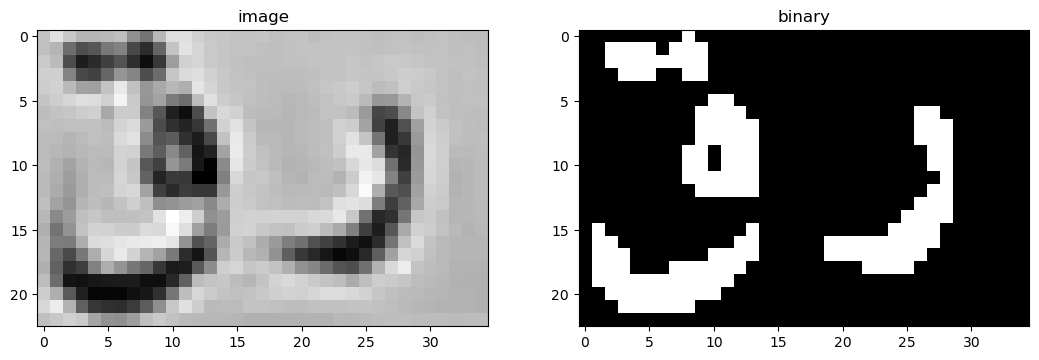

1 14
19 29


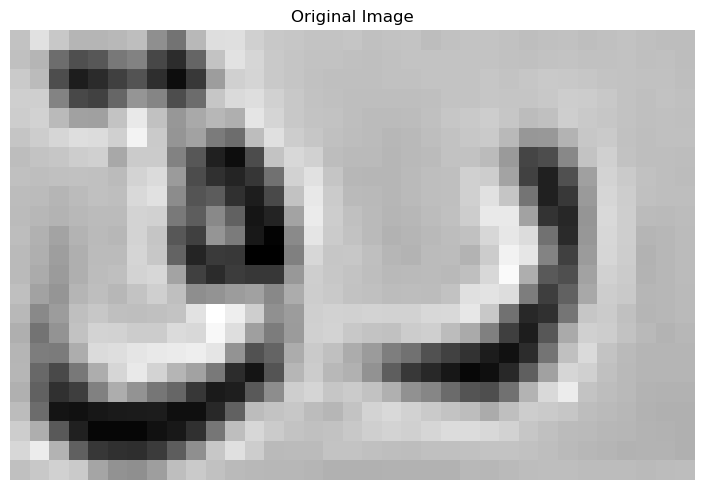

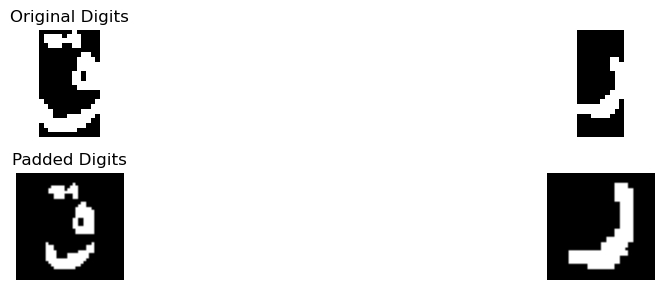

Best match: ق
Full comparison results: {'أ': 0.0, 'ب': 0.09375, 'ج': 0.7092391304347826, 'د': 1.0085227272727273, 'ر': 0.22844827586206895, 'س': 0.1875, 'ص': 0.1875, 'ط': 0.20833333333333331, 'ع': 0.3395585738539898, 'ف': 0.6435185185185185, 'ق': 1.5723684210526314, 'ك': 0.10416666666666666, 'ل': 0.5763888888888888, 'م': 0.0, 'ن': 0.8403225806451613, 'ه': 0.25, 'و': 0.4479166666666667, 'ي': 0.6706730769230769}
Confidence :  0.28192284688995206
Best match: ر
Full comparison results: {'أ': 0.041666666666666664, 'ب': 0.0625, 'ج': 0.15625, 'د': 0.8645833333333334, 'ر': 1.0301724137931034, 'س': 0.40625, 'ص': 0.375, 'ط': 0.7916666666666666, 'ع': 0.36458333333333337, 'ف': 0.9166666666666666, 'ق': 0.33333333333333337, 'ك': 0.7604166666666666, 'ل': 0.5625, 'م': 0.0, 'ن': 0.7395833333333334, 'ه': 0.46875, 'و': 0.9479166666666666, 'ي': 0.9735576923076923}
Confidence :  0.028307360742705567
[['٣', '٨', '٤', '٢'], ['ق', 'ر']]


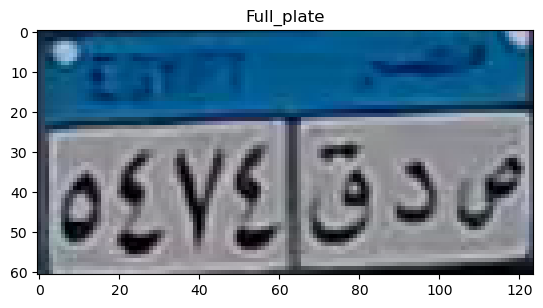

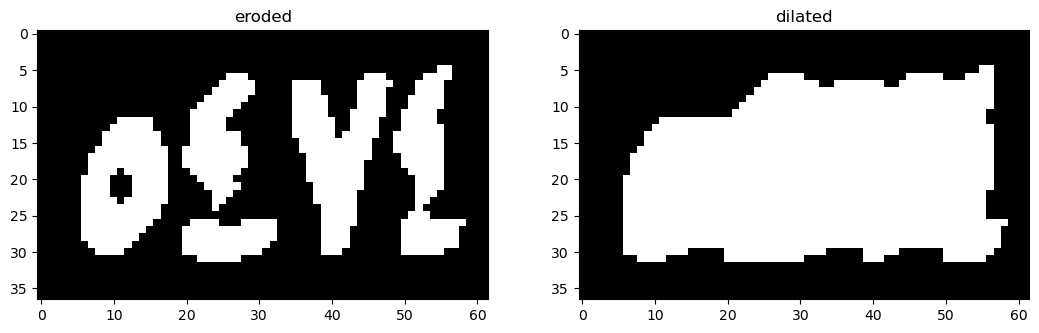

6.0 58.0 5.0 31.0


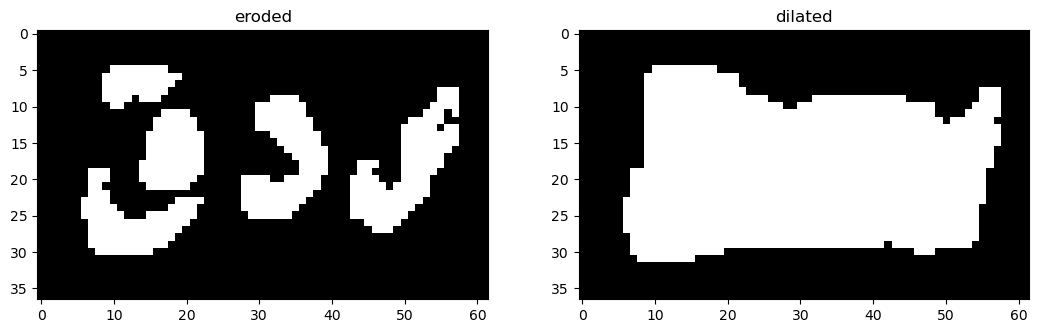

6.0 57.0 5.0 31.0


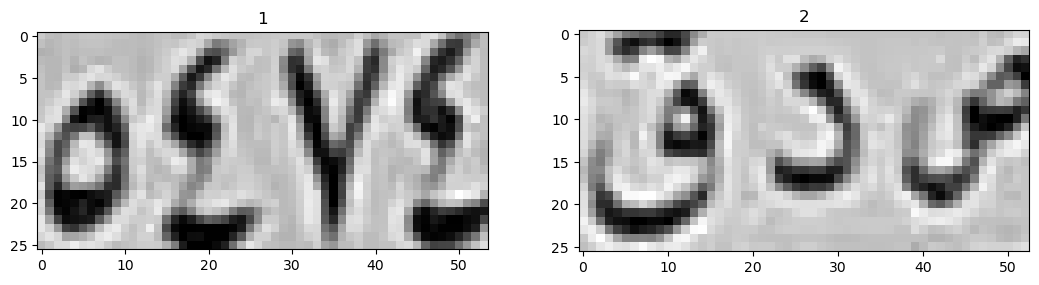

welcome to horizontal seg


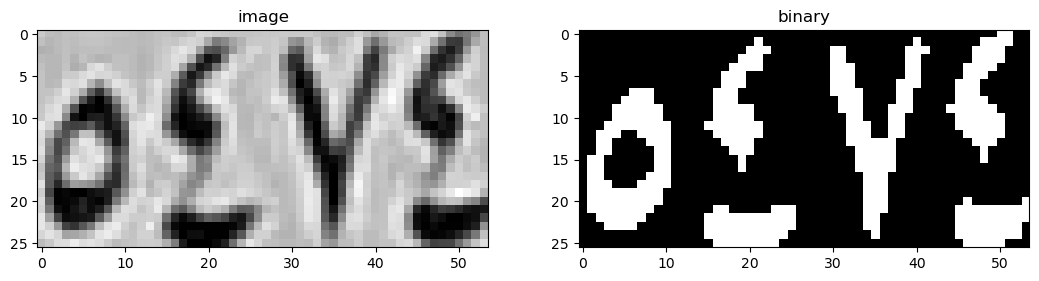

1 11
15 26
30 42
44 53


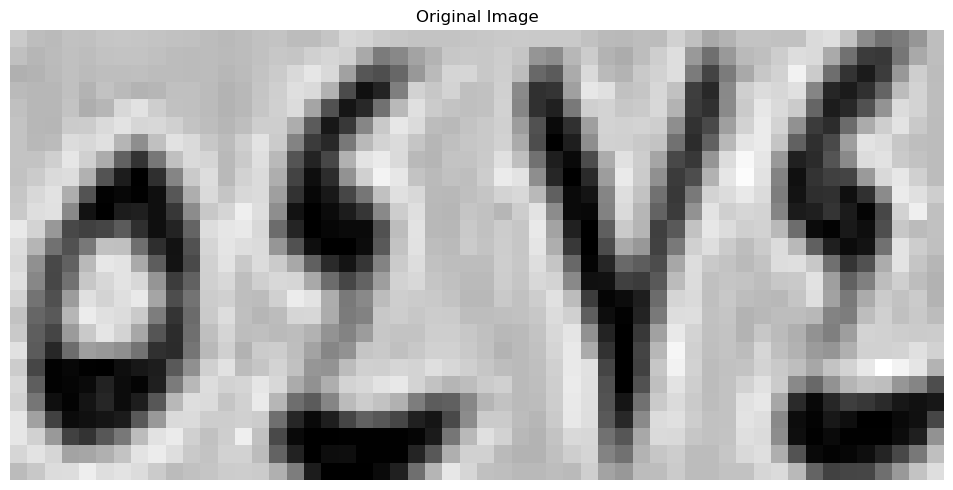

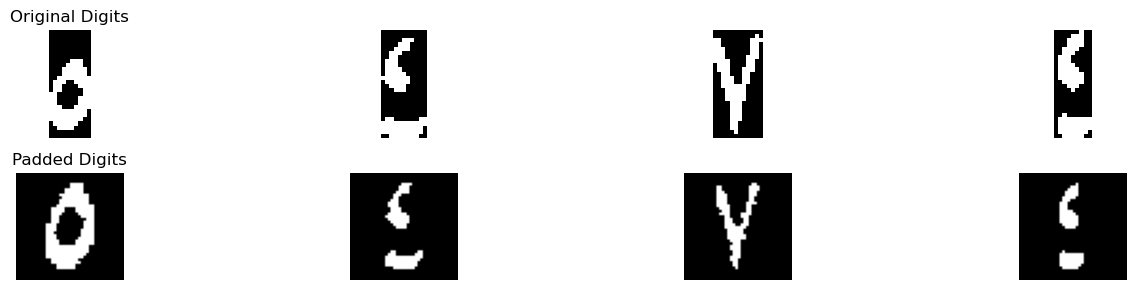

Best match: ٥
Full comparison results: {'١': 0.0, '٢': 0.22916666666666666, '٣': 0.14930555555555555, '٤': 0.6145833333333333, '٥': 1.3720238095238095, '٦': 0.3402777777777778, '٧': 0.05555555555555555, '٨': 0.1736111111111111, '٩': 0.0}
Confidence :  0.37872023809523814
Best match: ٤
Full comparison results: {'١': 0.07142857142857142, '٢': 0.625, '٣': 0.20772058823529413, '٤': 0.96875, '٥': 0.5208333333333333, '٦': 0.0, '٧': 0.058823529411764705, '٨': 0.08680555555555555, '٩': 0.2113970588235294}
Confidence :  0.171875
Best match: ٧
Full comparison results: {'١': 0.0, '٢': 0.65625, '٣': 0.5606617647058824, '٤': 0.09375, '٥': 0.09523809523809523, '٦': 0.0625, '٧': 0.9908088235294118, '٨': 0.1423611111111111, '٩': 0.23529411764705882}
Confidence :  0.1672794117647059
Best match: ٤
Full comparison results: {'١': 0.3958333333333333, '٢': 0.5104166666666667, '٣': 0.17647058823529413, '٤': 0.9375, '٥': 0.3333333333333333, '٦': 0.07142857142857142, '٧': 0.058823529411764705, '٨': 0.180555555

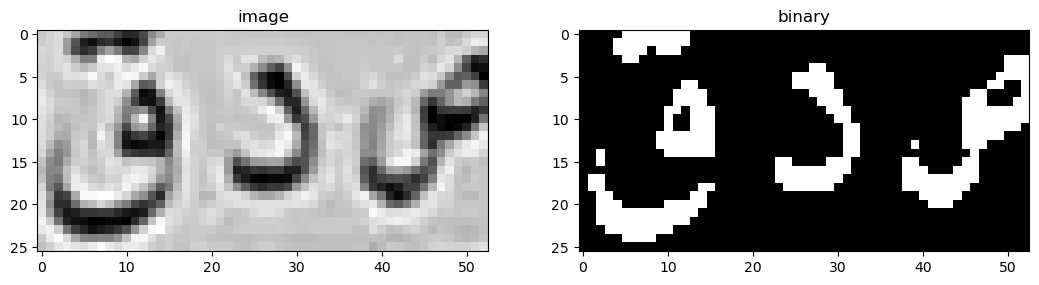

1 16
23 33
38 52


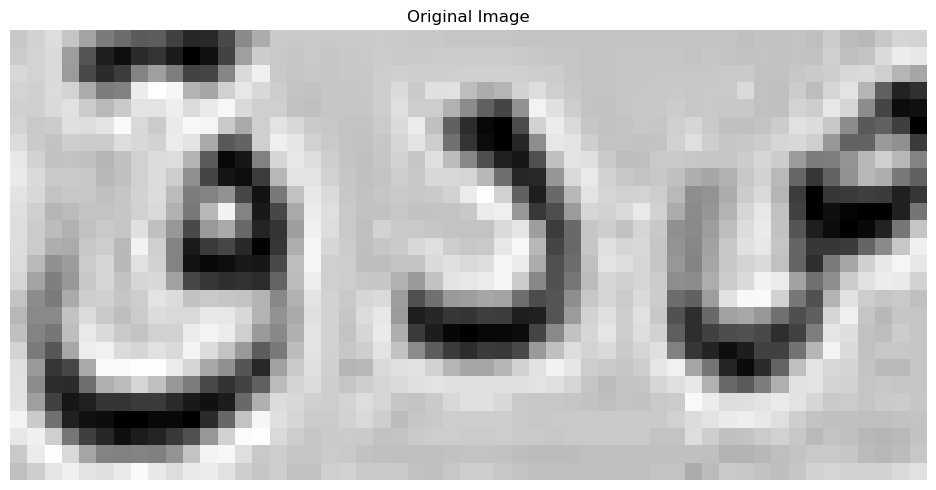

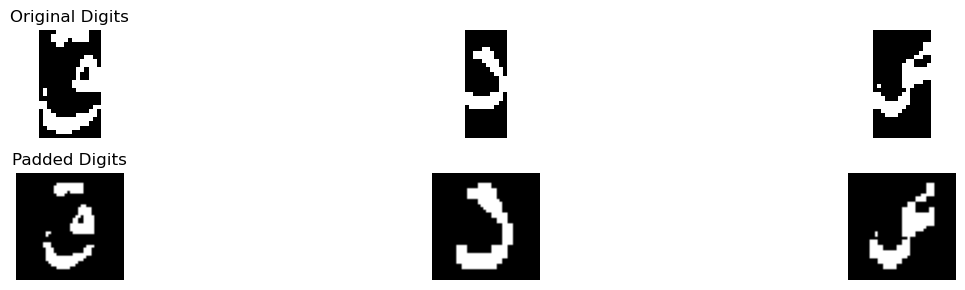

Best match: ق
Full comparison results: {'أ': 0.0, 'ب': 0.125, 'ج': 0.6657608695652174, 'د': 1.0255681818181817, 'ر': 0.3006465517241379, 'س': 0.21875, 'ص': 0.21875, 'ط': 0.3125, 'ع': 0.49745331069609505, 'ف': 0.5752314814814814, 'ق': 1.5602716468590832, 'ك': 0.3125, 'ل': 0.6611842105263157, 'م': 0.0625, 'ن': 0.8, 'ه': 0.1875, 'و': 0.53125, 'ي': 0.8653846153846154}
Confidence :  0.26735173252045075
Best match: د
Full comparison results: {'أ': 0.0, 'ب': 0.03125, 'ج': 0.6970108695652174, 'د': 1.3778409090909092, 'ر': 0.28771551724137934, 'س': 0.3125, 'ص': 0.125, 'ط': 0.6875, 'ع': 0.5372023809523809, 'ف': 0.7800925925925926, 'ق': 0.9791666666666666, 'ك': 0.5729166666666667, 'ل': 0.3794642857142857, 'م': 0.37797619047619047, 'ن': 0.8377976190476191, 'ه': 0.46875, 'و': 0.625, 'ي': 0.6490384615384616}
Confidence :  0.19933712121212127
Best match: ص
Full comparison results: {'أ': 0.08333333333333333, 'ب': 0.15625, 'ج': 0.15625, 'د': 0.5, 'ر': 0.30711206896551724, 'س': 0.75, 'ص': 0.84375, 'ط': 

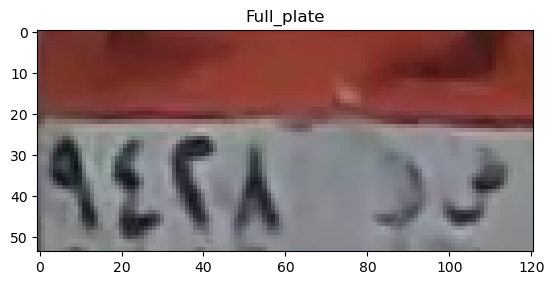

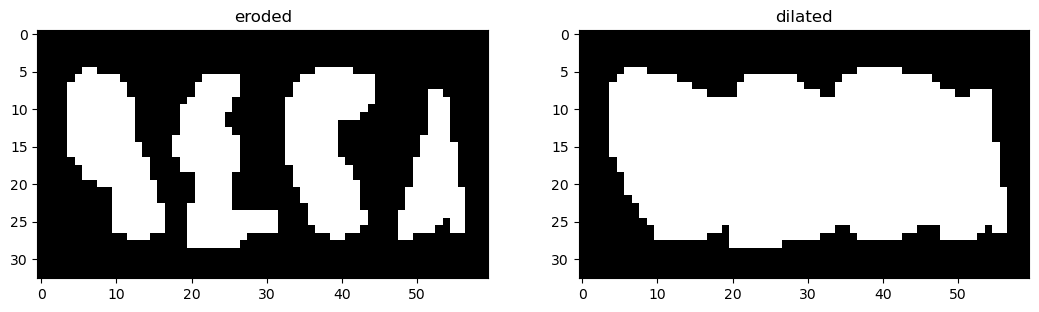

4.0 56.0 5.0 28.0


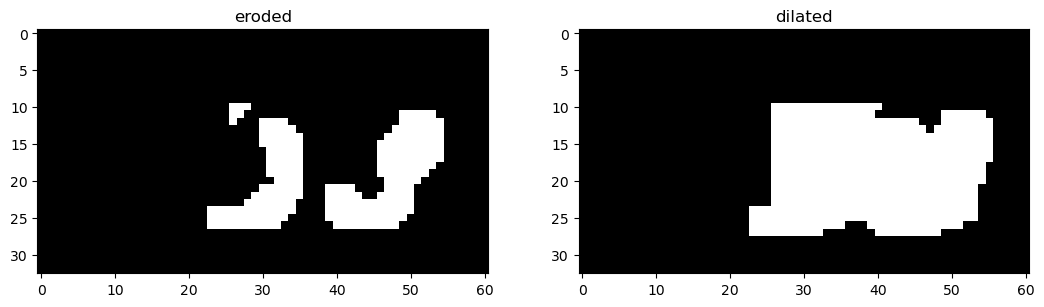

23.0 55.0 10.0 27.0


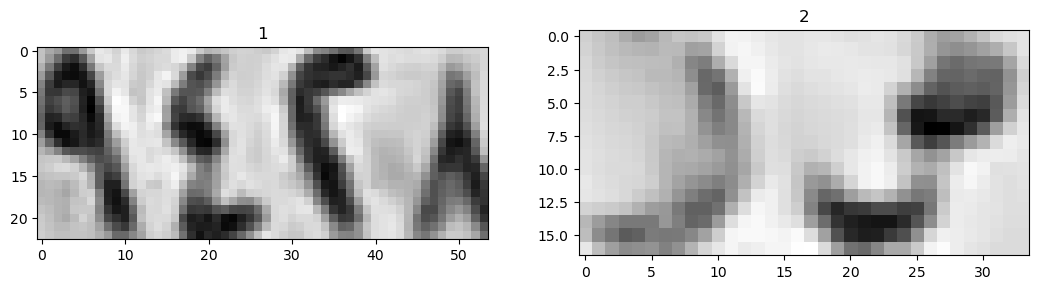

welcome to horizontal seg


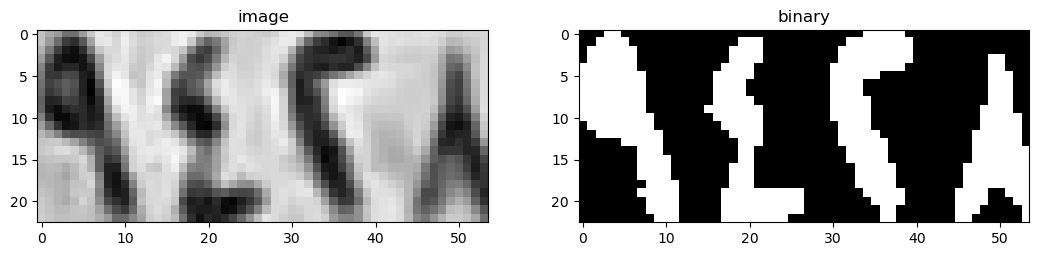

0 12
15 27
30 40
45 53


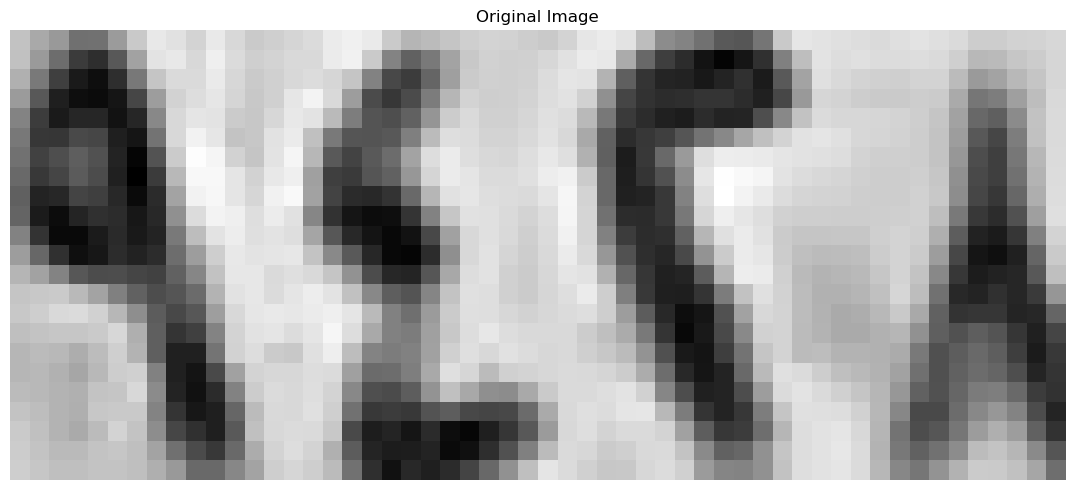

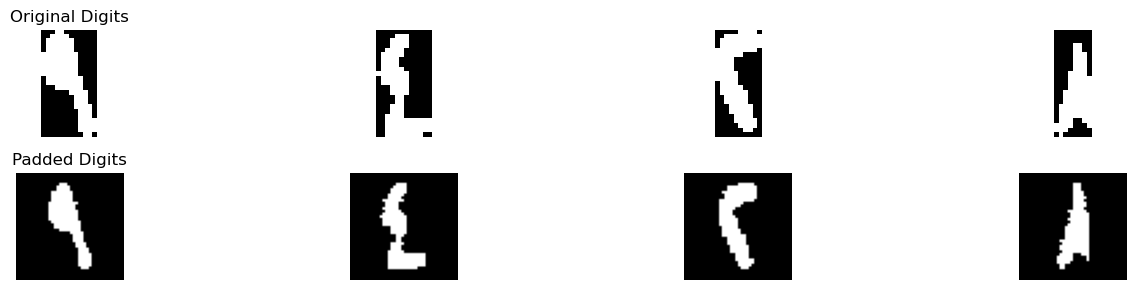

Best match: ٩
Full comparison results: {'١': 0.25, '٢': 0.3125, '٣': 0.2977941176470588, '٤': 0.25, '٥': 0.12648809523809523, '٦': 0.3125, '٧': 0.2665441176470588, '٨': 0.5868055555555556, '٩': 1.3198529411764706}
Confidence :  0.3665236928104575
Best match: ٤
Full comparison results: {'١': 0.0, '٢': 0.5716911764705883, '٣': 0.38786764705882354, '٤': 0.7867647058823529, '٥': 0.4895833333333333, '٦': 0.0, '٧': 0.03125, '٨': 0.1111111111111111, '٩': 0.4540441176470588}
Confidence :  0.1075367647058823
Best match: ٢
Full comparison results: {'١': 0.14285714285714285, '٢': 0.9241071428571429, '٣': 0.6893382352941176, '٤': 0.46875, '٥': 0.5208333333333333, '٦': 0.3705357142857143, '٧': 0.45036764705882354, '٨': 0.0, '٩': 0.1488970588235294}
Confidence :  0.11738445378151263
Best match: ٨
Full comparison results: {'١': 0.16666666666666666, '٢': 0.25, '٣': 0.058823529411764705, '٤': 0.375, '٥': 0.38095238095238093, '٦': 0.38839285714285715, '٧': 0.09375, '٨': 0.4270833333333333, '٩': 0.0}
Con

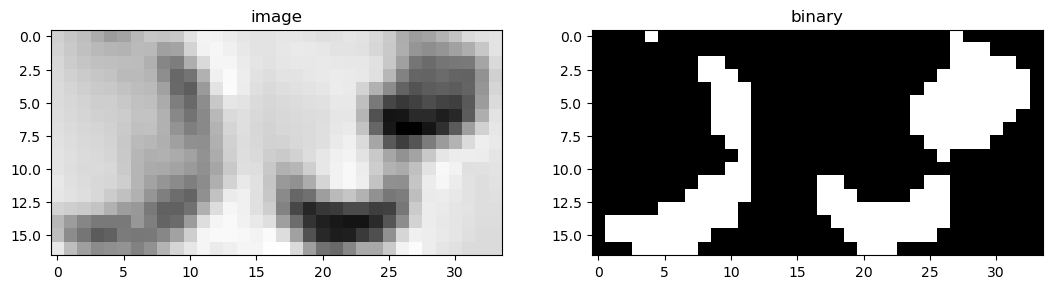

1 12
17 33


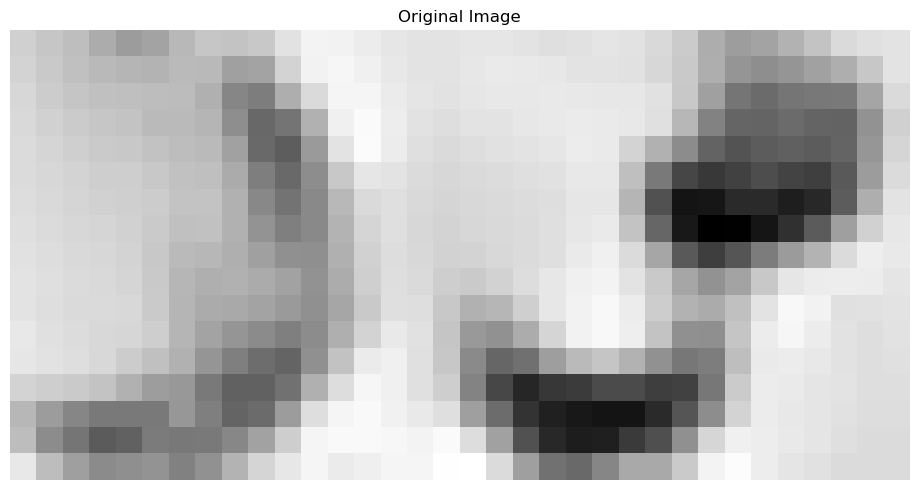

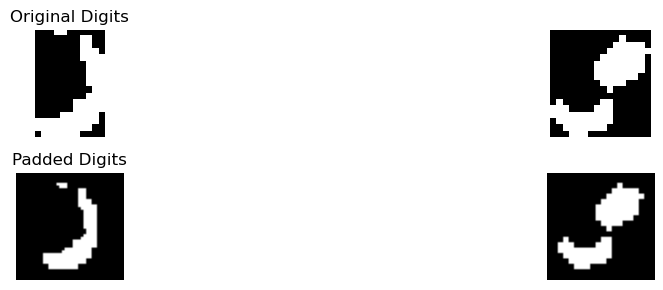

Best match: د
Full comparison results: {'أ': 0.05, 'ب': 0.09375, 'ج': 0.2866847826086957, 'د': 1.2528409090909092, 'ر': 0.7359913793103449, 'س': 0.34375, 'ص': 0.125, 'ط': 0.6458333333333333, 'ع': 0.50625, 'ف': 0.8796296296296297, 'ق': 0.625, 'ك': 0.5416666666666667, 'ل': 0.725, 'م': 0.0, 'ن': 0.8875, 'ه': 0.34375, 'و': 0.9375, 'ي': 0.8798076923076923}
Confidence :  0.15767045454545459
Best match: س
Full comparison results: {'أ': 0.0625, 'ب': 0.09375, 'ج': 0.125, 'د': 0.5, 'ر': 0.4375, 'س': 1.21875, 'ص': 1.03125, 'ط': 0.40625, 'ع': 0.15625, 'ف': 0.34375, 'ق': 0.21875, 'ك': 0.375, 'ل': 0.3125, 'م': 0.09375, 'ن': 0.3125, 'ه': 0.59375, 'و': 0.65625, 'ي': 0.65625}
Confidence :  0.09375
[['٩', '٤', '٢', '٨'], ['د', 'س']]


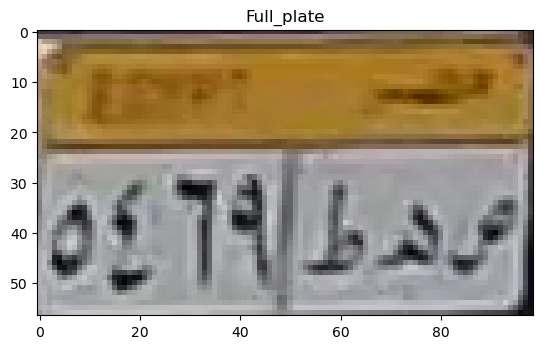

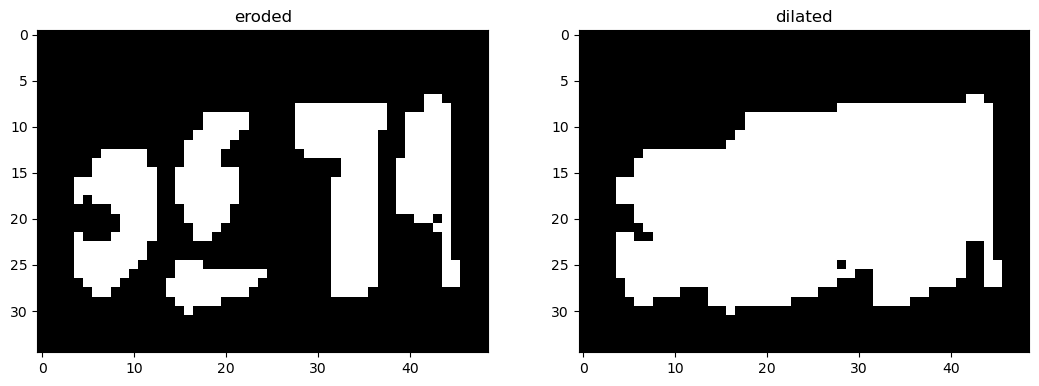

4.0 44.0 7.0 30.0


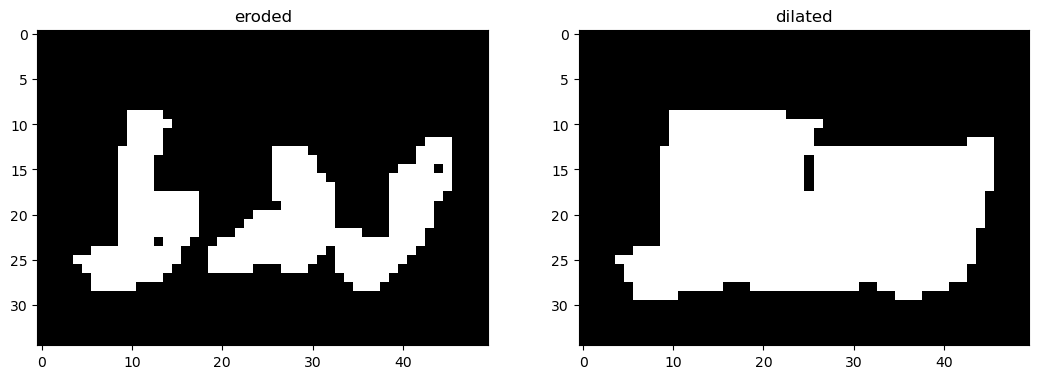

4.0 45.0 9.0 29.0


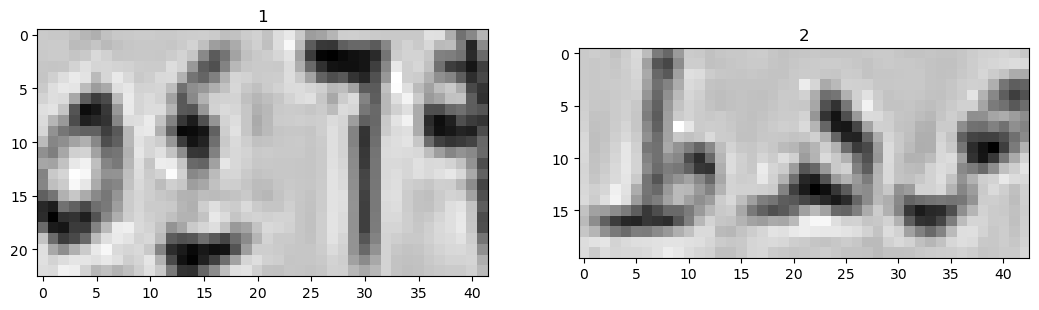

welcome to horizontal seg


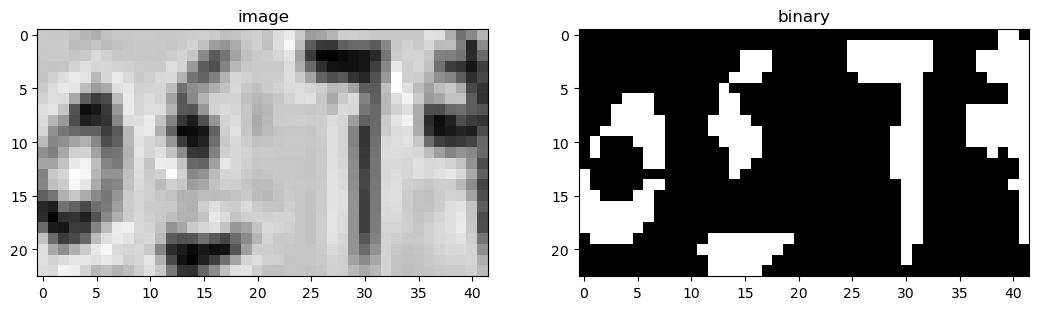

0 8
11 20
25 33
36 41


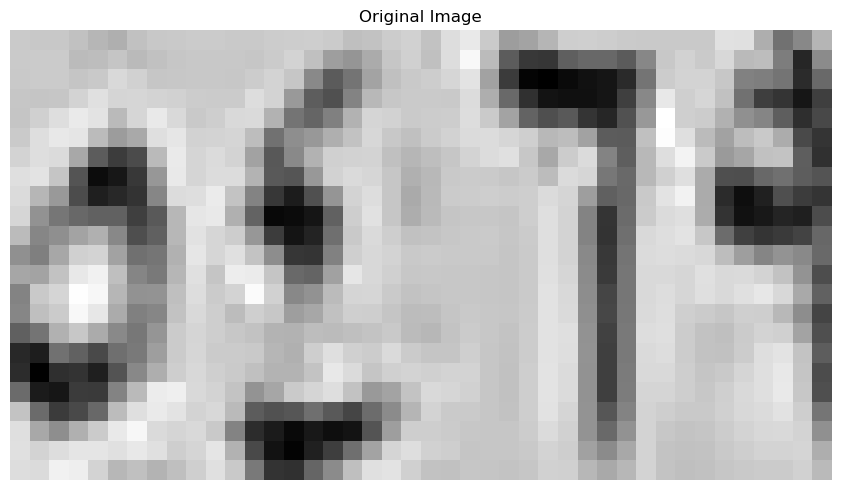

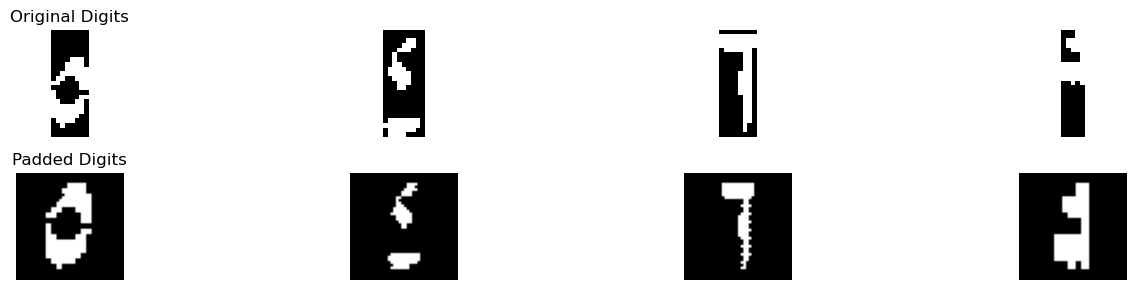

Best match: ٥
Full comparison results: {'١': 0.0, '٢': 0.30147058823529416, '٣': 0.1213235294117647, '٤': 0.3915441176470588, '٥': 1.3407738095238095, '٦': 0.32536764705882354, '٧': 0.11764705882352941, '٨': 0.1423611111111111, '٩': 0.0}
Confidence :  0.47461484593837533
Best match: ٤
Full comparison results: {'١': 0.375, '٢': 0.16666666666666666, '٣': 0.058823529411764705, '٤': 1.125, '٥': 0.3005952380952381, '٦': 0.07142857142857142, '٧': 0.0, '٨': 0.32291666666666663, '٩': 0.20772058823529413}
Confidence :  0.375
Best match: ٦
Full comparison results: {'١': 0.25, '٢': 0.15625, '٣': 0.3915441176470588, '٤': 0.125, '٥': 0.26785714285714285, '٦': 1.3080357142857144, '٧': 0.15257352941176472, '٨': 0.2534722222222222, '٩': 0.20772058823529413}
Confidence :  0.45824579831932777
Best match: ٥
Full comparison results: {'١': 0.07692307692307693, '٢': 0.15384615384615385, '٣': 0.2113970588235294, '٤': 0.5625, '٥': 0.7261904761904762, '٦': 0.41964285714285715, '٧': 0.058823529411764705, '٨': 0

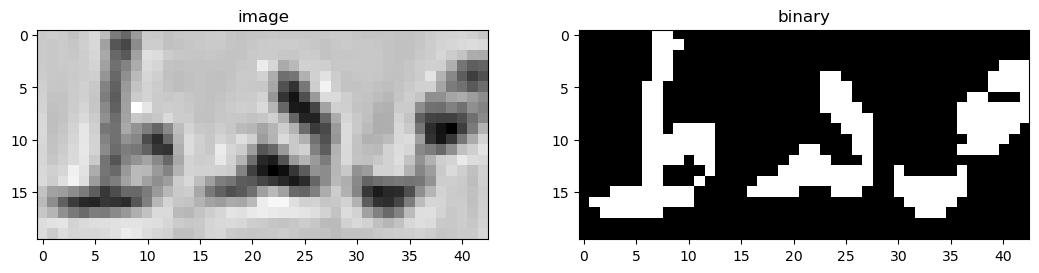

1 13
16 28
30 42


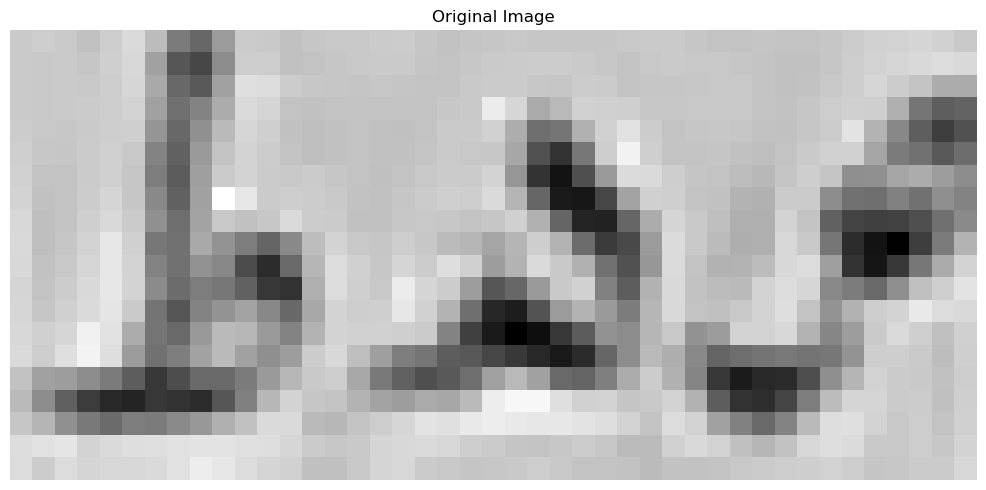

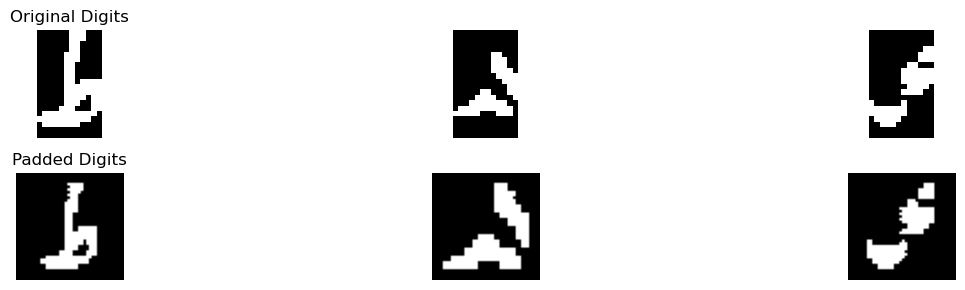

Best match: ط
Full comparison results: {'أ': 0.26785714285714285, 'ب': 0.03125, 'ج': 0.3858695652173913, 'د': 0.625, 'ر': 0.5043103448275862, 'س': 0.25, 'ص': 0.0625, 'ط': 1.1458333333333335, 'ع': 0.15625, 'ف': 0.5208333333333333, 'ق': 0.5684523809523809, 'ك': 0.36458333333333337, 'ل': 0.28422619047619047, 'م': 0.07886904761904762, 'ن': 0.5997023809523809, 'ه': 0.1875, 'و': 0.5, 'ي': 0.6105769230769231}
Confidence :  0.26041666666666674
Best match: ه
Full comparison results: {'أ': 0.0625, 'ب': 0.0, 'ج': 0.125, 'د': 0.4375, 'ر': 0.4375, 'س': 0.4375, 'ص': 0.25, 'ط': 0.375, 'ع': 0.0625, 'ف': 0.5625, 'ق': 0.09375, 'ك': 0.375, 'ل': 0.15625, 'م': 0.125, 'ن': 0.25, 'ه': 1.21875, 'و': 0.53125, 'ي': 0.46875}
Confidence :  0.328125
Best match: ي
Full comparison results: {'أ': 0.04, 'ب': 0.09375, 'ج': 0.15125, 'د': 0.53375, 'ر': 0.2661637931034483, 'س': 1.0, 'ص': 1.09375, 'ط': 0.28, 'ع': 0.08, 'ف': 0.4386574074074074, 'ق': 0.3425, 'ك': 0.55625, 'ل': 0.27125, 'م': 0.08, 'ن': 0.28, 'ه': 0.53125, 'و'

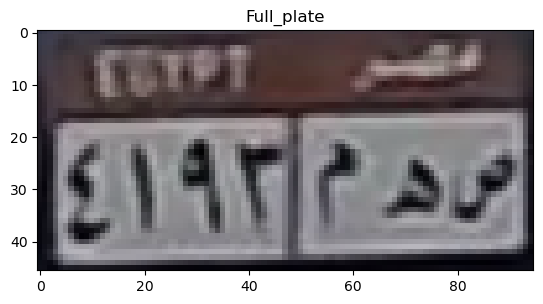

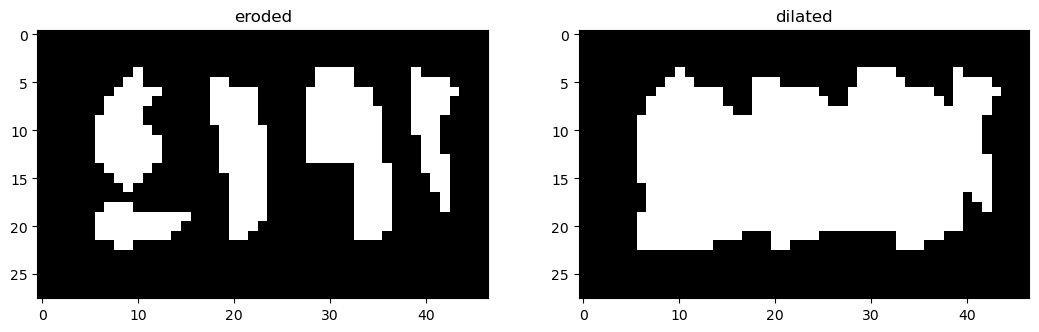

6.0 43.0 4.0 22.0


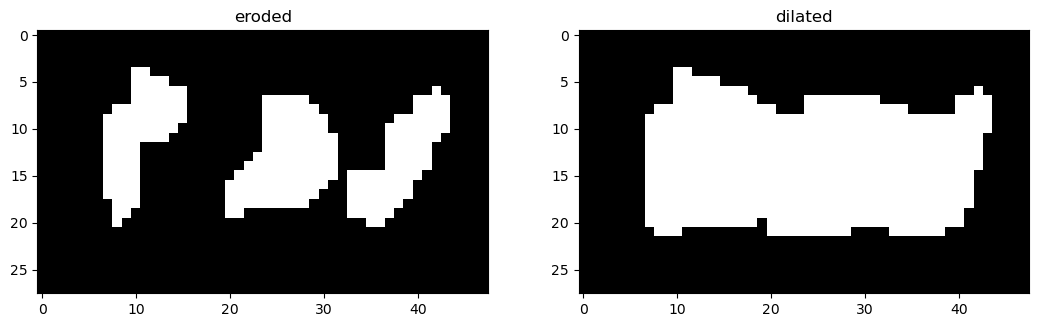

7.0 43.0 4.0 21.0


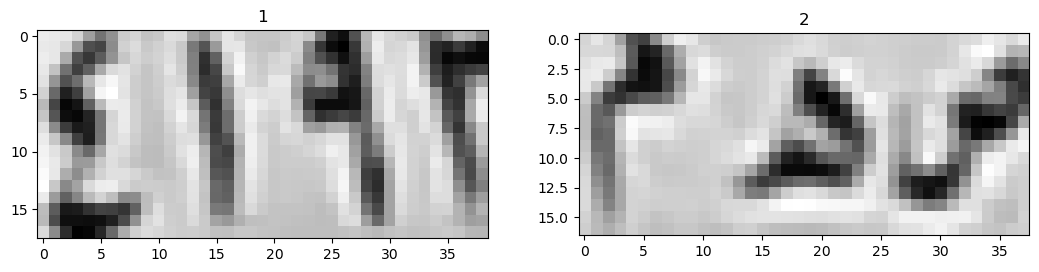

welcome to horizontal seg


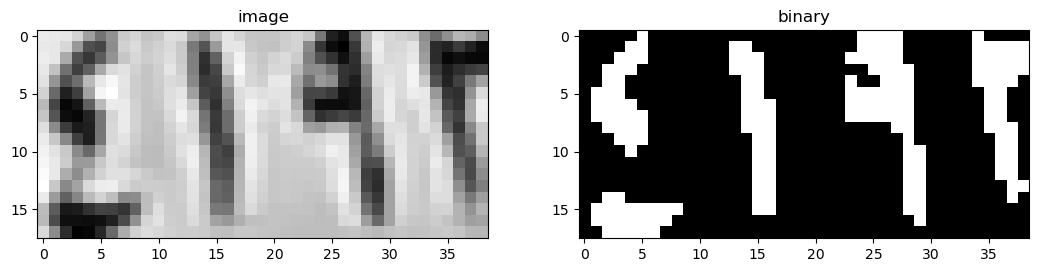

1 9
13 17
23 30
34 38


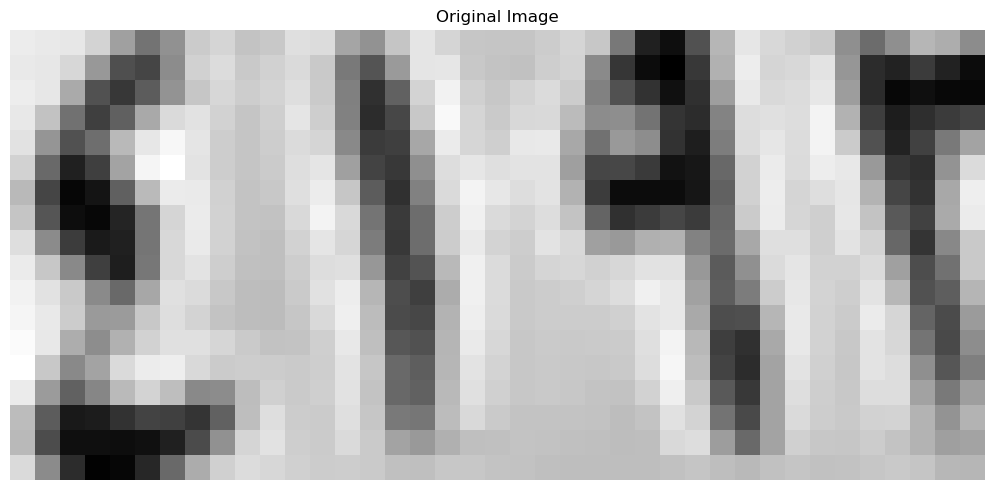

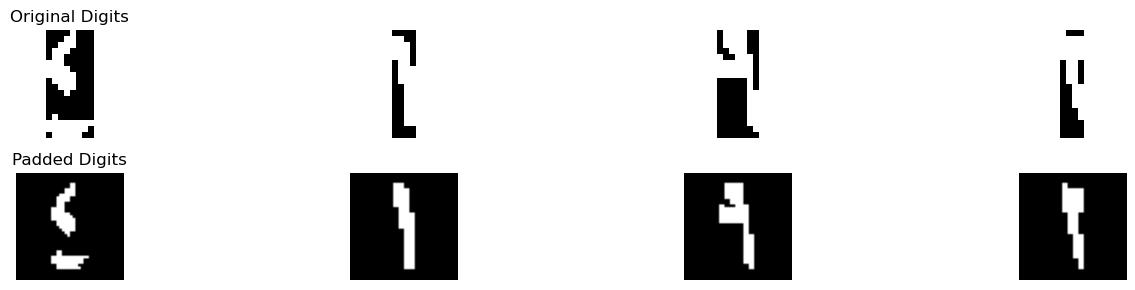

Best match: ٤
Full comparison results: {'١': 0.10267857142857142, '٢': 0.59375, '٣': 0.20772058823529413, '٤': 0.90625, '٥': 0.4270833333333333, '٦': 0.07142857142857142, '٧': 0.0625, '٨': 0.03125, '٩': 0.15257352941176472}
Confidence :  0.15625
Best match: ١
Full comparison results: {'١': 0.9375, '٢': 0.19791666666666666, '٣': 0.0, '٤': 0.5, '٥': 0.2857142857142857, '٦': 0.5446428571428572, '٧': 0.5827205882352942, '٨': 0.5590277777777778, '٩': 0.35661764705882354}
Confidence :  0.17738970588235292
Best match: ٩
Full comparison results: {'١': 0.3701923076923077, '٢': 0.3701923076923077, '٣': 0.35294117647058826, '٤': 0.25, '٥': 0.23809523809523808, '٦': 0.5357142857142857, '٧': 0.29411764705882354, '٨': 0.5381944444444444, '٩': 0.8970588235294118}
Confidence :  0.1794321895424837
Best match: ١
Full comparison results: {'١': 0.75, '٢': 0.4270833333333333, '٣': 0.0625, '٤': 0.4375, '٥': 0.28422619047619047, '٦': 0.5133928571428572, '٧': 0.3400735294117647, '٨': 0.2847222222222222, '٩': 

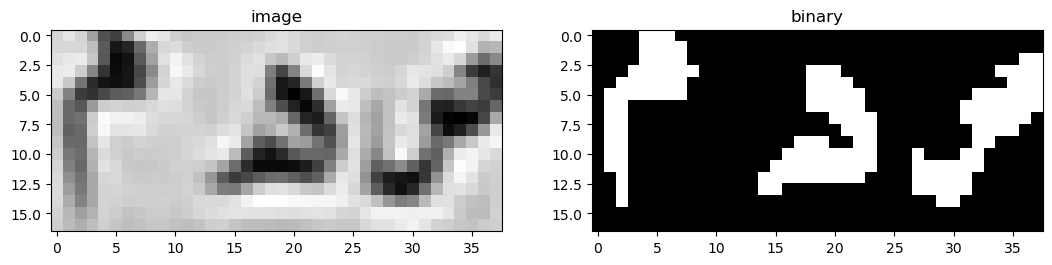

1 9
14 24
27 37


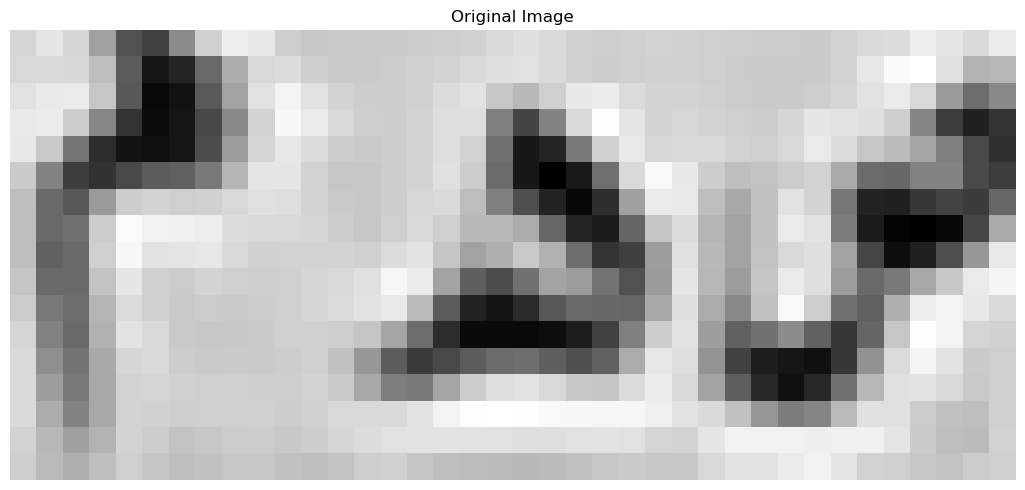

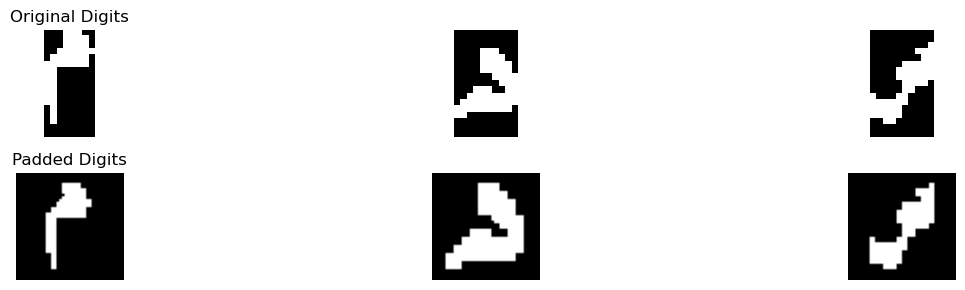

Best match: م
Full comparison results: {'أ': 0.0, 'ب': 0.0625, 'ج': 0.043478260869565216, 'د': 0.5511363636363636, 'ر': 0.0, 'س': 0.15625, 'ص': 0.03125, 'ط': 0.0, 'ع': 0.3256578947368421, 'ف': 0.1111111111111111, 'ق': 0.10526315789473684, 'ك': 0.0, 'ل': 0.058823529411764705, 'م': 0.9908088235294118, 'ن': 0.14375, 'ه': 0.28125, 'و': 0.041666666666666664, 'ي': 0.0}
Confidence :  0.21983622994652408
Best match: ه
Full comparison results: {'أ': 0.10344827586206896, 'ب': 0.0, 'ج': 0.3006465517241379, 'د': 0.6734913793103449, 'ر': 0.2693965517241379, 'س': 0.40625, 'ص': 0.21875, 'ط': 0.2661637931034483, 'ع': 0.09698275862068965, 'ف': 0.5355603448275862, 'ق': 0.2413793103448276, 'ك': 0.16594827586206895, 'ل': 0.10344827586206896, 'م': 0.4536637931034483, 'ن': 0.2349137931034483, 'ه': 1.375, 'و': 0.4698275862068966, 'ي': 0.23168103448275862}
Confidence :  0.35075431034482757
Best match: ص
Full comparison results: {'أ': 0.08333333333333333, 'ب': 0.0625, 'ج': 0.16666666666666666, 'د': 0.53125, 'ر

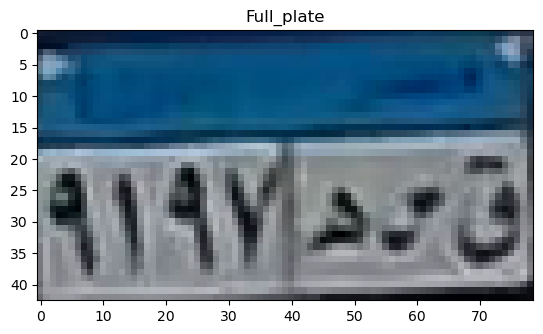

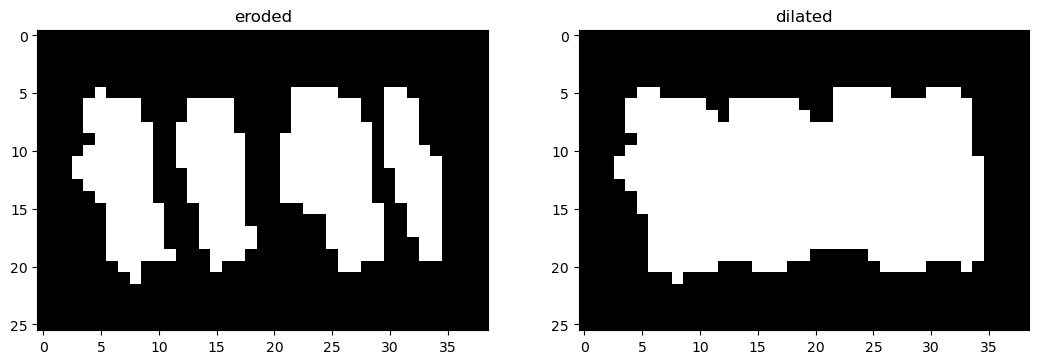

3.0 34.0 5.0 21.0


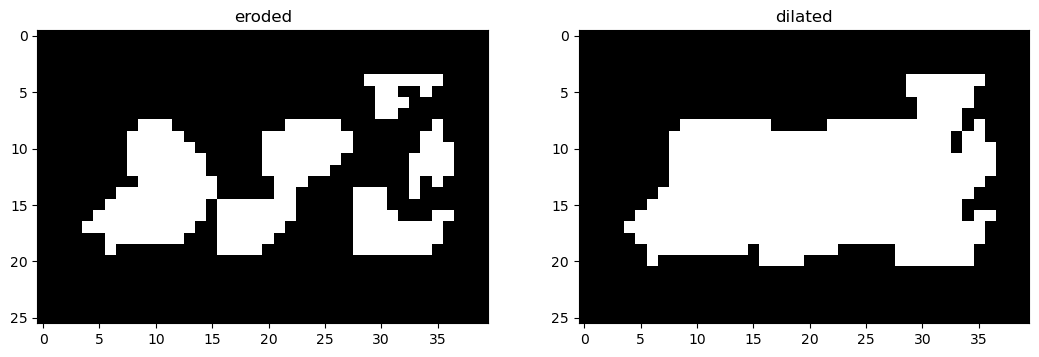

4.0 36.0 4.0 20.0


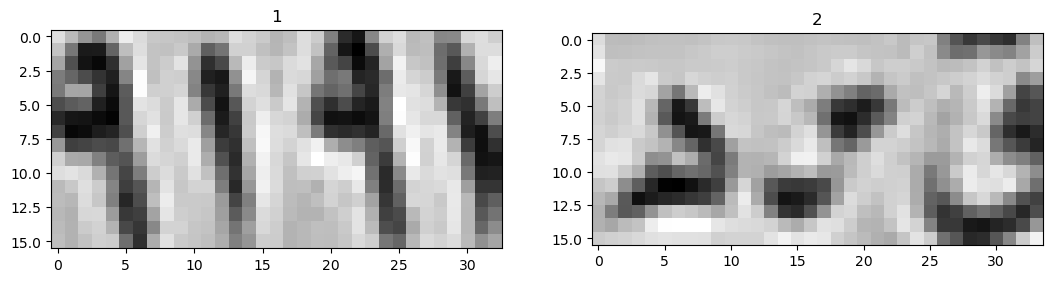

welcome to horizontal seg


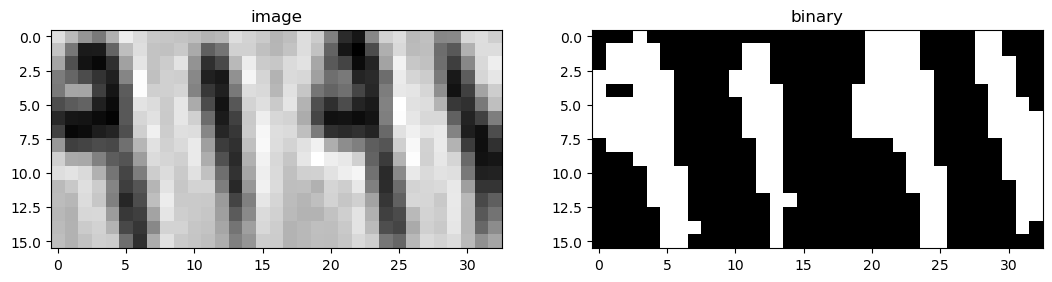

0 8
10 15
19 26
28 32


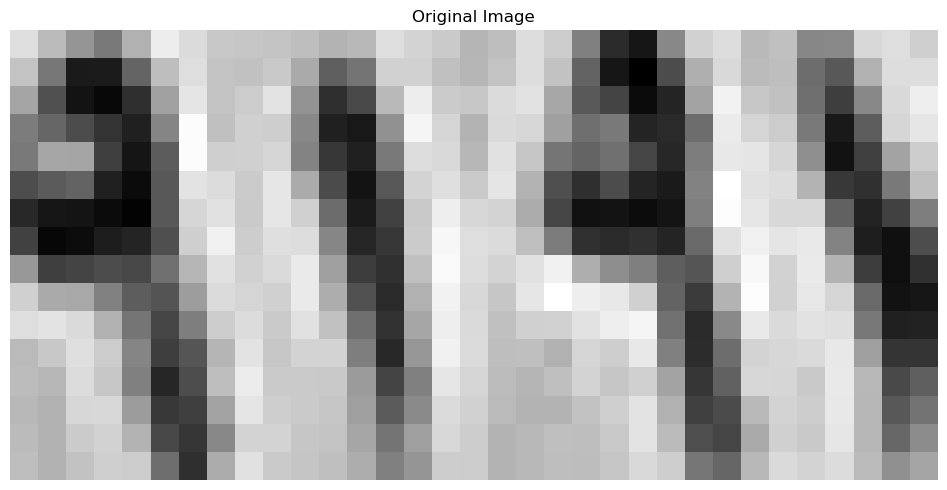

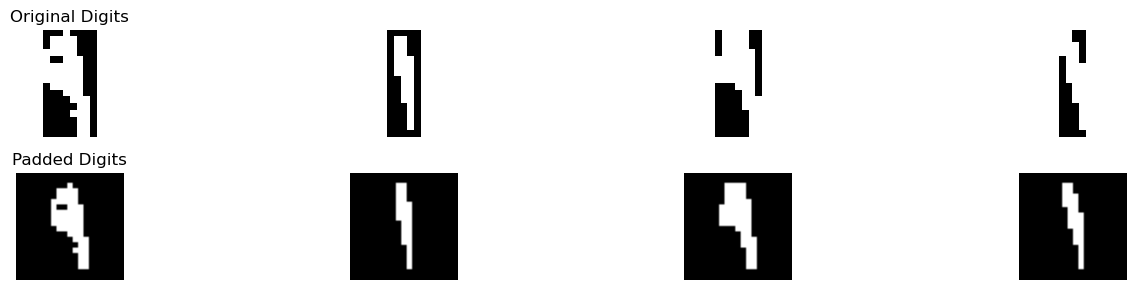

Best match: ٩
Full comparison results: {'١': 0.2857142857142857, '٢': 0.48214285714285715, '٣': 0.2977941176470588, '٤': 0.25, '٥': 0.31547619047619047, '٦': 0.5044642857142857, '٧': 0.27022058823529416, '٨': 0.6180555555555556, '٩': 0.9283088235294118}
Confidence :  0.1551266339869281
Best match: ١
Full comparison results: {'١': 1.1458333333333335, '٢': 0.19791666666666666, '٣': 0.058823529411764705, '٤': 0.46875, '٥': 0.14285714285714285, '٦': 0.26785714285714285, '٧': 0.49264705882352944, '٨': 0.5277777777777778, '٩': 0.3290441176470588}
Confidence :  0.30902777777777785
Best match: ٩
Full comparison results: {'١': 0.35714285714285715, '٢': 0.48214285714285715, '٣': 0.1801470588235294, '٤': 0.3125, '٥': 0.5684523809523809, '٦': 0.5669642857142857, '٧': 0.11764705882352941, '٨': 0.59375, '٩': 0.8694852941176471}
Confidence :  0.13786764705882354
Best match: ١
Full comparison results: {'١': 0.9375, '٢': 0.08333333333333333, '٣': 0.0, '٤': 0.4375, '٥': 0.19047619047619047, '٦': 0.51339

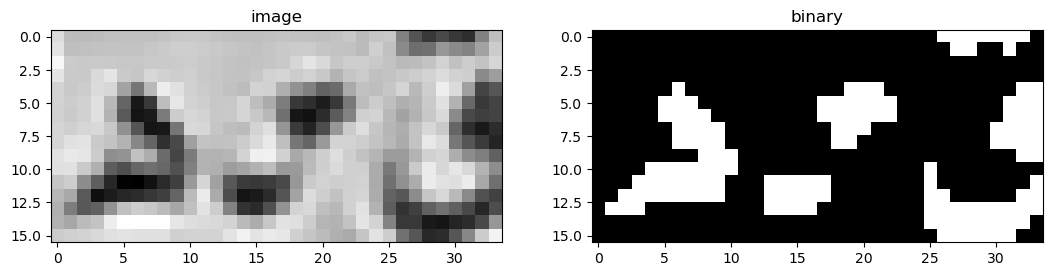

1 11
13 23
25 33


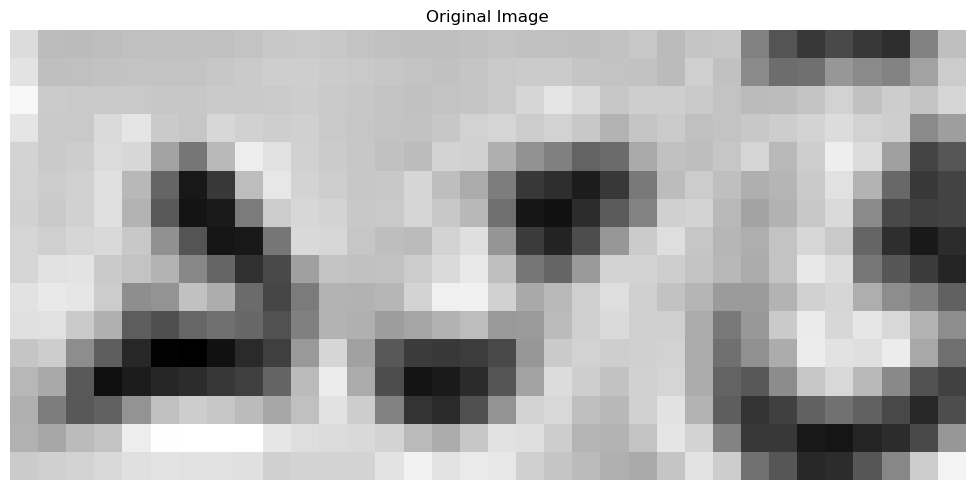

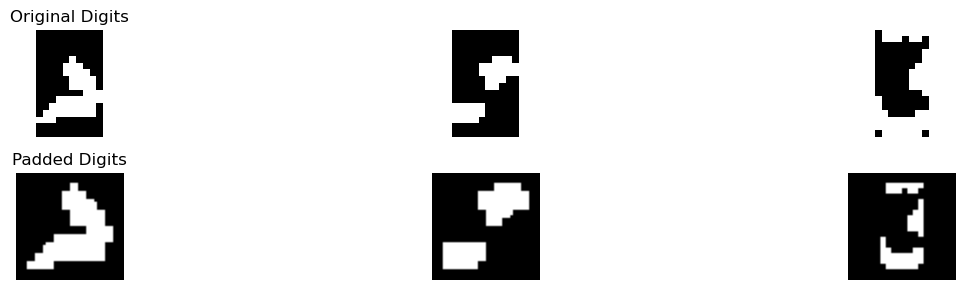

Best match: ه
Full comparison results: {'أ': 0.0625, 'ب': 0.0, 'ج': 0.28125, 'د': 0.65625, 'ر': 0.21875, 'س': 0.59375, 'ص': 0.375, 'ط': 0.375, 'ع': 0.125, 'ف': 0.59375, 'ق': 0.28125, 'ك': 0.28125, 'ل': 0.09375, 'م': 0.25, 'ن': 0.25, 'ه': 1.5625, 'و': 0.46875, 'ي': 0.3125}
Confidence :  0.453125
Best match: س
Full comparison results: {'أ': 0.0, 'ب': 0.125, 'ج': 0.1875, 'د': 0.4375, 'ر': 0.125, 'س': 1.03125, 'ص': 0.875, 'ط': 0.1875, 'ع': 0.0625, 'ف': 0.40625, 'ق': 0.15625, 'ك': 0.3125, 'ل': 0.1875, 'م': 0.28125, 'ن': 0.25, 'ه': 0.5, 'و': 0.5, 'ي': 0.46875}
Confidence :  0.078125
Best match: ل
Full comparison results: {'أ': 0.0, 'ب': 0.09375, 'ج': 0.5665760869565217, 'د': 0.8096590909090909, 'ر': 0.3318965517241379, 'س': 0.15625, 'ص': 0.0625, 'ط': 0.39583333333333337, 'ع': 0.5773026315789473, 'ف': 0.6377314814814814, 'ق': 0.819078947368421, 'ك': 0.23958333333333331, 'ل': 0.84375, 'م': 0.125, 'ن': 0.7435483870967743, 'ه': 0.21875, 'و': 0.6770833333333333, 'ي': 0.5793269230769231}
Confidenc

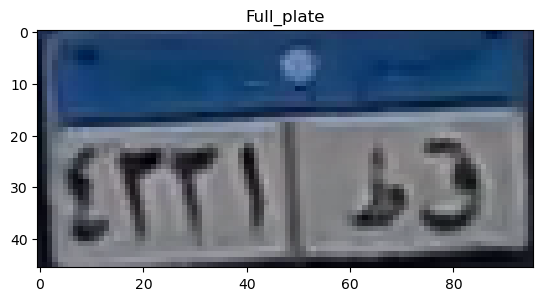

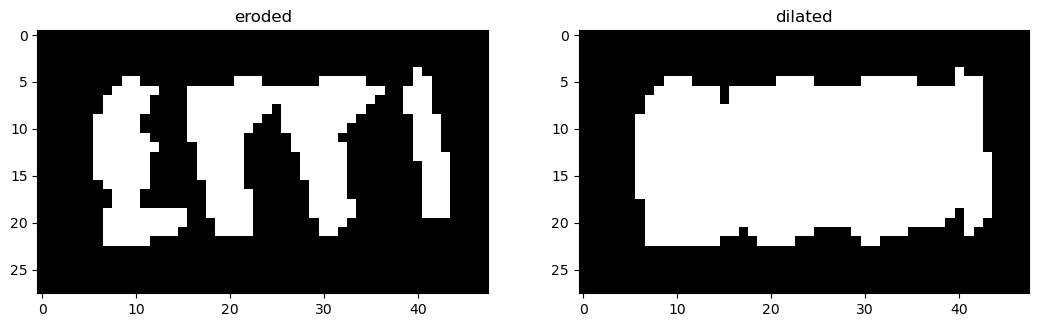

6.0 43.0 4.0 22.0


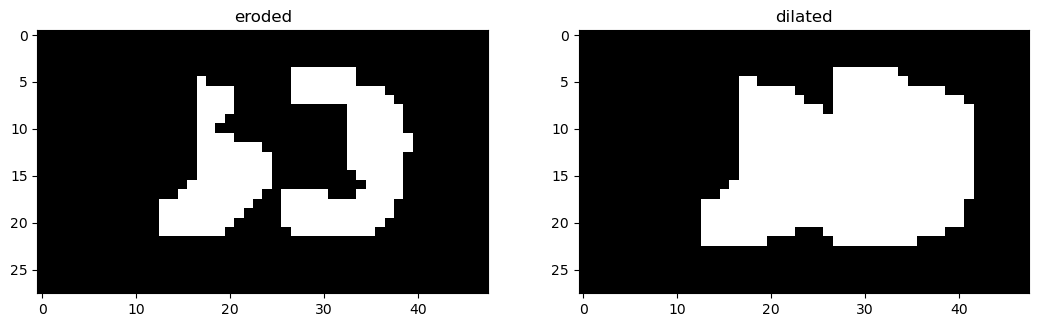

13.0 41.0 4.0 22.0


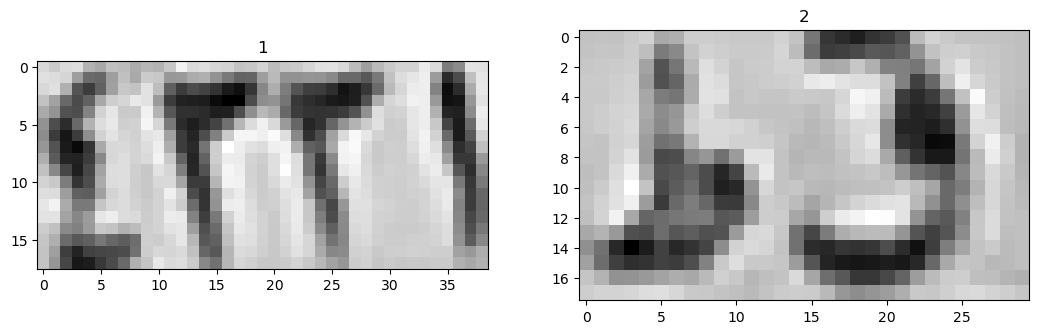

welcome to horizontal seg


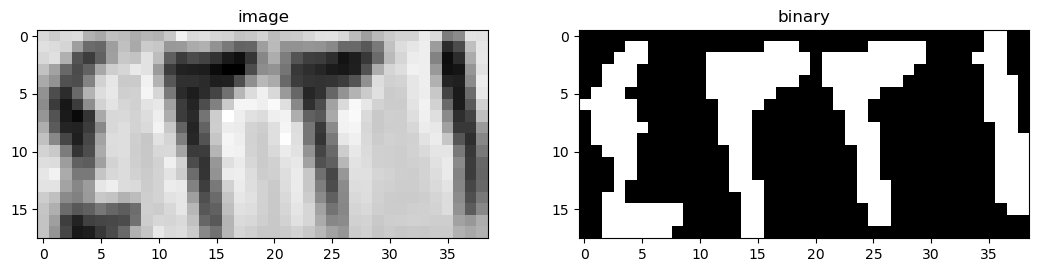

0 9
11 20
21 30
34 38


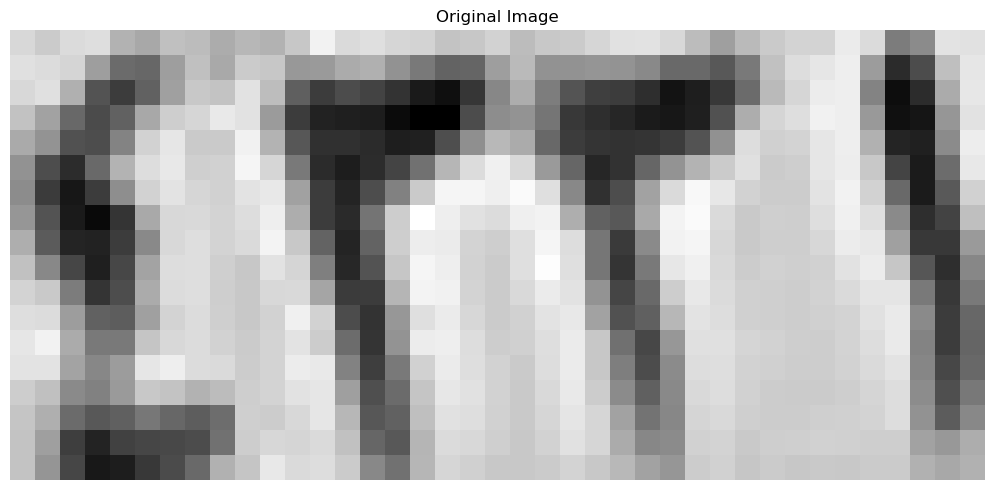

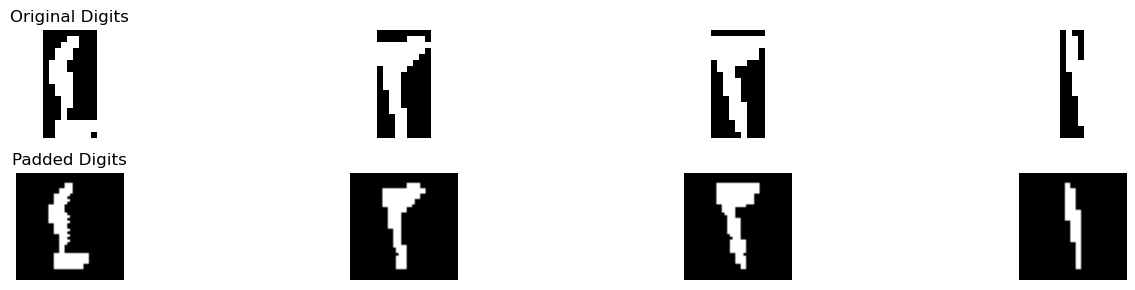

Best match: ٤
Full comparison results: {'١': 0.03125, '٢': 0.5520833333333333, '٣': 0.33272058823529416, '٤': 0.71875, '٥': 0.5208333333333333, '٦': 0.0, '٧': 0.03125, '٨': 0.03125, '٩': 0.3290441176470588}
Confidence :  0.08333333333333337
Best match: ٣
Full comparison results: {'١': 0.0, '٢': 0.78125, '٣': 0.9595588235294118, '٤': 0.65625, '٥': 0.3943452380952381, '٦': 0.125, '٧': 0.3602941176470588, '٨': 0.05555555555555555, '٩': 0.23529411764705882}
Confidence :  0.0891544117647059
Best match: ٢
Full comparison results: {'١': 0.1875, '٢': 0.96875, '٣': 0.8658088235294118, '٤': 0.5625, '٥': 0.4419642857142857, '٦': 0.59375, '٧': 0.6930147058823529, '٨': 0.0, '٩': 0.29411764705882354}
Confidence :  0.0514705882352941
Best match: ١
Full comparison results: {'١': 1.2083333333333335, '٢': 0.08333333333333333, '٣': 0.058823529411764705, '٤': 0.53125, '٥': 0.14285714285714285, '٦': 0.26785714285714285, '٧': 0.46139705882352944, '٨': 0.4340277777777778, '٩': 0.32536764705882354}
Confidence

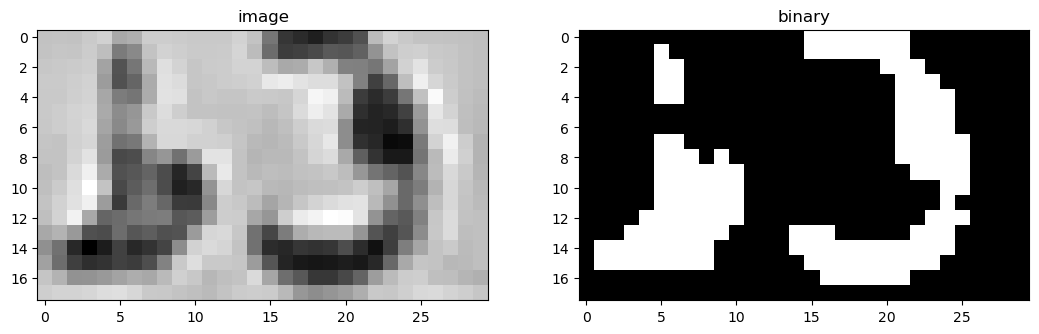

1 11
14 26


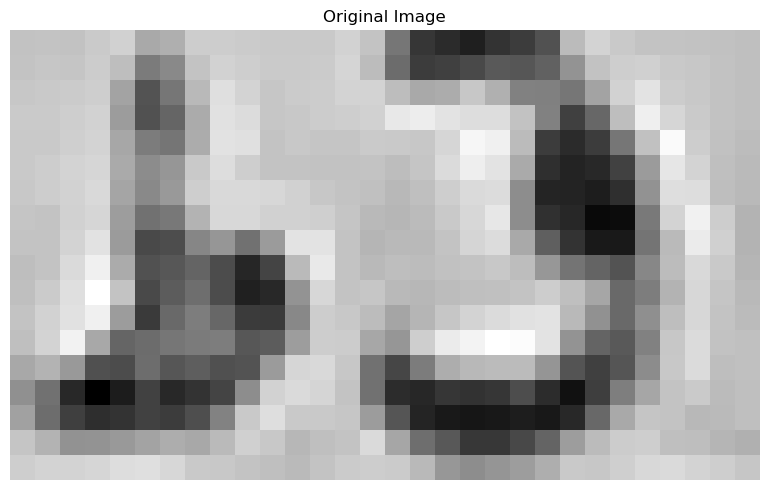

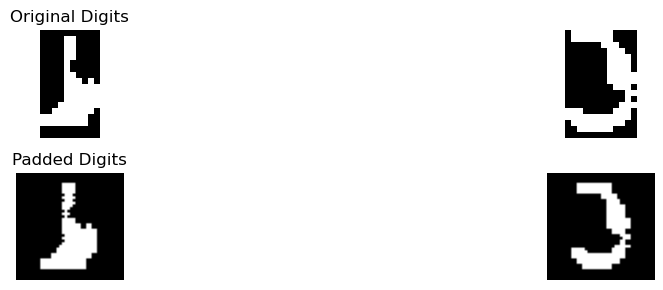

Best match: ط
Full comparison results: {'أ': 0.17410714285714285, 'ب': 0.0625, 'ج': 0.5353260869565217, 'د': 0.7954545454545454, 'ر': 0.5700431034482758, 'س': 0.15625, 'ص': 0.125, 'ط': 1.1145833333333335, 'ع': 0.125, 'ف': 0.7314814814814814, 'ق': 0.6011904761904762, 'ك': 0.4375, 'ل': 0.25297619047619047, 'م': 0.11011904761904762, 'ن': 0.5193452380952381, 'ه': 0.15625, 'و': 0.4270833333333333, 'ي': 0.7259615384615384}
Confidence :  0.15956439393939403
Best match: د
Full comparison results: {'أ': 0.0, 'ب': 0.0625, 'ج': 0.8152173913043478, 'د': 1.3607954545454546, 'ر': 0.4256465517241379, 'س': 0.25, 'ص': 0.15625, 'ط': 0.5625, 'ع': 0.5198863636363636, 'ف': 0.8680555555555556, 'ق': 1.0539772727272727, 'ك': 0.40625, 'ل': 0.5028409090909092, 'م': 0.19886363636363635, 'ن': 0.8096590909090909, 'ه': 0.5625, 'و': 0.75, 'ي': 0.7884615384615384}
Confidence :  0.15340909090909094
[['٤', '٣', '٢', '١'], ['ط', 'د']]


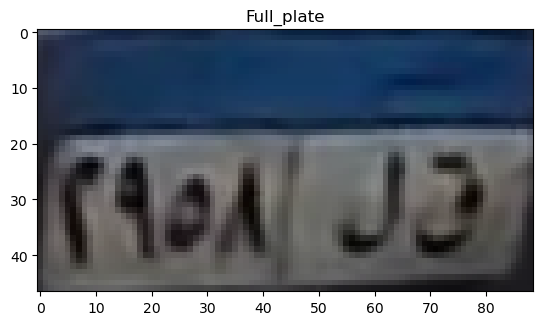

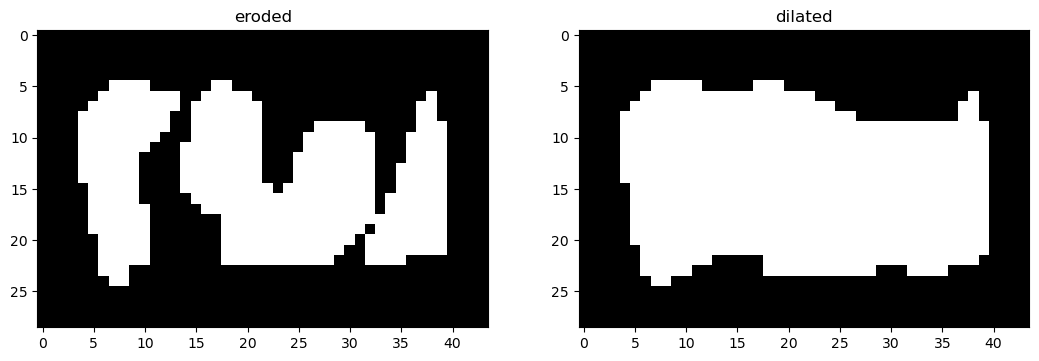

4.0 39.0 5.0 24.0


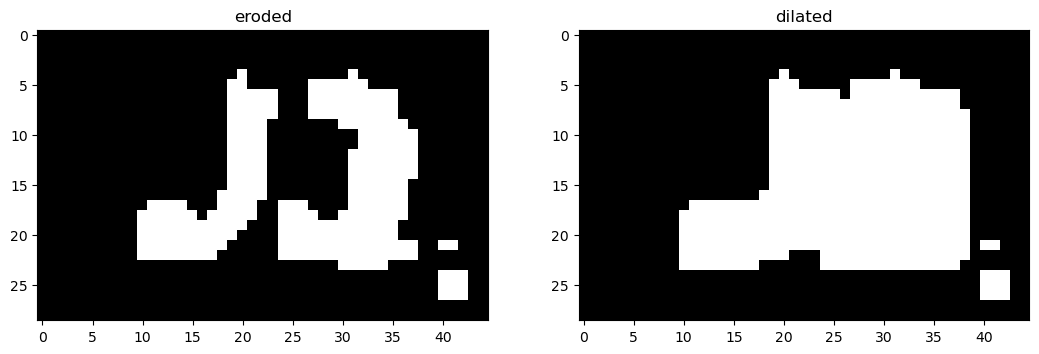

10.0 38.0 4.0 23.0


C:\Users\PC\AppData\Local\Temp\ipykernel_28792\1264601513.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = (Xmax-Xmin)/(Ymax-Ymin)


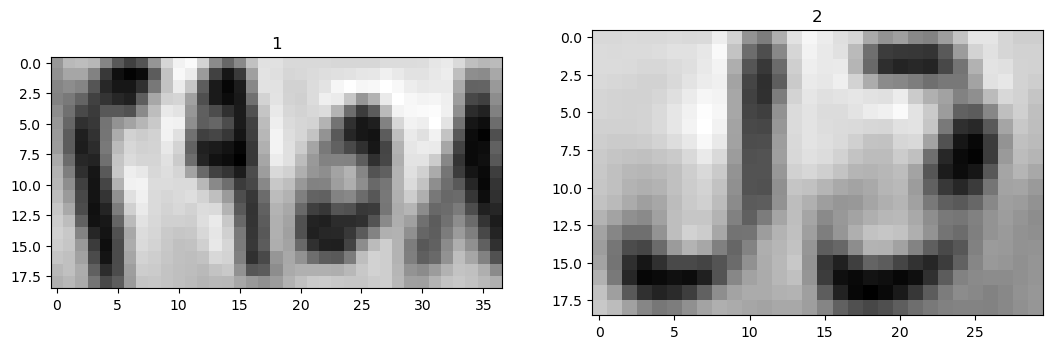

welcome to horizontal seg


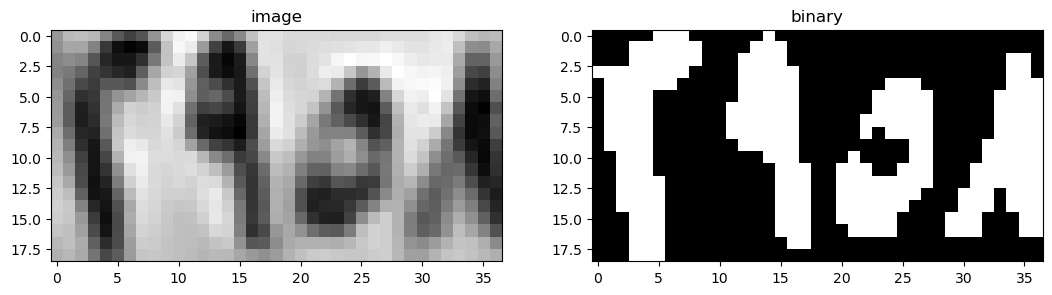

0 9
11 18
20 28
29 36


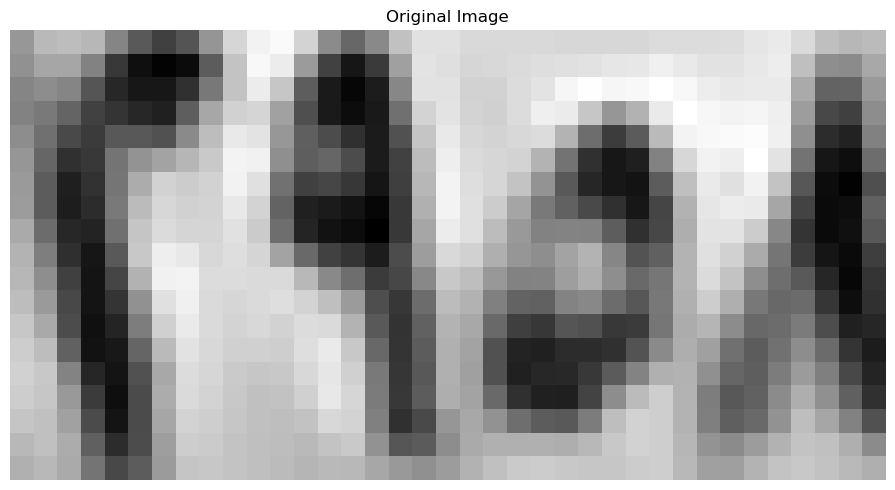

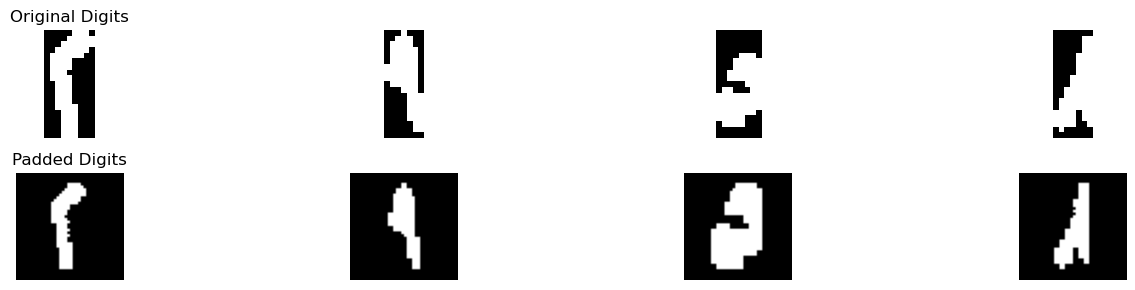

Best match: ٢
Full comparison results: {'١': 0.0, '٢': 1.0360576923076923, '٣': 0.6544117647058824, '٤': 0.59375, '٥': 0.4568452380952381, '٦': 0.0625, '٧': 0.1801470588235294, '٨': 0.0, '٩': 0.1488970588235294}
Confidence :  0.19082296380090497
Best match: ٨
Full comparison results: {'١': 0.3333333333333333, '٢': 0.34375, '٣': 0.1213235294117647, '٤': 0.4375, '٥': 0.19047619047619047, '٦': 0.4955357142857143, '٧': 0.27022058823529416, '٨': 0.6006944444444444, '٩': 0.47794117647058826}
Confidence :  0.05257936507936506
Best match: ٥
Full comparison results: {'١': 0.05263157894736842, '٢': 0.25164473684210525, '٣': 0.10526315789473684, '٤': 0.5032894736842105, '٥': 1.4047619047619047, '٦': 0.3569078947368421, '٧': 0.05263157894736842, '٨': 0.2631578947368421, '٩': 0.0}
Confidence :  0.4507362155388471
Best match: ٦
Full comparison results: {'١': 0.15384615384615385, '٢': 0.07692307692307693, '٣': 0.058823529411764705, '٤': 0.4375, '٥': 0.2857142857142857, '٦': 0.4732142857142857, '٧': 0

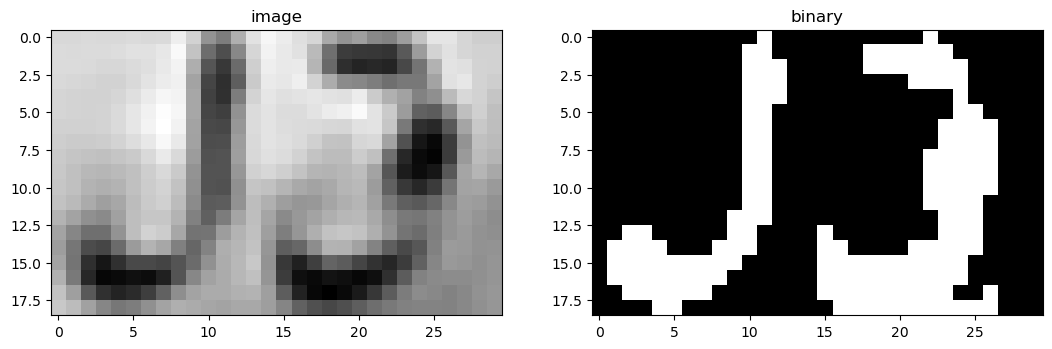

1 13
15 27


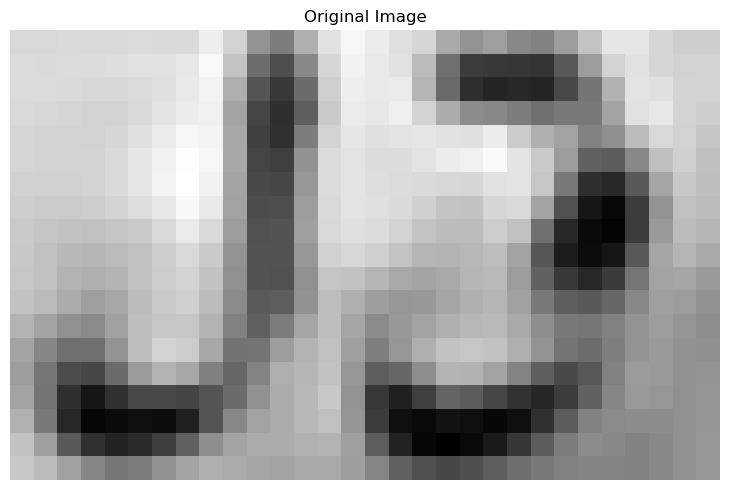

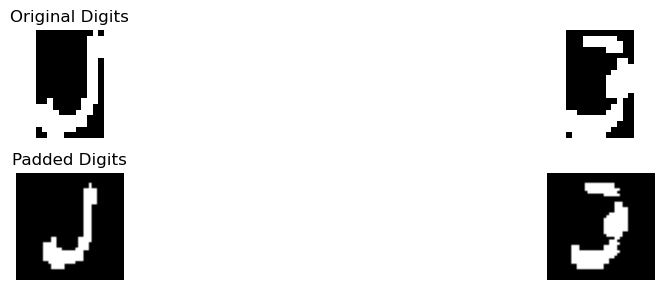

Best match: ل
Full comparison results: {'أ': 0.0, 'ب': 0.0, 'ج': 0.21195652173913043, 'د': 0.5198863636363636, 'ر': 0.4698275862068966, 'س': 0.4375, 'ص': 0.34375, 'ط': 0.27083333333333337, 'ع': 0.1125, 'ف': 0.29050925925925924, 'ق': 0.44375, 'ك': 0.25, 'ل': 0.975, 'م': 0.0, 'ن': 0.50625, 'ه': 0.25, 'و': 0.5208333333333333, 'ي': 0.65625}
Confidence :  0.159375
Best match: د
Full comparison results: {'أ': 0.047619047619047616, 'ب': 0.125, 'ج': 0.6657608695652174, 'د': 1.0539772727272727, 'ر': 0.3663793103448276, 'س': 0.625, 'ص': 0.34375, 'ط': 0.5625, 'ع': 0.5059523809523809, 'ف': 0.9224537037037037, 'ق': 0.9166666666666666, 'ك': 0.4583333333333333, 'ل': 0.6324404761904762, 'م': 0.14136904761904762, 'ن': 0.738095238095238, 'ه': 0.5, 'و': 0.6041666666666667, 'ي': 0.8653846153846154}
Confidence :  0.0657617845117845
[['٢', '٨', '٥', '٦'], ['ل', 'د']]


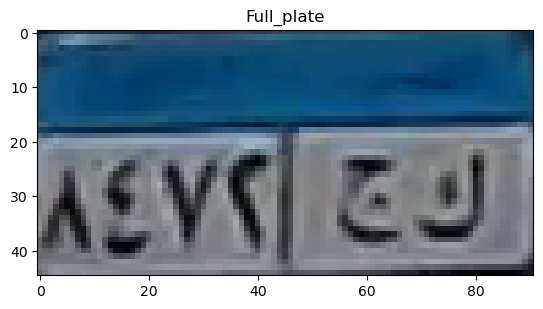

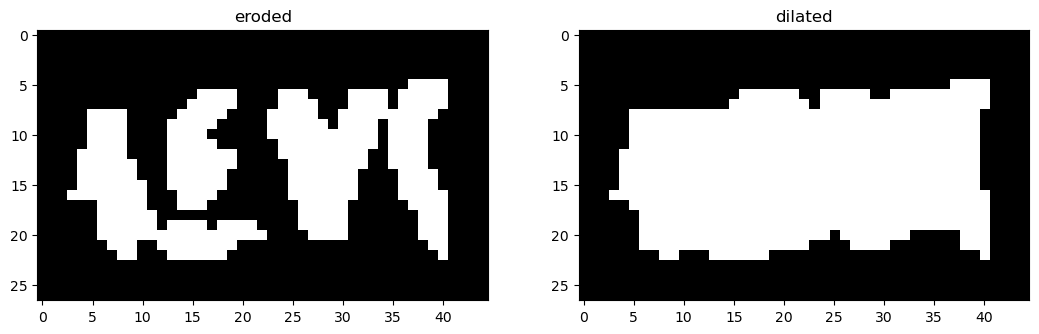

3.0 40.0 5.0 22.0


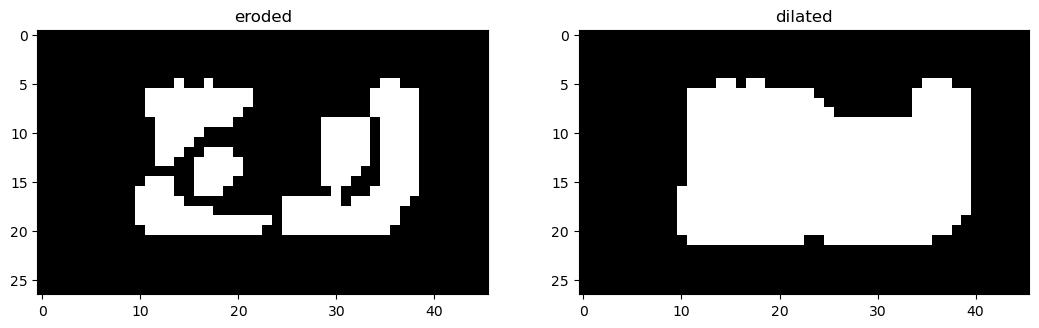

10.0 39.0 5.0 21.0


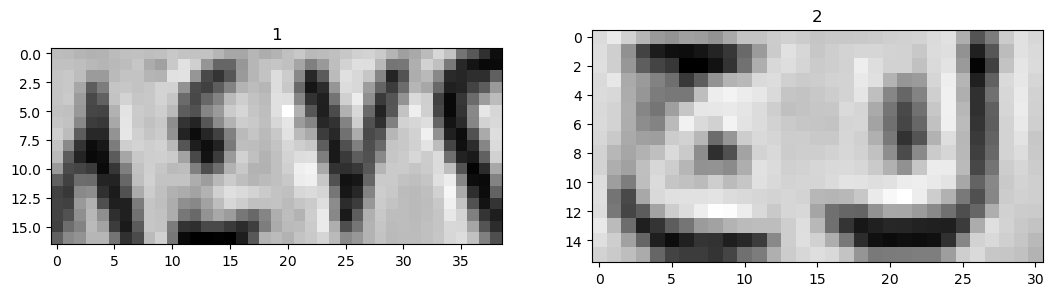

welcome to horizontal seg


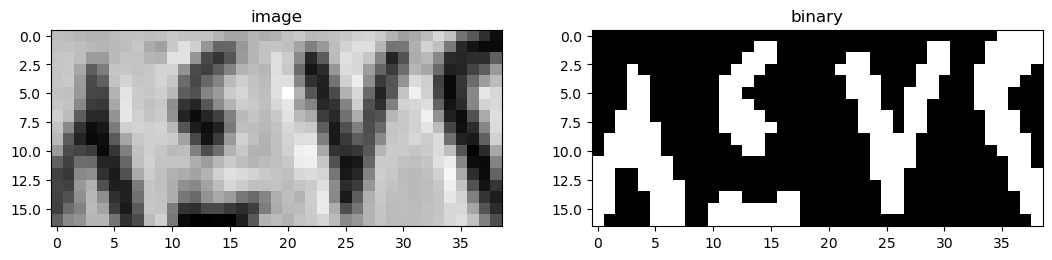

0 8
10 18
21 31
33 38


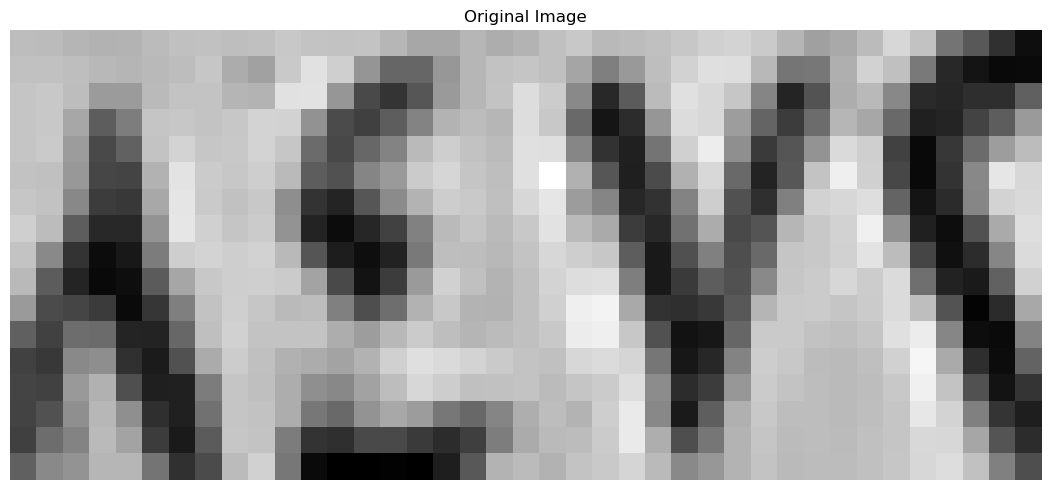

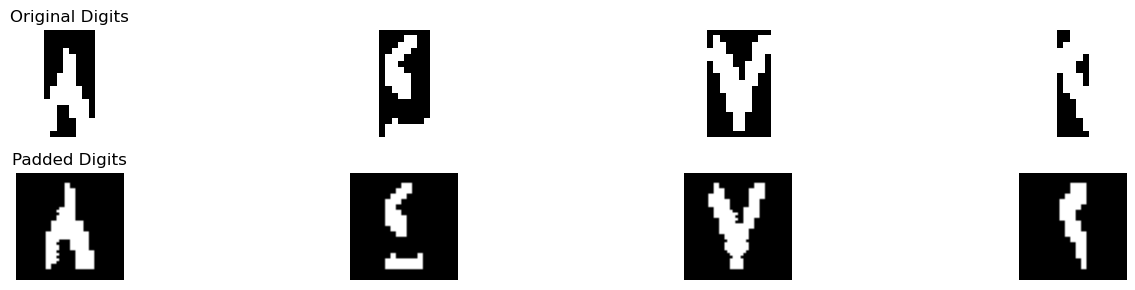

Best match: ٨
Full comparison results: {'١': 0.4409722222222222, '٢': 0.2534722222222222, '٣': 0.05555555555555555, '٤': 0.5034722222222222, '٥': 0.28422619047619047, '٦': 0.2222222222222222, '٧': 0.16666666666666666, '٨': 1.3090277777777777, '٩': 0.3472222222222222}
Confidence :  0.40277777777777773
Best match: ٢
Full comparison results: {'١': 0.20535714285714285, '٢': 0.75, '٣': 0.44669117647058826, '٤': 0.75, '٥': 0.5684523809523809, '٦': 0.0, '٧': 0.0625, '٨': 0.05555555555555555, '٩': 0.3602941176470588}
Confidence :  0.0
Best match: ٧
Full comparison results: {'١': 0.047619047619047616, '٢': 0.3645833333333333, '٣': 0.2857142857142857, '٤': 0.2857142857142857, '٥': 0.3794642857142857, '٦': 0.2857142857142857, '٧': 0.6800595238095238, '٨': 0.09523809523809523, '٩': 0.25297619047619047}
Confidence :  0.15029761904761907
Best match: ٤
Full comparison results: {'١': 0.4, '٢': 0.5416666666666667, '٣': 0.1213235294117647, '٤': 0.6875, '٥': 0.34672619047619047, '٦': 0.5669642857142857, 

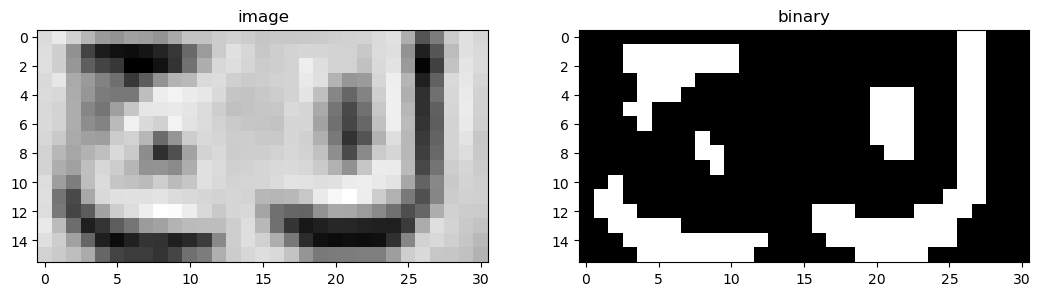

1 13
16 28


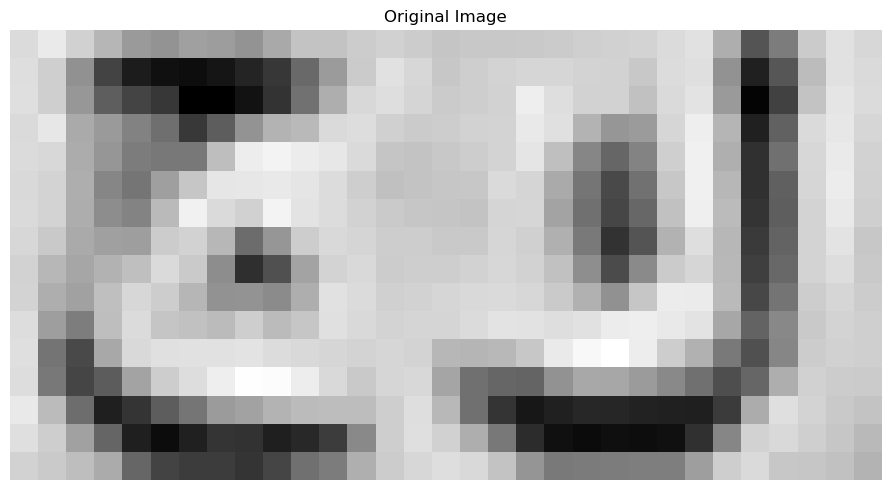

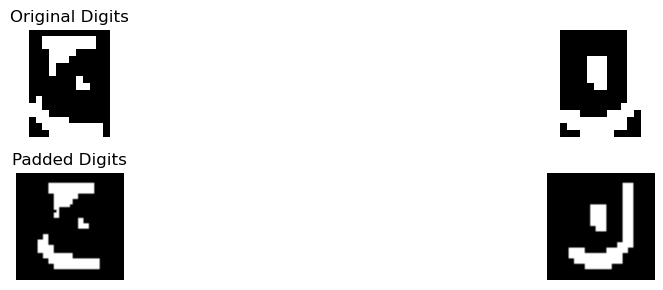

Best match: ج
Full comparison results: {'أ': 0.0, 'ب': 0.03125, 'ج': 1.1331521739130435, 'د': 0.6032608695652174, 'ر': 0.0625, 'س': 0.125, 'ص': 0.1875, 'ط': 0.1875, 'ع': 0.39809782608695654, 'ف': 0.44675925925925924, 'ق': 0.5285326086956521, 'ك': 0.26041666666666663, 'ل': 0.07472826086956522, 'م': 0.21739130434782608, 'ن': 0.453804347826087, 'ه': 0.0625, 'و': 0.14583333333333331, 'ي': 0.10817307692307693}
Confidence :  0.264945652173913
Best match: ك
Full comparison results: {'أ': 0.041666666666666664, 'ب': 0.09375, 'ج': 0.40625, 'د': 0.7083333333333333, 'ر': 0.9202586206896552, 'س': 0.28125, 'ص': 0.40625, 'ط': 0.7708333333333334, 'ع': 0.53125, 'ف': 0.5636574074074074, 'ق': 0.29166666666666663, 'ك': 1.2604166666666665, 'ل': 0.3854166666666667, 'م': 0.041666666666666664, 'ن': 0.65625, 'ه': 0.375, 'و': 0.7083333333333333, 'ي': 0.7043269230769231}
Confidence :  0.17007902298850563
[['٨', '٢', '٧', '٤'], ['ج', 'ك']]


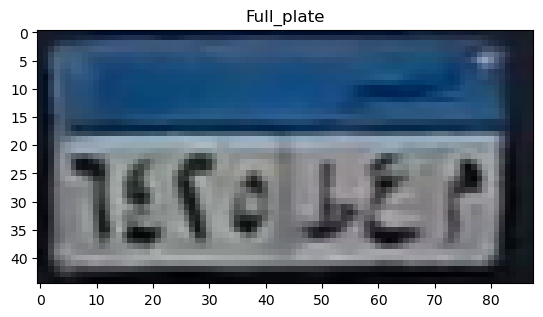

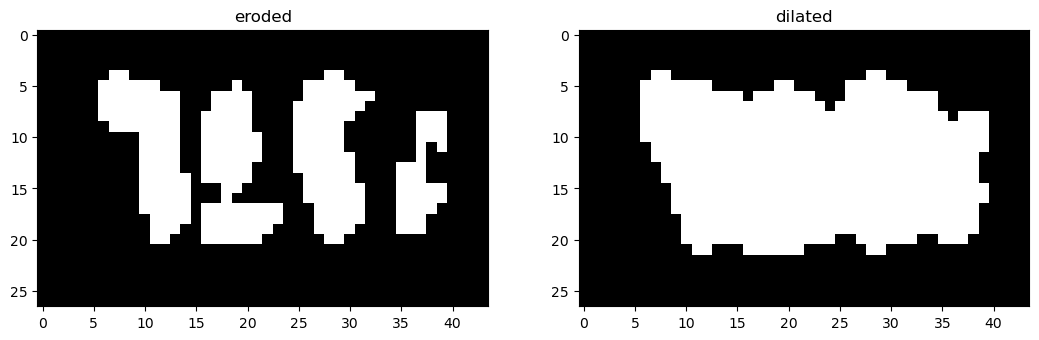

6.0 39.0 4.0 21.0


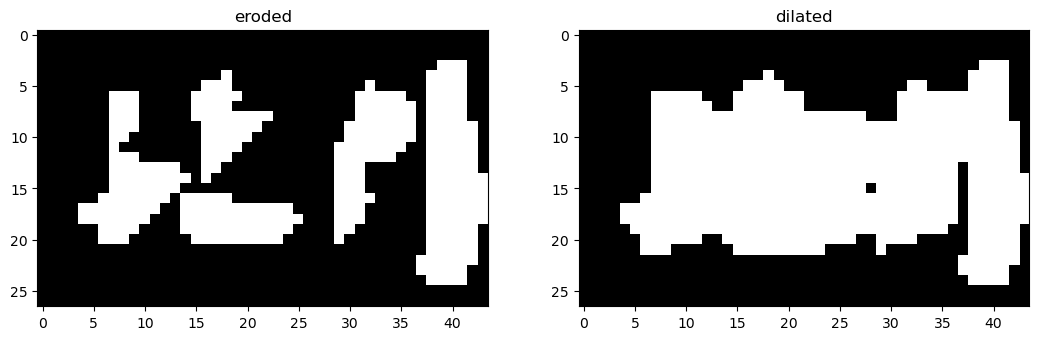

4.0 43.0 3.0 24.0


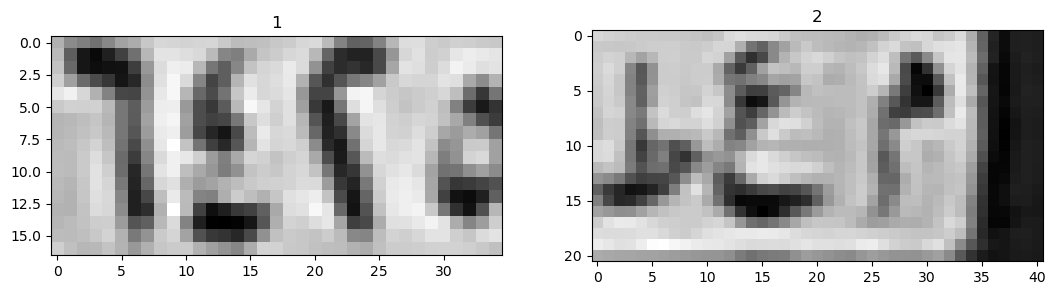

welcome to horizontal seg


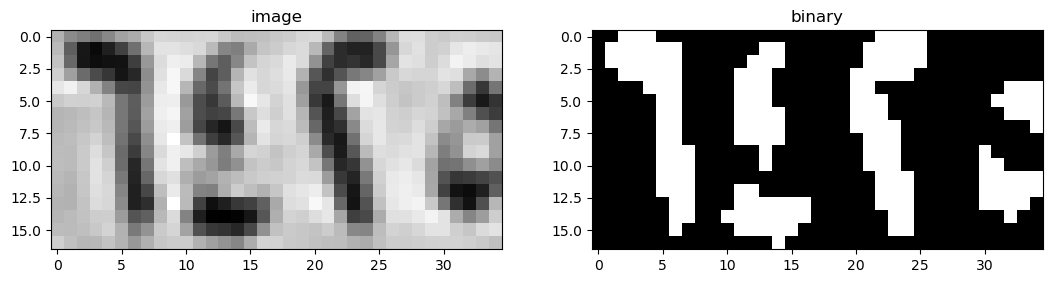

1 8
10 17
20 26
30 34


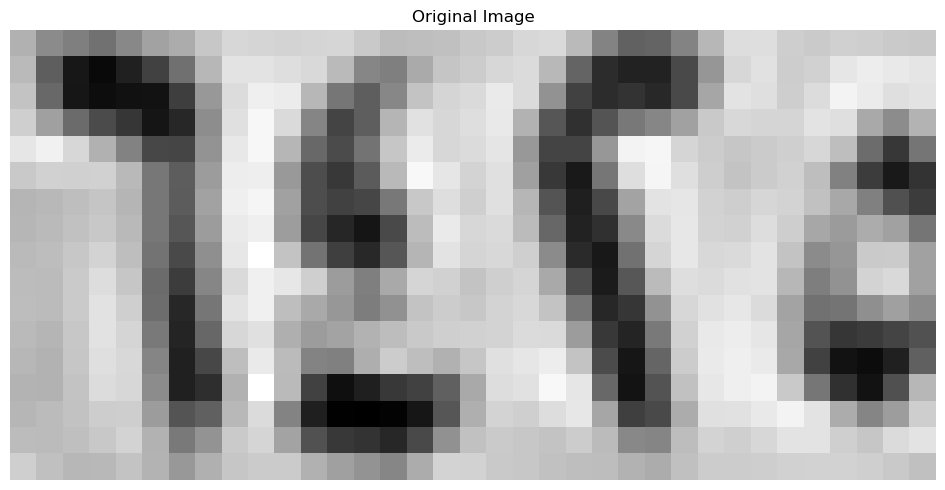

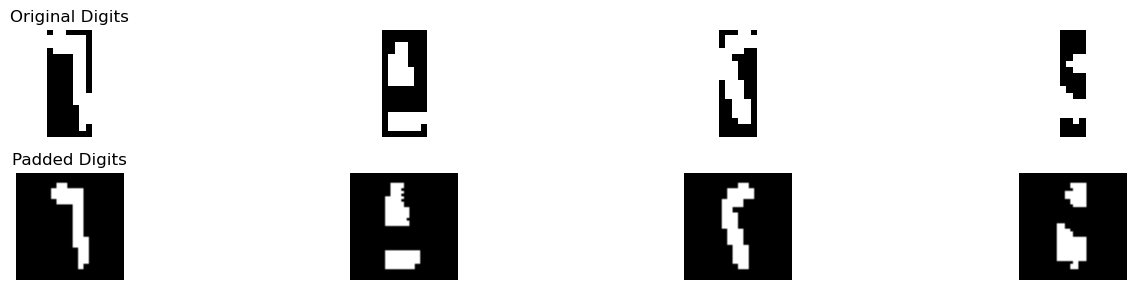

Best match: ٦
Full comparison results: {'١': 0.21428571428571427, '٢': 0.125, '٣': 0.36397058823529416, '٤': 0.0625, '٥': 0.37797619047619047, '٦': 1.4196428571428572, '٧': 0.0, '٨': 0.3715277777777778, '٩': 0.6029411764705883}
Confidence :  0.40835084033613445
Best match: ٤
Full comparison results: {'١': 0.15384615384615385, '٢': 0.38461538461538464, '٣': 0.20772058823529413, '٤': 0.84375, '٥': 0.5520833333333333, '٦': 0.0, '٧': 0.058823529411764705, '٨': 0.08680555555555555, '٩': 0.5165441176470589}
Confidence :  0.14583333333333337
Best match: ٢
Full comparison results: {'١': 0.08333333333333333, '٢': 1.15625, '٣': 0.5091911764705883, '٤': 0.6875, '٥': 0.4732142857142857, '٦': 0.26785714285714285, '٧': 0.5441176470588236, '٨': 0.0, '٩': 0.058823529411764705}
Confidence :  0.234375
Best match: ٢
Full comparison results: {'١': 0.09090909090909091, '٢': 0.5833333333333333, '٣': 0.1213235294117647, '٤': 0.40625, '٥': 0.5372023809523809, '٦': 0.3482142857142857, '٧': 0.23897058823529413,

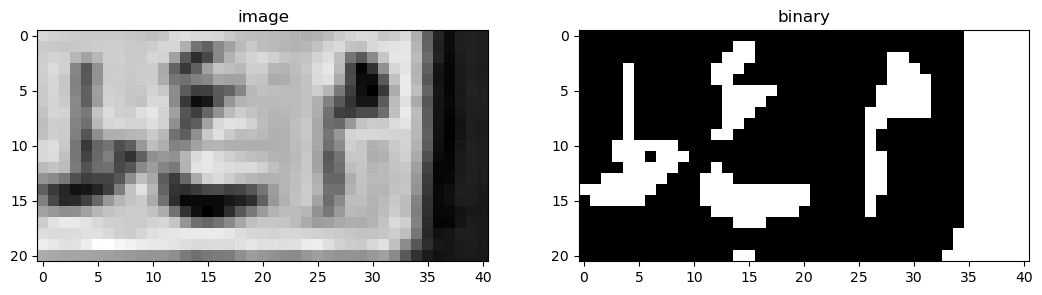

0 10
11 21
26 32
33 40


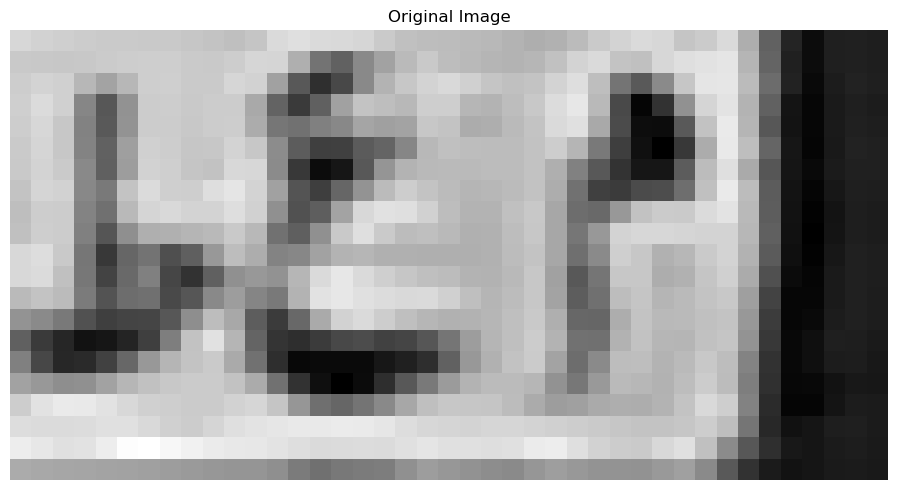

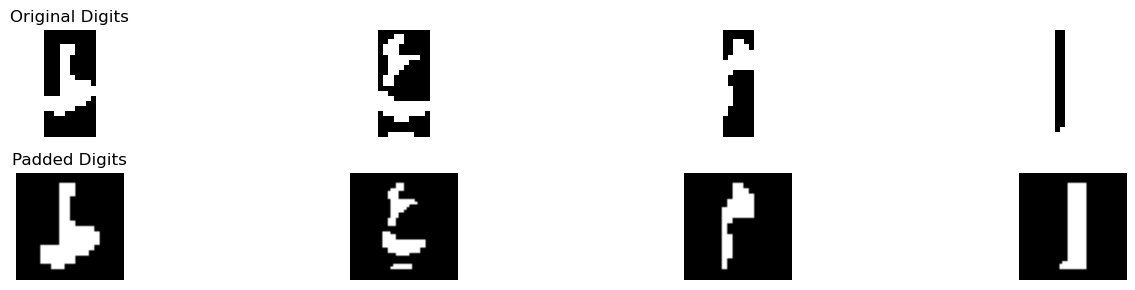

Best match: د
Full comparison results: {'أ': 0.13636363636363635, 'ب': 0.0, 'ج': 0.36684782608695654, 'د': 0.7982954545454546, 'ر': 0.1314655172413793, 'س': 0.4375, 'ص': 0.3125, 'ط': 0.7604166666666666, 'ع': 0.1846590909090909, 'ف': 0.5150462962962963, 'ق': 0.4431818181818182, 'ك': 0.3541666666666667, 'ل': 0.23011363636363635, 'م': 0.13920454545454547, 'ن': 0.4460227272727273, 'ه': 0.4375, 'و': 0.09375, 'ي': 0.6105769230769231}
Confidence :  0.018939393939393978
Best match: م
Full comparison results: {'أ': 0.03125, 'ب': 0.0625, 'ج': 0.10597826086956522, 'د': 0.1534090909090909, 'ر': 0.10021551724137931, 'س': 0.0625, 'ص': 0.0, 'ط': 0.1875, 'ع': 0.20888157894736842, 'ف': 0.125, 'ق': 0.03125, 'ك': 0.0, 'ل': 0.0625, 'م': 0.3125, 'ن': 0.0625, 'ه': 0.21875, 'و': 0.0625, 'ي': 0.0}
Confidence :  0.046875
Best match: م
Full comparison results: {'أ': 0.03125, 'ب': 0.0, 'ج': 0.0, 'د': 0.5198863636363636, 'ر': 0.0, 'س': 0.15625, 'ص': 0.0625, 'ط': 0.03125, 'ع': 0.3355263157894737, 'ف': 0.0740740740

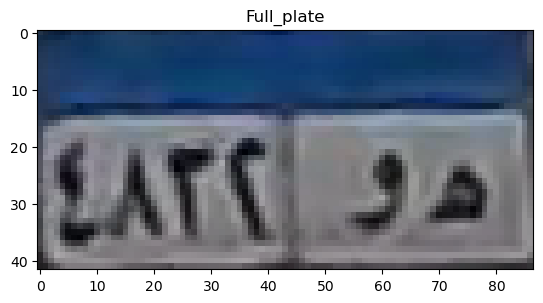

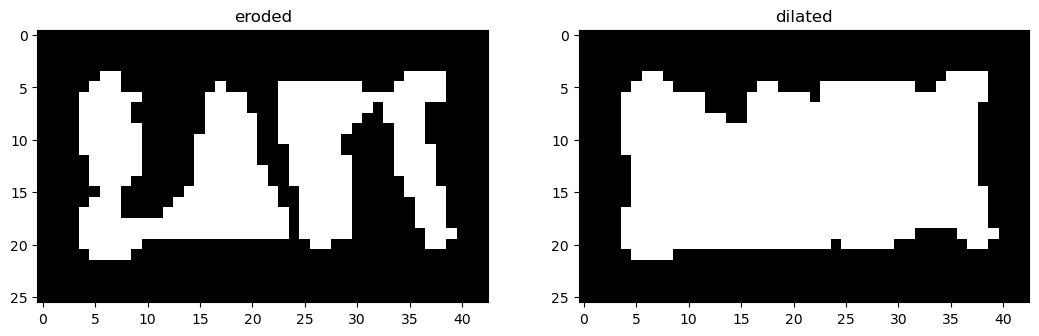

4.0 39.0 4.0 21.0


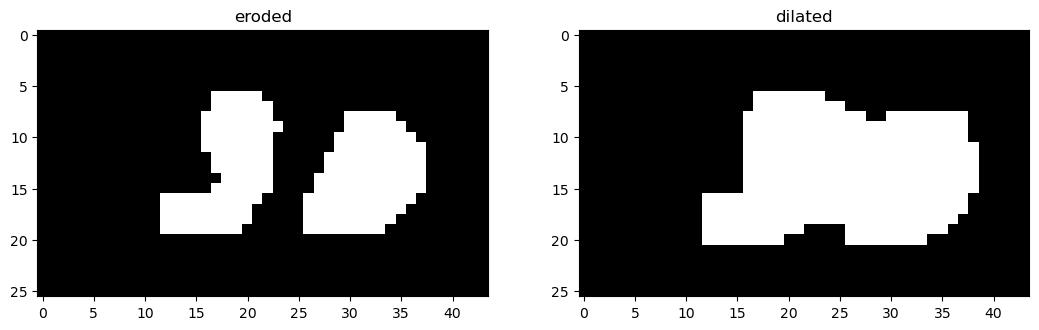

12.0 38.0 6.0 20.0


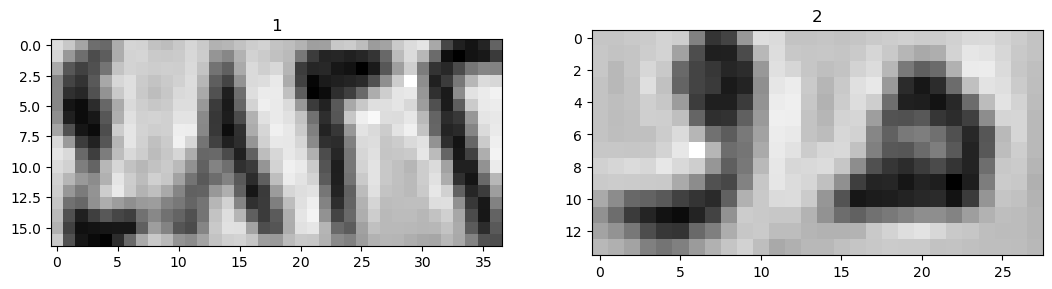

welcome to horizontal seg


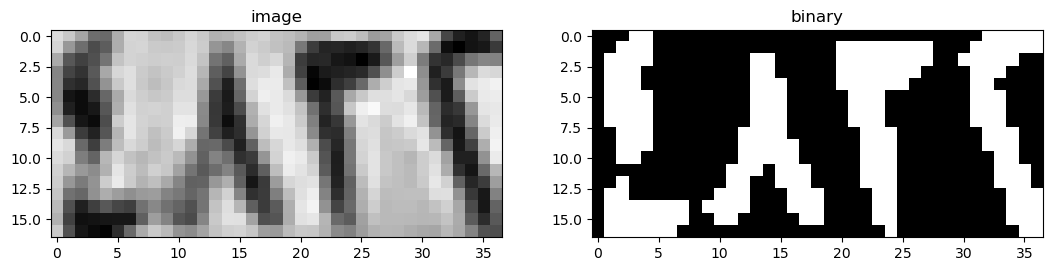

1 8
9 19
20 28
30 36


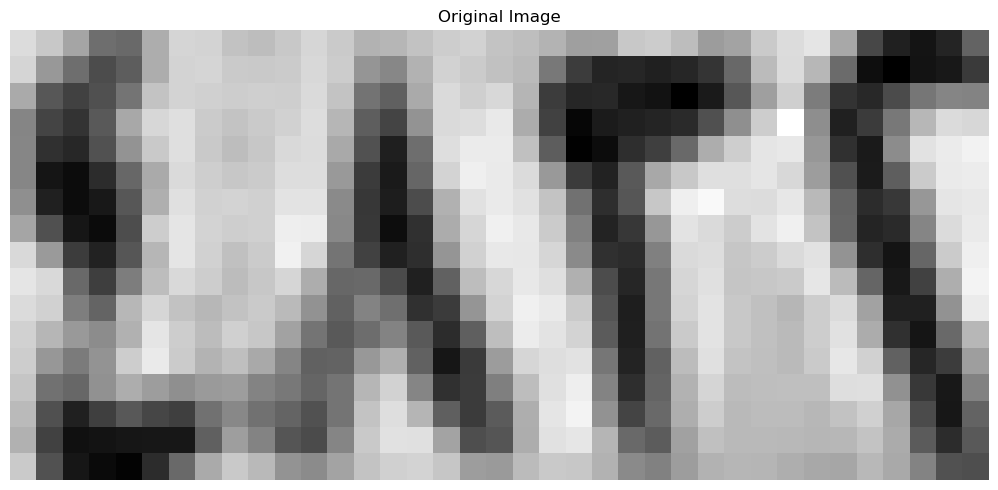

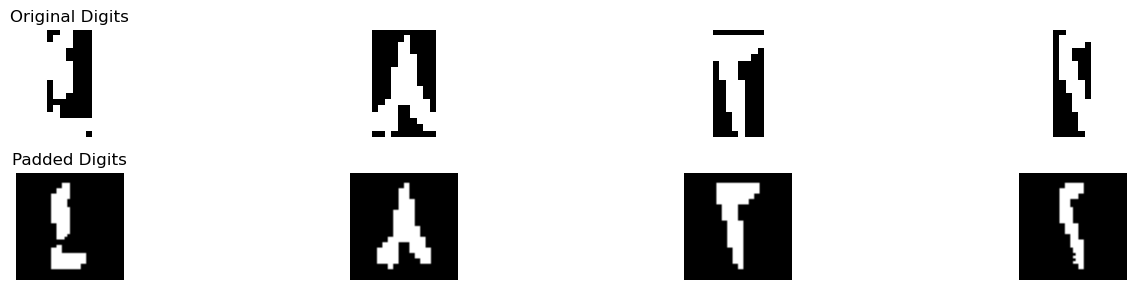

Best match: ٤
Full comparison results: {'١': 0.13942307692307693, '٢': 0.6033653846153846, '٣': 0.2977941176470588, '٤': 0.71875, '٥': 0.5208333333333333, '٦': 0.0, '٧': 0.0, '٨': 0.05555555555555555, '٩': 0.33272058823529416}
Confidence :  0.05769230769230771
Best match: ٨
Full comparison results: {'١': 0.2625, '٢': 0.05, '٣': 0.1, '٤': 0.60625, '٥': 0.3958333333333333, '٦': 0.15, '٧': 0.13125, '٨': 1.05625, '٩': 0.34375}
Confidence :  0.22499999999999998
Best match: ٢
Full comparison results: {'١': 0.125, '٢': 1.15625, '٣': 0.9558823529411765, '٤': 0.8125, '٥': 0.3943452380952381, '٦': 0.375, '٧': 0.6305147058823529, '٨': 0.03125, '٩': 0.23529411764705882}
Confidence :  0.10018382352941174
Best match: ٢
Full comparison results: {'١': 0.2534722222222222, '٢': 0.8645833333333334, '٣': 0.11764705882352941, '٤': 0.8125, '٥': 0.4107142857142857, '٦': 0.23660714285714285, '٧': 0.6691176470588236, '٨': 0.1111111111111111, '٩': 0.2665441176470588}
Confidence :  0.026041666666666685
welcome t

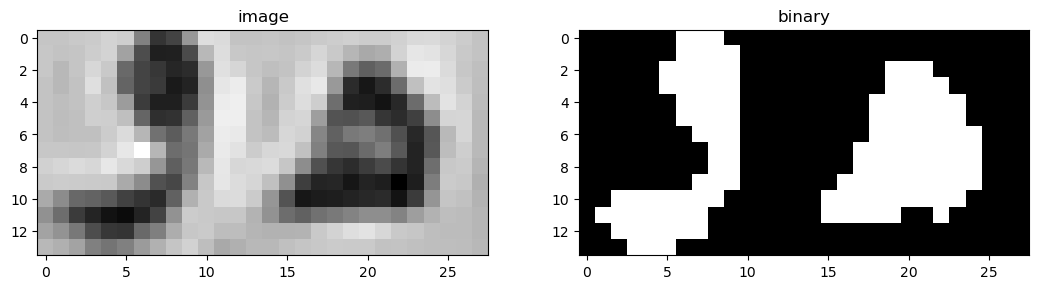

1 10
15 25


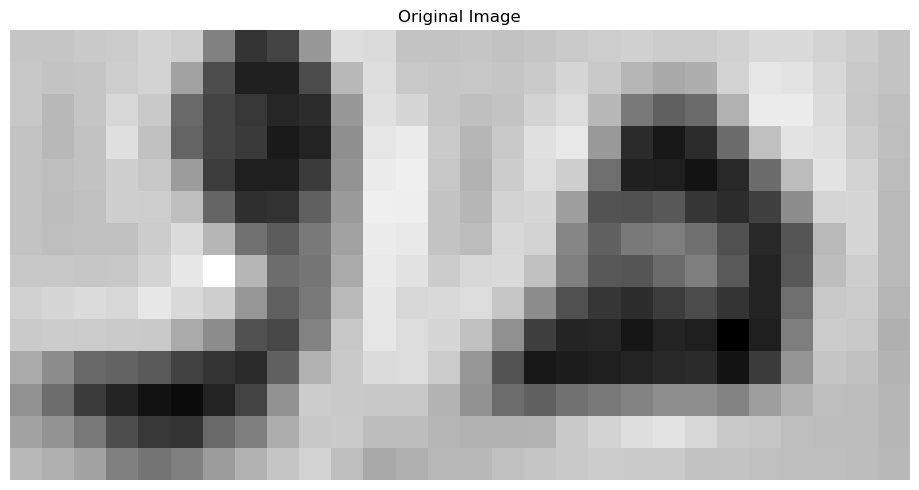

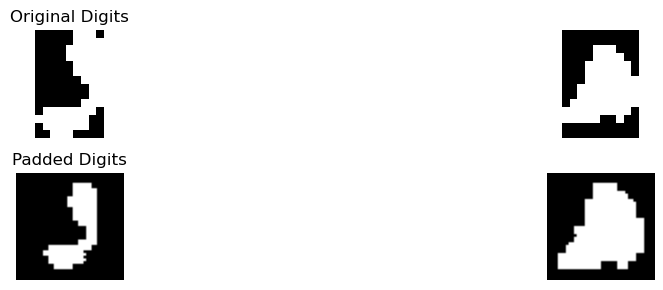

Best match: و
Full comparison results: {'أ': 0.0, 'ب': 0.0, 'ج': 0.21195652173913043, 'د': 0.9460227272727273, 'ر': 0.43211206896551724, 'س': 0.4375, 'ص': 0.28125, 'ط': 0.29166666666666663, 'ع': 0.175, 'ف': 0.4583333333333333, 'ق': 0.50625, 'ك': 0.3958333333333333, 'ل': 0.55625, 'م': 0.225, 'ن': 0.60625, 'ه': 0.78125, 'و': 1.1458333333333335, 'ي': 0.6802884615384616}
Confidence :  0.0999053030303031
Best match: ه
Full comparison results: {'أ': 0.0625, 'ب': 0.125, 'ج': 0.25, 'د': 0.25, 'ر': 0.1875, 'س': 0.21875, 'ص': 0.21875, 'ط': 0.125, 'ع': 0.21875, 'ف': 0.53125, 'ق': 0.125, 'ك': 0.15625, 'ل': 0.09375, 'م': 0.28125, 'ن': 0.15625, 'ه': 0.90625, 'و': 0.375, 'ي': 0.125}
Confidence :  0.1875
[['٤', '٨', '٢', '٢'], ['و', 'ه']]


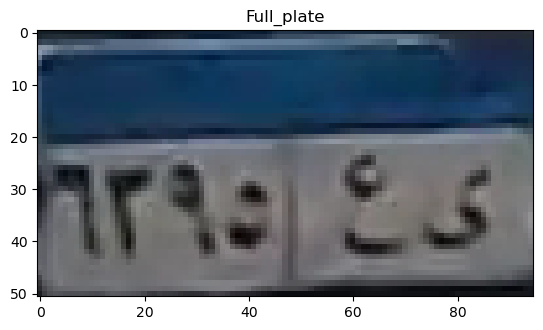

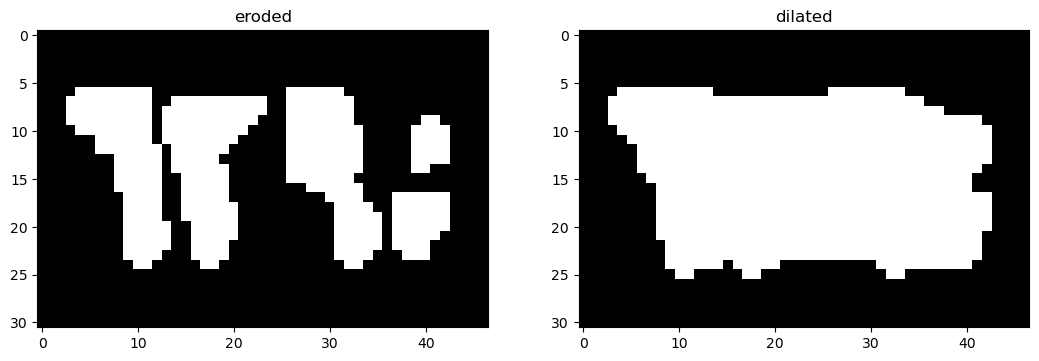

3.0 42.0 6.0 25.0


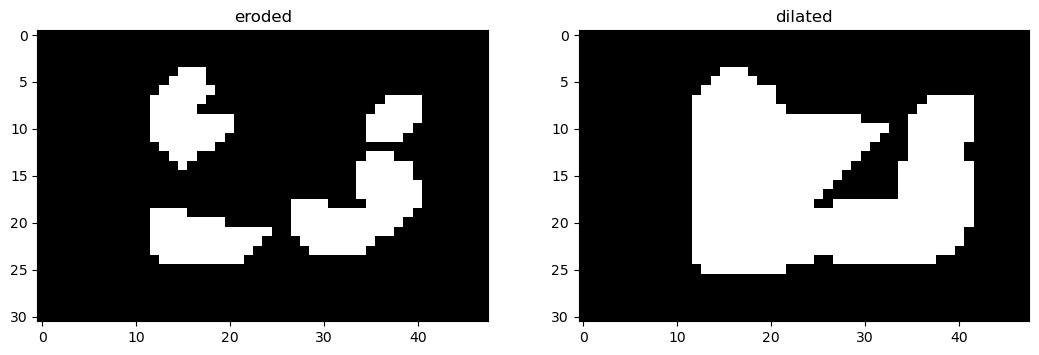

12.0 41.0 4.0 25.0


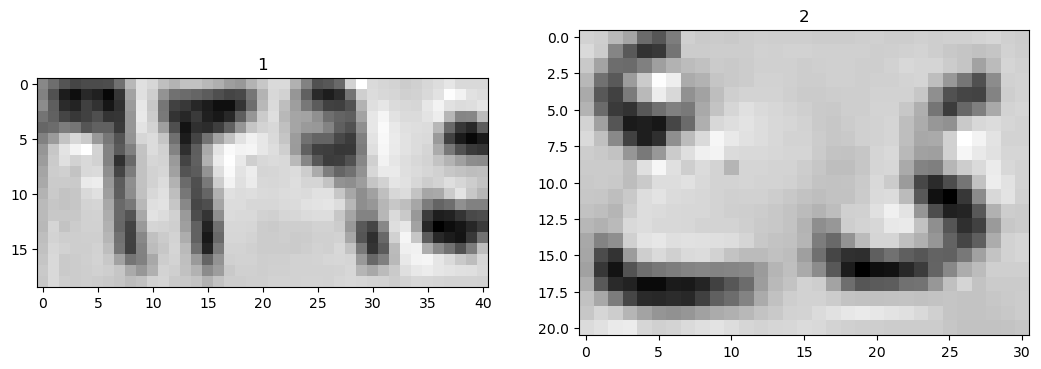

welcome to horizontal seg


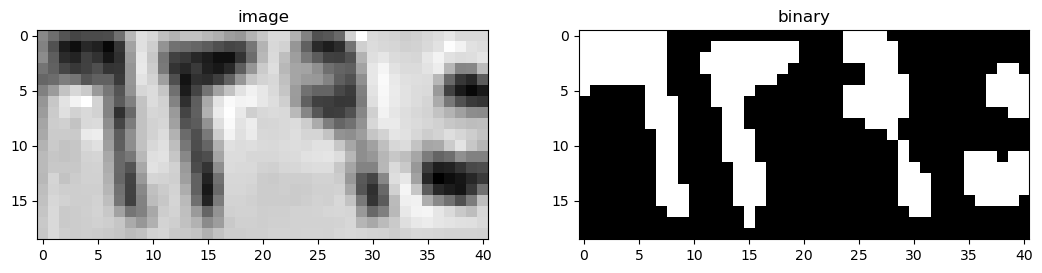

0 10
11 20
24 32
35 40


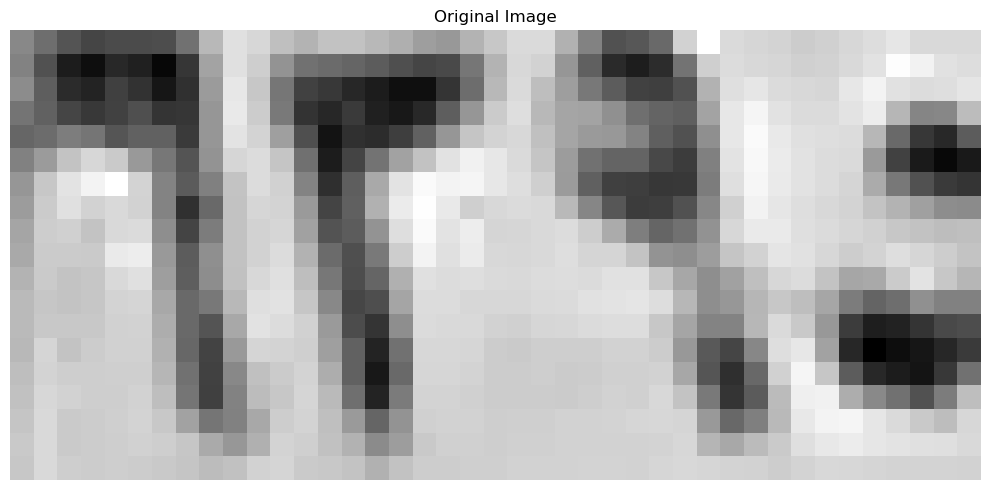

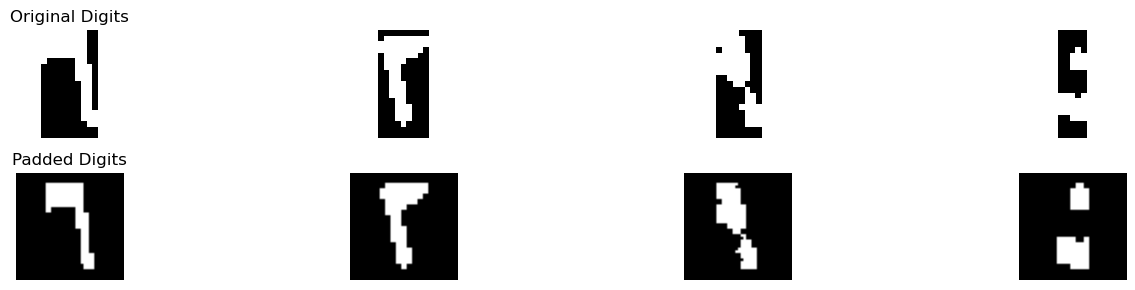

Best match: ٦
Full comparison results: {'١': 0.16666666666666666, '٢': 0.0625, '٣': 0.7743055555555556, '٤': 0.0, '٥': 0.5684523809523809, '٦': 0.9791666666666666, '٧': 0.2222222222222222, '٨': 0.3333333333333333, '٩': 0.59375}
Confidence :  0.10243055555555552
Best match: ٣
Full comparison results: {'١': 0.05555555555555555, '٢': 0.8368055555555556, '٣': 1.0277777777777777, '٤': 0.5069444444444444, '٥': 0.4419642857142857, '٦': 0.35416666666666663, '٧': 0.5138888888888888, '٨': 0.0, '٩': 0.16666666666666666}
Confidence :  0.09548611111111105
Best match: ٩
Full comparison results: {'١': 0.3645833333333333, '٢': 0.3333333333333333, '٣': 0.29411764705882354, '٤': 0.40625, '٥': 0.2857142857142857, '٦': 0.2895833333333333, '٧': 0.32536764705882354, '٨': 0.4444444444444444, '٩': 1.0772058823529411}
Confidence :  0.31638071895424835
Best match: ٤
Full comparison results: {'١': 0.08333333333333333, '٢': 0.28125, '٣': 0.058823529411764705, '٤': 0.5625, '٥': 0.5520833333333333, '٦': 0.388392857

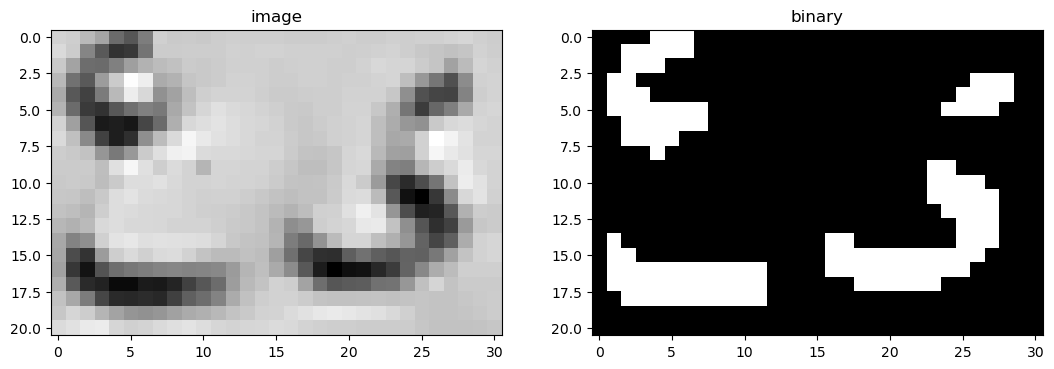

1 12
16 29


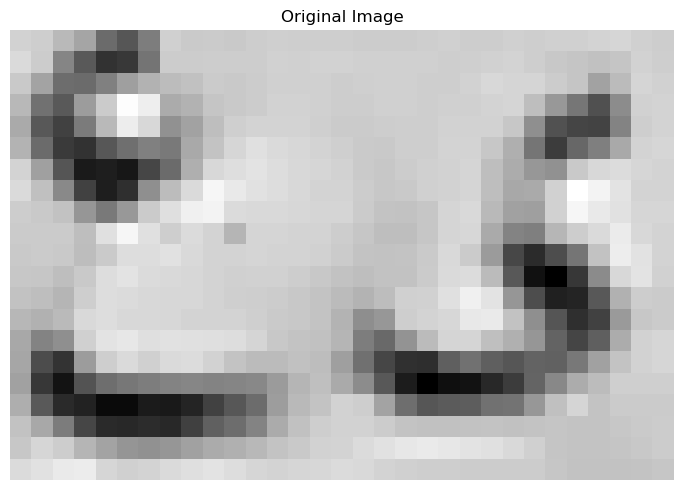

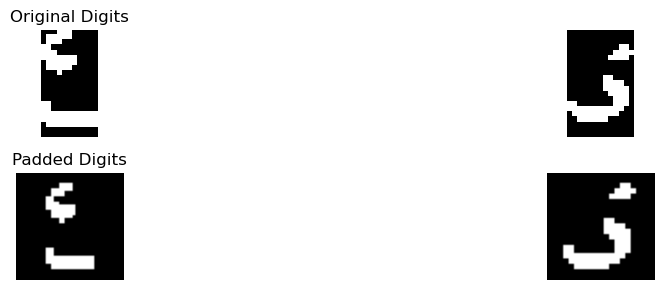

Best match: ع
Full comparison results: {'أ': 0.0, 'ب': 0.0625, 'ج': 0.34239130434782605, 'د': 0.5511363636363636, 'ر': 0.2629310344827586, 'س': 0.0625, 'ص': 0.0625, 'ط': 0.29166666666666663, 'ع': 1.2614601018675722, 'ف': 0.44675925925925924, 'ق': 0.3569078947368421, 'ك': 0.6458333333333333, 'ل': 0.1736111111111111, 'م': 0.2847222222222222, 'ن': 0.70625, 'ه': 0.0625, 'و': 0.21875, 'ي': 0.24759615384615385}
Confidence :  0.27760505093378607
Best match: ي
Full comparison results: {'أ': 0.0, 'ب': 0.15625, 'ج': 0.30439814814814814, 'د': 0.5266203703703703, 'ر': 0.7704741379310345, 'س': 0.5, 'ص': 0.34375, 'ط': 0.7372685185185185, 'ع': 0.2673611111111111, 'ف': 0.8796296296296297, 'ق': 0.6074074074074074, 'ك': 0.8055555555555556, 'ل': 0.4386574074074074, 'م': 0.0, 'ن': 0.6427718040621266, 'ه': 0.3125, 'و': 0.9537037037037037, 'ي': 1.4201388888888888}
Confidence :  0.23321759259259256
[['٦', '٣', '٩', '٤'], ['ع', 'ي']]
أعو٨٧٥٥ أعو٨٧٥٦
أقط١٢٧ أنط١٤٧٨
أي٦٤٢٤ أي٦٤٢٤
بط٢٥١٧ بط٢٥١٧
بك٣٢١٧ بك٣٢١٢
جل٩

In [31]:
def compare_result_with_answer(result, answer):
    # Step 1: Flatten the result and join all characters into a single string
    # Flatten the result into a single list
    flattened = [char for sublist in result for char in sublist]
    
    # Separate characters and digits
    characters = [char for char in flattened if not char.isdigit()]
    digits = [char for char in flattened if char.isdigit()]
    
    # Reverse characters and concatenate with digits
    reconstructed_result = ''.join(characters[::-1] + digits)
    
    print(reconstructed_result,answer)
    
    # Step 2: Compare the reconstructed result with the answer
    is_match = reconstructed_result == answer
    
    return is_match

def load_dataset(path_to_dataset):
    features = []
    labels = []
    img_filenames = os.listdir(path_to_dataset)

    for i, fn in enumerate(img_filenames):
        if fn.split('.')[-1] != 'png':
            continue

        label = fn.split('.')[0]
        labels.append(label)

        path = os.path.join(path_to_dataset, fn)
        result = []
        img = rgba2rgb(io.imread(path)) #if not read try to replace io to cv2
        show_images([img],["Full_plate"])
        image1,image2 = split_plate(img)
        padded_digits = prepare_half(image1)
        answer = test_half(1,padded_digits)
        result.append(answer)
        padded_digits = prepare_half(image2)
        answer = test_half(2,padded_digits)
        result.append(answer)
        print(result)
        features.append(result)
        
    return features, labels
def getaccuracy(features,labels):
  right=0
  for i in range(len(labels)):
    if(compare_result_with_answer(features[i],labels[i])):
      right += 1
  return 100*right/len(labels)

path_to_dataset = r'./Tests'
features,labels = load_dataset(path_to_dataset)
accuracy = getaccuracy(features,labels)
print(accuracy)

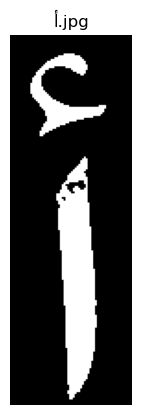

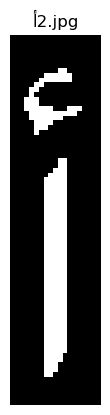

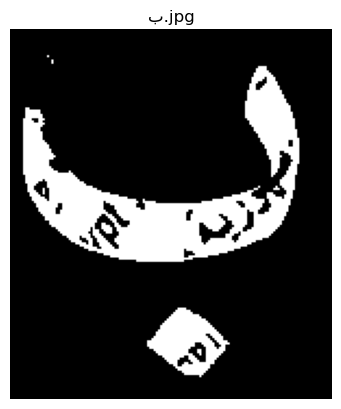

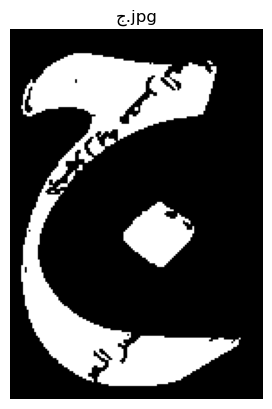

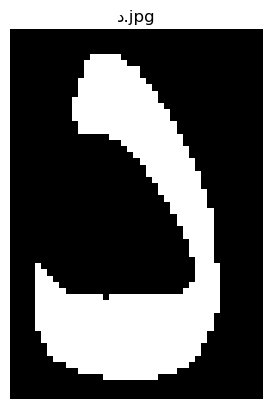

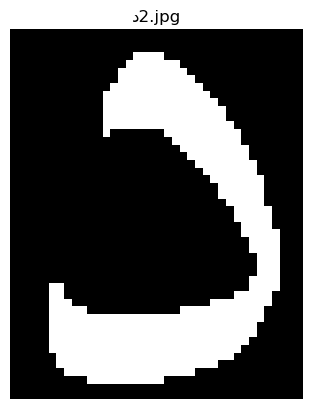

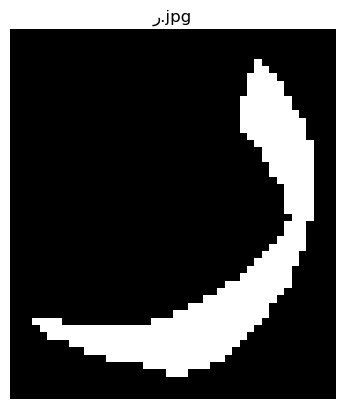

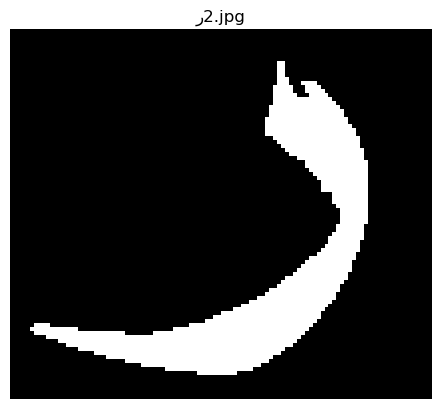

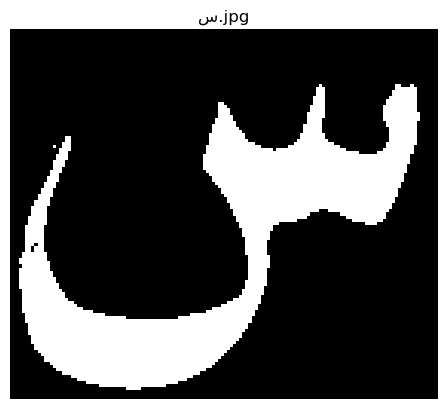

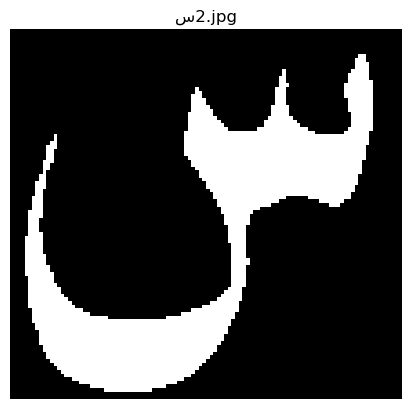

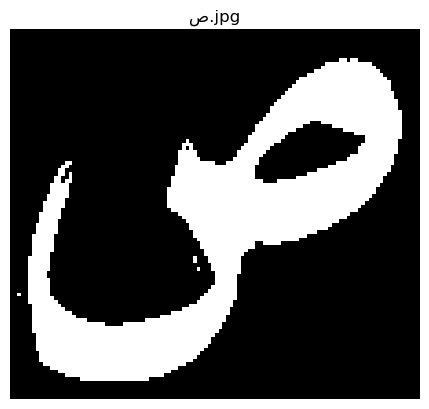

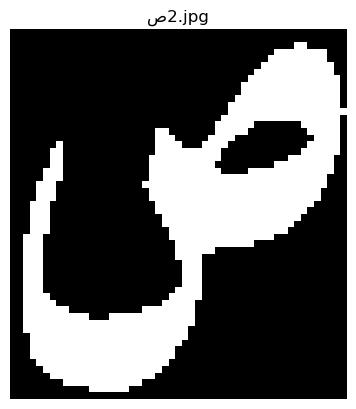

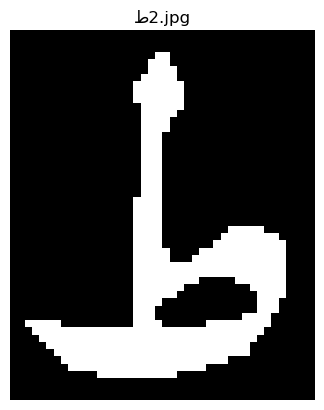

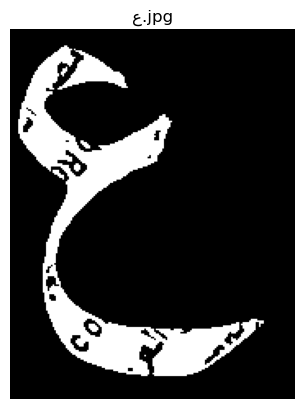

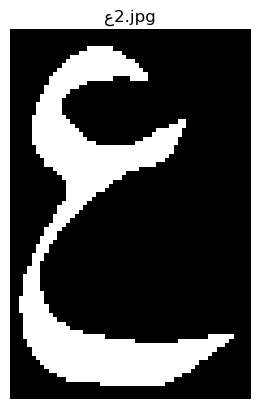

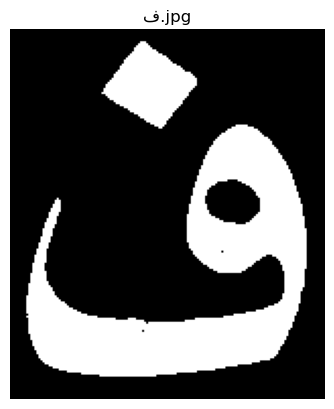

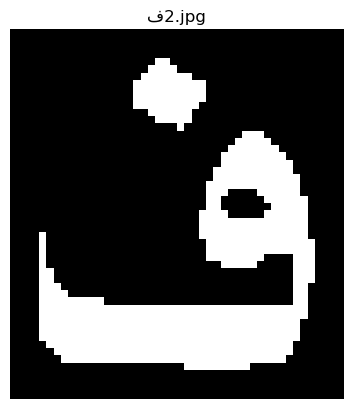

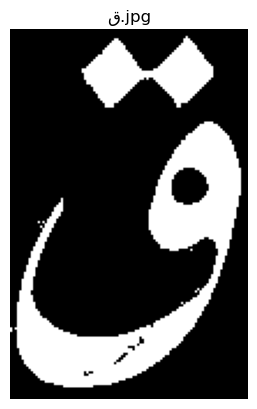

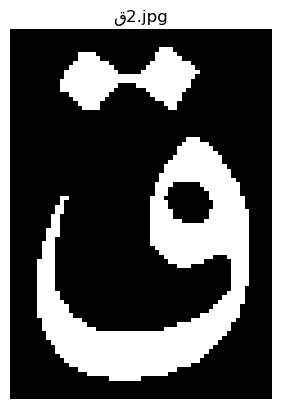

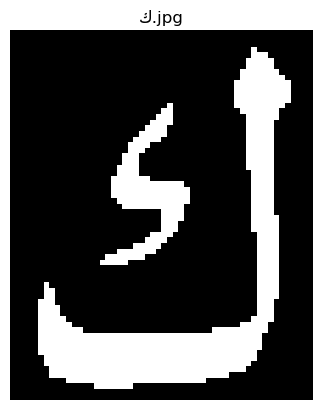

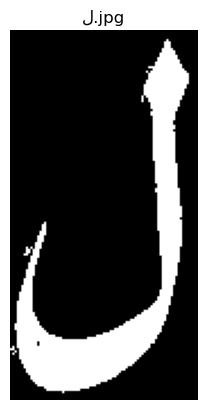

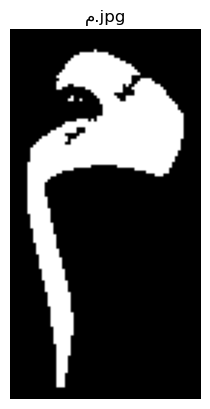

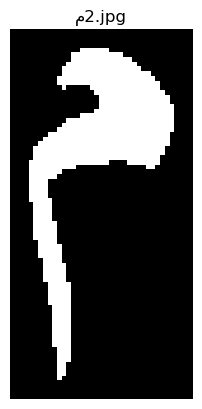

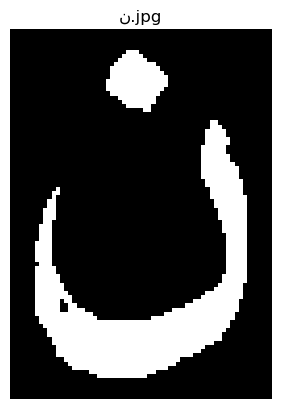

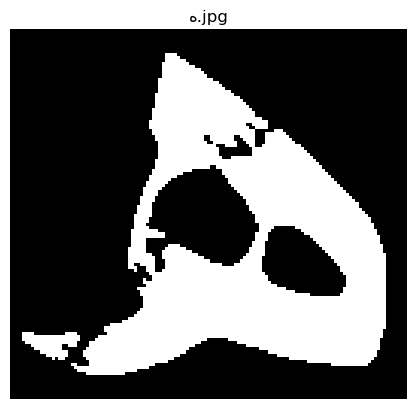

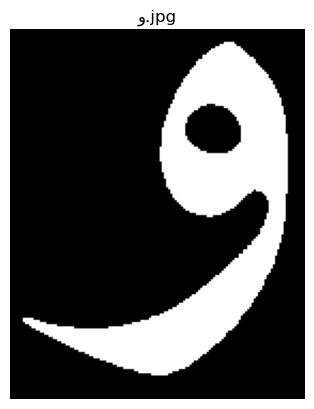

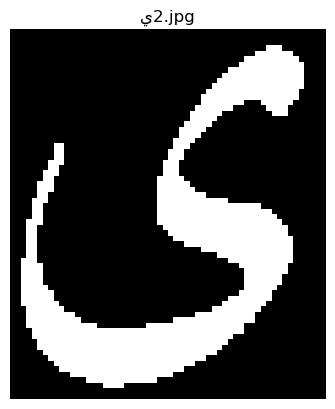

In [21]:
# Path to the folder containing the images
folder_path = "./Reference_Letters"

# Get a list of all files in the folder
image_files = [file for file in os.listdir(folder_path) if file.endswith(('.jpg'))]

# Loop through each file, read it, and display it
for image_file in image_files:
    # Construct the full file path
    image_path = os.path.join(folder_path, image_file)
    
    # Read the image
    img = io.imread(image_path)
    img_g = rgb2gray(img)
    img_it = iterativeThreshold(img_g)
    
    # Display the image
    plt.imshow(img_it)
    plt.title(image_file)
    plt.axis('off')
    plt.show()

In [119]:
def distance_from_center(shape):
    """
    Calculate a matrix where each point is the distance from the center.

    Args:
        shape (tuple): The shape of the matrix (height, width).

    Returns:
        numpy.ndarray: Matrix of distances from the center.
    """
    height, width = shape
    center_y, center_x = height // 2, width // 2

    # Create coordinate grids
    y, x = np.ogrid[:height, :width]

    # Calculate Euclidean distance from the center
    distance_matrix = np.sqrt((x - center_x)**2 + (y - center_y)**2)

    # Normalize distances to the range [0, 1]
    max_distance = np.sqrt(center_x**2 + center_y**2)  # Farthest corner
    normalized_distance = distance_matrix / max_distance

    return normalized_distance


def weighted_erosion(image, kernel_size=3, iterations=1, intensity=1):
    """
    Apply erosion with stronger effects at edges and weaker effects toward the center.

    Args:
        image (numpy.ndarray): Input binary image (object = white, background = black).
        distance_matrix (numpy.ndarray): distance at each point from center 
        kernel_size (int): Size of the erosion kernel.
        iterations (int): Number of times to apply erosion.
        intensity (float): Controls how strongly edges are eroded compared to the center.

    Returns:
        numpy.ndarray: Image after weighted erosion.
    """
    distance_matrix = rectangular_distance(np.shape(image))
    
    # Step 1: Compute erosion strength map (higher `intensity` makes edges more pronounced)
    erosion_strength = (distance_matrix) ** intensity  # Invert and scale edges
    
    # Step 2: Prepare erosion kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    # Step 3: Apply erosion iteratively
    eroded_image = image.copy()
    for _ in range(iterations):
        # Perform erosion
        eroded_temp = cv2.erode(eroded_image, kernel, iterations=1)
        
        # Blend erosion result with the strength map
        eroded_image = (erosion_strength * eroded_temp + (1 - erosion_strength) * eroded_image)
    
    # Normalize result to binary
    eroded_image = (eroded_image > 0.5).astype(np.uint8) * 255
    
    return eroded_image

def weighted_dilation(image, kernel_size=3, iterations=1, intensity=1):
    """
    Apply dilation with stronger effects at edges and weaker effects toward the center.

    Args:
        image (numpy.ndarray): Input binary image (object = white, background = black).
        distance_matrix (numpy.ndarray): Distance at each point from the center.
        kernel_size (int): Size of the dilation kernel.
        iterations (int): Number of times to apply dilation.
        intensity (float): Controls how strongly edges are dilated compared to the center.

    Returns:
        numpy.ndarray: Image after weighted dilation.
    """
    
    # Step 1: Compute dilation strength map (higher `intensity` makes edges more pronounced)
    dilation_strength = (1 - rectangular_distance(np.shape(image),0.001)) ** intensity  # Use distance for strength
    
    # Step 2: Prepare dilation kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    # Step 3: Apply dilation iteratively
    dilated_image = image.copy()
    for _ in range(iterations):
        # Perform dilation
        dilated_temp = cv2.dilate(dilated_image, kernel, iterations=1)
        
        # Blend dilation result with the strength map
        dilated_image = (dilation_strength * dilated_temp + (1 - dilation_strength) * dilated_image)
    
    # Normalize result to binary
    dilated_image = (dilated_image > 0.5).astype(np.uint8) * 255
    
    return dilated_image


'''
eroded_image = weighted_erosion(dilated_image.astype('uint8'), distance_matrix, kernel_size=3, iterations=14, intensity=1.9)
dilated_image = weighted_dilation(eroded_image.astype('uint8'), distance_matrix, kernel_size=2, iterations=1, intensity=1)
show_images([eroded_image,dilated_image],["eroded","dilated"])

eroded_image = weighted_erosion(dilated_image.astype('uint8'), distance_matrix, kernel_size=3, iterations=18, intensity=1.9)
dilated_image = weighted_dilation(eroded_image.astype('uint8'), distance_matrix, kernel_size=2, iterations=1, intensity=1)
show_images([eroded_image,dilated_image],["eroded","dilated"])

eroded_image = weighted_erosion(dilated_image.astype('uint8'), distance_matrix, kernel_size=3, iterations=18, intensity=2)
dilated_image = weighted_dilation(eroded_image.astype('uint8'), distance_matrix, kernel_size=2, iterations=1, intensity=1)
show_images([eroded_image,dilated_image],["eroded","dilated"])
'''

'\neroded_image = weighted_erosion(dilated_image.astype(\'uint8\'), distance_matrix, kernel_size=3, iterations=14, intensity=1.9)\ndilated_image = weighted_dilation(eroded_image.astype(\'uint8\'), distance_matrix, kernel_size=2, iterations=1, intensity=1)\nshow_images([eroded_image,dilated_image],["eroded","dilated"])\n\neroded_image = weighted_erosion(dilated_image.astype(\'uint8\'), distance_matrix, kernel_size=3, iterations=18, intensity=1.9)\ndilated_image = weighted_dilation(eroded_image.astype(\'uint8\'), distance_matrix, kernel_size=2, iterations=1, intensity=1)\nshow_images([eroded_image,dilated_image],["eroded","dilated"])\n\neroded_image = weighted_erosion(dilated_image.astype(\'uint8\'), distance_matrix, kernel_size=3, iterations=18, intensity=2)\ndilated_image = weighted_dilation(eroded_image.astype(\'uint8\'), distance_matrix, kernel_size=2, iterations=1, intensity=1)\nshow_images([eroded_image,dilated_image],["eroded","dilated"])\n'

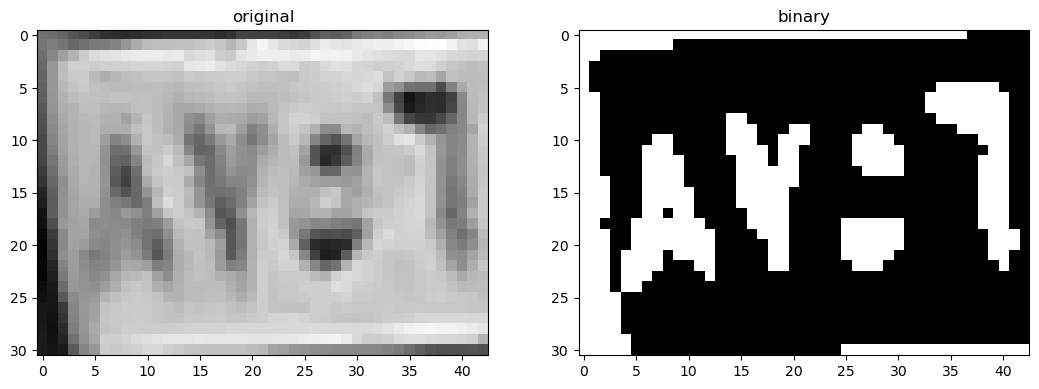

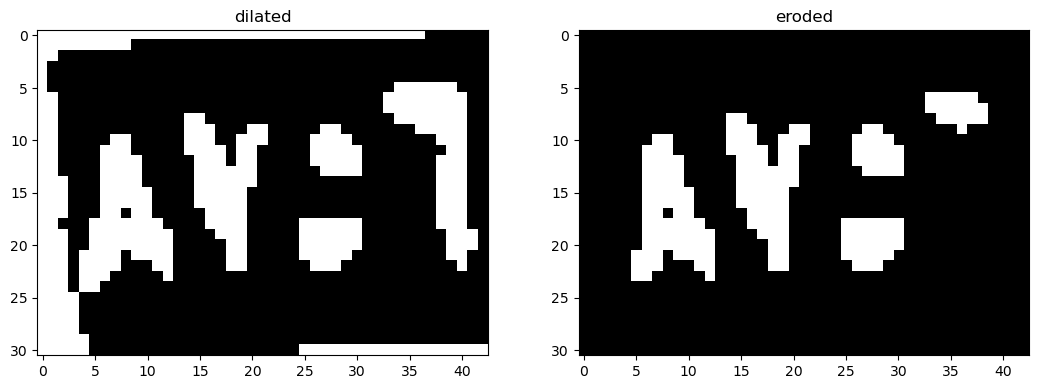

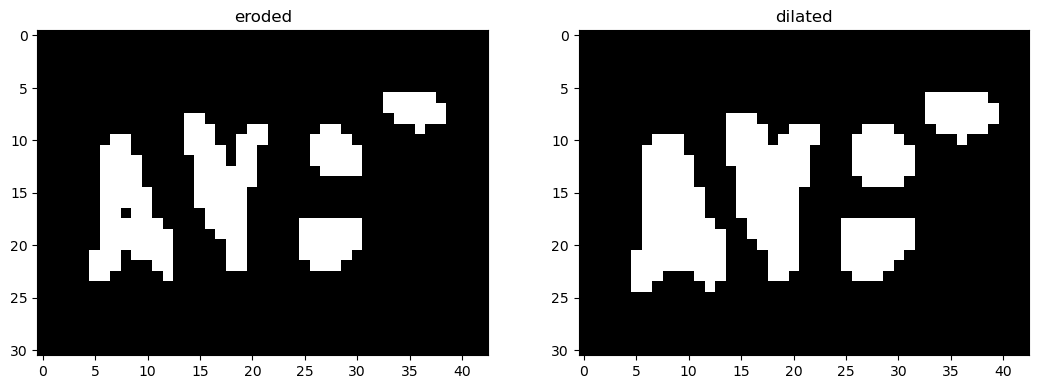

IndexError: list index out of range

In [147]:
img = rgba2rgb(io.imread("./Tests/أعو٨٧٥٦.png"))
img_g = rgb2gray(img)
# Crop 40% from the top
height, width = img_g.shape
cropped_img = img_g[int(height * 0.4):, :]

# Split the cropped image into two parts vertically
image1 = cropped_img[:, :int(width * 0.5)]  # Left half
image2 = cropped_img[:, int(width * 0.5):]  # Right half

image1_it = iterativeThreshold(image1)
image2_it = iterativeThreshold(image2)

image = image1
image_it = image1_it

#show_images([image,extract_half2(image_it,image)],["1","2"])
# Apply weighted erosion
def extract_half2(image_it,image):
    show_images([image,image_it],["original","binary"])

    dilated_image = weighted_dilation(image_it.astype('uint8'), kernel_size=2, iterations=10, intensity=1)
    eroded_image = weighted_erosion(dilated_image.astype('uint8'), kernel_size=3, iterations=10, intensity=1)

    show_images([dilated_image,eroded_image],["dilated","eroded"])

    dilated_image = weighted_dilation(eroded_image.astype('uint8'), kernel_size=2, iterations=1, intensity=1)

    show_images([eroded_image,dilated_image],["eroded","dilated"])
    
    #eroded_image = weighted_erosion(dilated_image.astype('uint8'), distance_matrix, kernel_size=3, iterations=6, intensity=3)
    #dilated_image = weighted_dilation(eroded_image.astype('uint8'), distance_matrix, kernel_size=2, iterations=1, intensity=10)
    #show_images([eroded_image,dilated_image],["eroded","dilated"])
    
    #eroded_image = weighted_erosion(dilated_image.astype('uint8'), distance_matrix, kernel_size=3, iterations=9, intensity=3)
    #dilated_image = weighted_dilation(eroded_image.astype('uint8'), distance_matrix, kernel_size=2, iterations=12, intensity=10)
    #show_images([eroded_image,dilated_image],["eroded","dilated"])
    
    inverse = 255 - dilated_image
    #bounded = extract_half(inverse,image)
    
    contours = find_contours(inverse, 0.)
    bounding_boxes = []
    for contour in contours:
        Ymin = np.min(contour[:,0])
        Ymax = np.max(contour[:,0])
        Xmin = np.min(contour[:,1])
        Xmax = np.max(contour[:,1])
        aspect_ratio = (Xmax-Xmin)/(Ymax-Ymin)
        if 0 <= aspect_ratio <= 5 and (Xmax-Xmin) > 16:
            print(Xmin, Xmax, Ymin, Ymax)
            bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
    
    Xmin, Xmax, Ymin, Ymax = bounding_boxes[0]
    bounded2 = image[int(Ymin):int(Ymax), int(Xmin)-1:int(Xmax)+1]
    show_images([image,inverse,bounded2],["original","inverse","bounded2"])
    return bounded2

extract_half2(image_it,image)

1.0


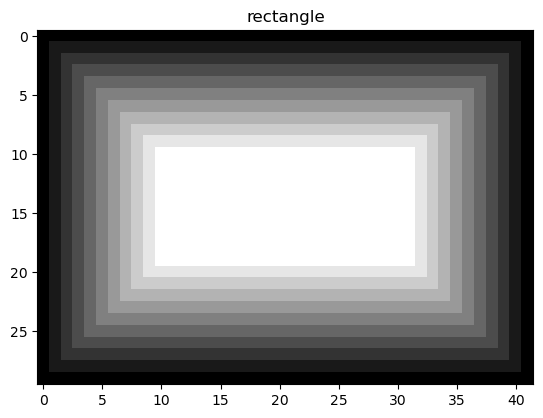

In [227]:
def rectangular_distance(shape, step=0.1):
    """
    Calculate a rectangular distance matrix where distance is based on layers moving inward.
    
    Args:
        shape (tuple): The shape of the matrix (height, width).
        step (float): The decrement for each inward layer of distance.
        
    Returns:
        numpy.ndarray: Matrix of distances based on rectangular layers.
    """
    height, width = shape
    distance_matrix = np.zeros((height, width), dtype=float)
    
    # Calculate the number of layers
    num_layers = min(height, width) // 2
    
    # Assign distances for each layer
    for layer in range(num_layers):
        distance = 1 - layer * step
        # Stop assigning if distance is less than zero
        if distance < 0:
            break
        # Assign distance to the current layer
        distance_matrix[layer:height-layer, layer:width-layer] = distance 
    
    return distance_matrix
rectangle = rectangular_distance(([30,42]),0.1)
rectangle = rectangle.max() - rectangle
print(rectangle.max())
show_images([rectangle],["rectangle"])

31 43
....................
[31 28 18  8  8  9 15 15 12 11  8  6  6  1  5 10 11 10 11 14  7  3  1  1
  1  6 10 12 12 10  8  2  2  4  6  6  7  6 14 18 18  3  1]
....................
[37  9  2  1  1  7 10 10 11 14 17 18 19 19 16 16 16 14 22 23 22 20 15  7
  5  4  4  4  4  5 23]
2 -1 1 -1


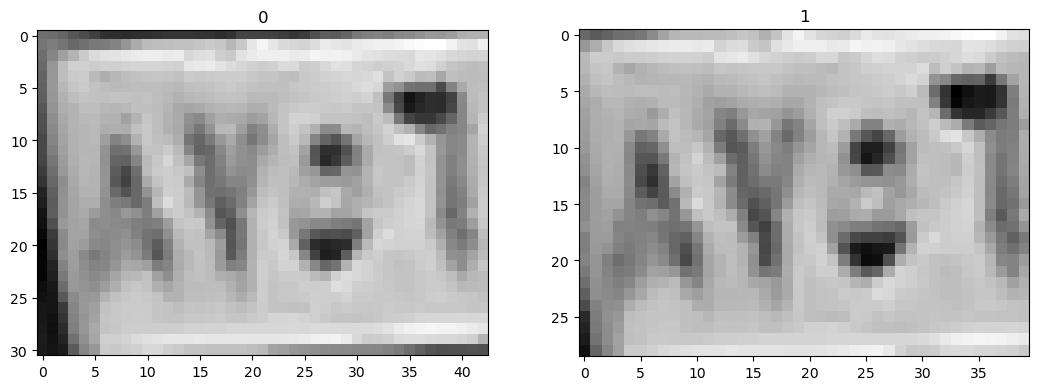

29 40
....................
[10.59485412 12.57132471 13.00731843 12.86614196 12.67185098 12.24047843
 12.41697882 13.00129255 13.71998118 13.71605961 14.17913294 14.52815255
 14.16290706 13.49624039 13.06805843 12.78570549 12.39234392 12.69822627
 13.61727294 14.80158667 15.15202    15.32849059 14.91324353 14.10147882
 13.11789412 12.49828627 12.58761294 13.26212275 13.9966451  14.94566471
 15.5162749  15.04960824 14.63987608 14.2751702  14.43331451 13.93527529
 12.51566745 11.91566745 12.41204706 13.97283137]
....................
[21.30233804 23.42893647 22.2132502  20.76020314 19.24255608 17.73794431
 17.38892471 17.46710118 17.75729725 17.21838353 16.39877569 16.39209882
 17.0077851  17.14668    17.40550353 17.62482039 17.73854588 16.6952
 16.08343529 15.93119608 16.39786275 17.89636784 19.30421098 19.72267765
 19.99326588 20.10934275 20.61130353 21.88807529 22.24101647]


In [191]:
img = rgba2rgb(io.imread("./Tests/أعو٨٧٥٦.png"))
img_g = rgb2gray(img)
# Crop 40% from the top
height, width = img_g.shape
cropped_img = img_g[int(height * 0.4):, :]

# Split the cropped image into two parts vertically
image1 = cropped_img[:, :int(width * 0.5)]  # Left half
image2 = cropped_img[:, int(width * 0.5):]  # Right half

image1_it = iterativeThreshold(image1)
image2_it = iterativeThreshold(image2)

image = image1
image_it = image1_it
height, width = image.shape
horizontal_projection = np.sum(image_it, axis=0)
vecrtical_projection = np.sum(image_it, axis=1)

print(height, width)
print("....................")
print(horizontal_projection)
print("....................")
print(vecrtical_projection)
xmin = 0
xmax = 0
ymin = 0
ymax = 0
for x in range(4):
    if horizontal_projection[x] >int( 0.8 * height):
        xmin = (x+1)
    if horizontal_projection[-x] >int( 0.8 * height):
        xmax = (x-1)

for x in range(4):
    if vecrtical_projection[x] >int( 0.8 * width):
       ymin = (x+1)
    if vecrtical_projection[-x] >int( 0.8 * width):
        ymax = (x-1)
    

print(xmin,xmax,ymin,ymax)
image_1 = image[ymin:ymax,xmin:xmax]
show_images([image,image_1],["0","1"])
height, width = image_1.shape
horizontal_projection = np.sum(image_1, axis=0)
vecrtical_projection = np.sum(image_1, axis=1)

print(height, width)
print("....................")
print(horizontal_projection)
print("....................")
print(vecrtical_projection)

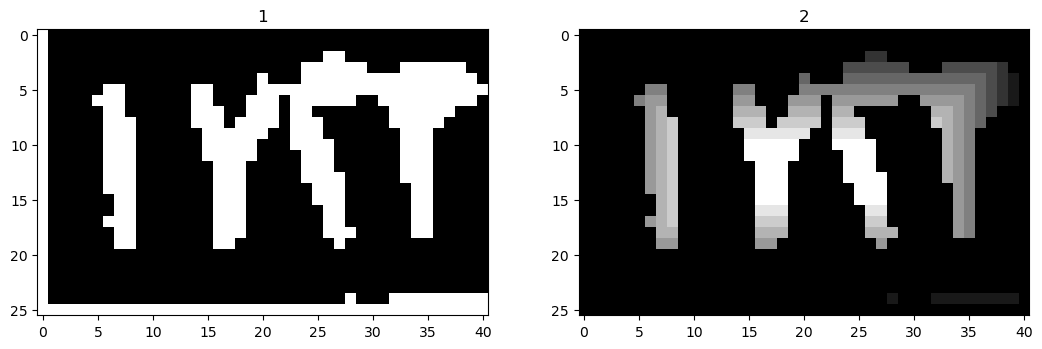

13.100000000000001
[(3, 20)]
(3, 20)


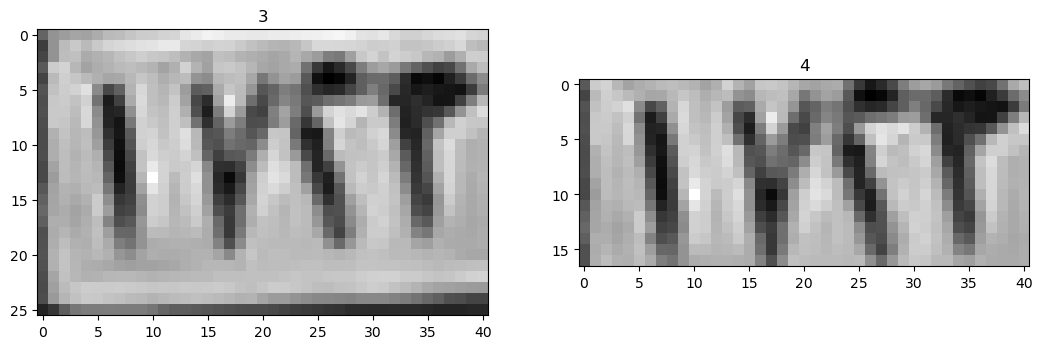

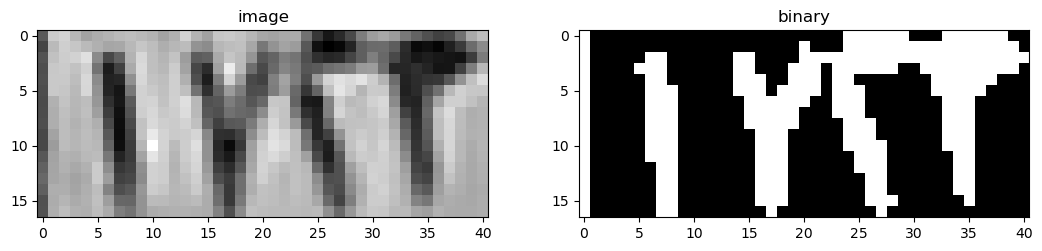

0 1
5 9
14 40


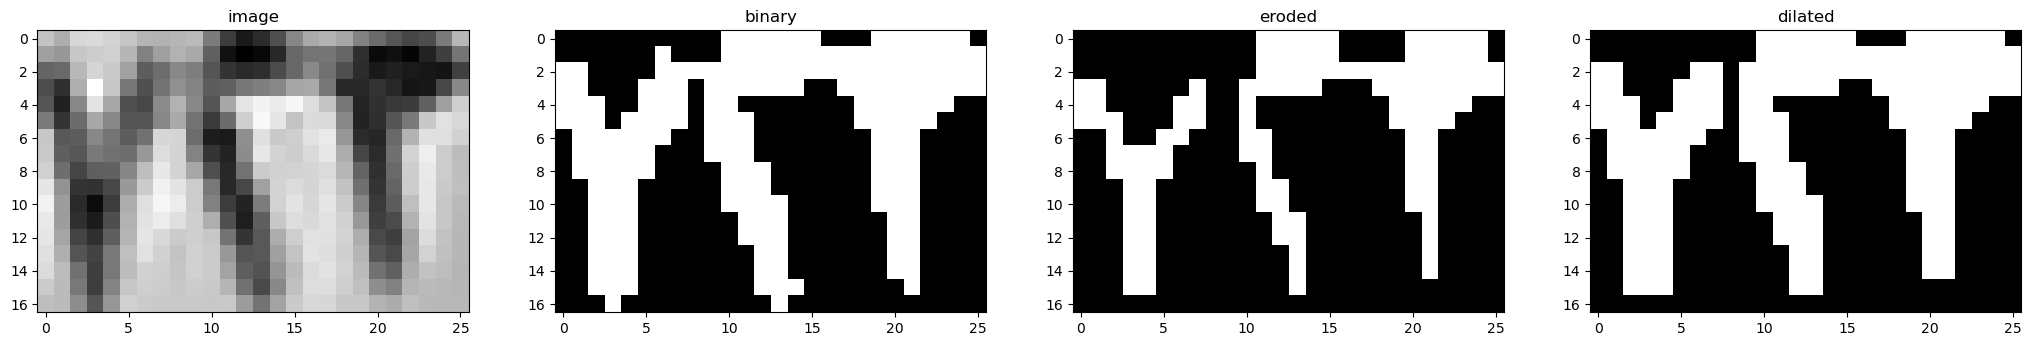

[(14, 22, array([[False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False,  True, False],
       [ True,  True, False, False, False, False,  True,  True],
       [ True,  True, False, False, False,  True,  True,  True],
       [ True,  True,  True, False, False,  True,  True,  True],
       [ True,  True,  True, False,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True, False, False],
       [False,  True,  True,  True,  True,  True, False, False],
       [False, False,  True,  True,  True, False, False, False],
       [False, False,  True,  True,  True, False, False, False],
       [False, False,  True,  True,  True, False, False, False],
       [False, False,  True,  True,  True, False, False, False],
       [False, False,  True,  True,  True, False, False, False],
       [False, False,  True,  True,  True, False, False, False],
       [False, 

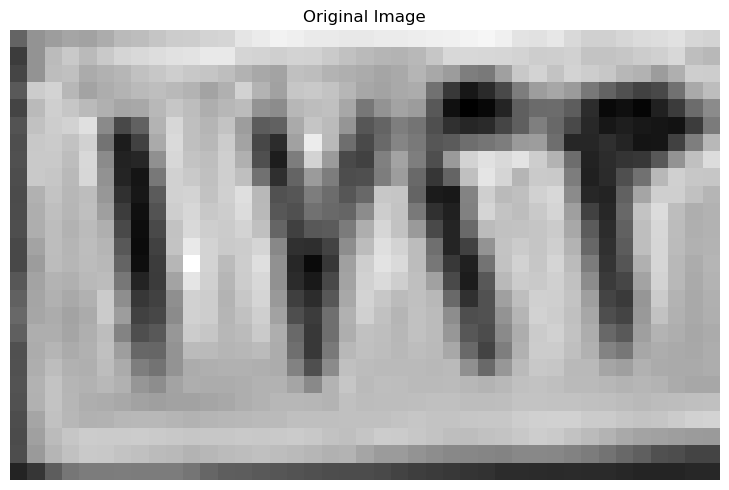

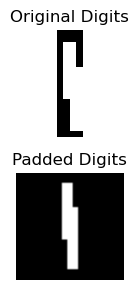

In [327]:
def sub_horizontal_segmentation(image, min_width=1, max_width=20, min_height=4, offset = 0):
    """
    Segment digits horizontally
    
    Args:
        binary_image (numpy.ndarray): Binary image of the license plate
        min_width (int): Minimum width of a valid digit region
        max_width (int): Maximum width of a valid digit region
        min_height (int): Minimum height of a valid digit region
    
    Returns:
        list: List of segmented digit images
    """
    binary_image = iterativeThreshold(image)
    eroded = binary_erosion(binary_image,np.ones([2,2]))
    dilated = binary_dilation(eroded,np.ones([2,2]))

    show_images([image,binary_image,eroded,dilated],["image","binary","eroded","dilated"])

    binary_image = dilated
    
    # Find horizontal projection
    horizontal_projection = np.sum(binary_image, axis=0)
    
    # Find potential digit regions
    digit_regions = []
    in_digit = False
    start = 0
    
    for x in range(len(horizontal_projection)):
        # Check if we're in a potential digit region
        if not in_digit and horizontal_projection[x] > 0:
            start = x
            in_digit = True
        
        # Check if we've exited a digit region
        elif in_digit and (horizontal_projection[x] == 0 or x == len(horizontal_projection)-1):
            end = x

            #filtering
            if (end - start >= min_width and end - start <= max_width and np.sum(binary_image[:,start:end]) > min_height * (end - start) and ((end+start)/2 > len(horizontal_projection)/20 and (end+start)/2 < len(horizontal_projection) - (len(horizontal_projection)/20))):
        
                # Extract potential digit
                digit_region = image[:, start:end]
                digit_region = iterativeThreshold(digit_region)
                
                digit_regions.append((start + offset, end + offset, digit_region))
            
            in_digit = False
    
    return digit_regions


def horizontal_segmentation_1(image, min_width=1, max_width=20, min_height=4):
    """
    Segment digits horizontally
    
    Args:
        binary_image (numpy.ndarray): Binary image of the license plate
        min_width (int): Minimum width of a valid digit region
        max_width (int): Maximum width of a valid digit region
        min_height (int): Minimum height of a valid digit region
    
    Returns:
        list: List of segmented digit images
    """
    binary_image = iterativeThreshold(image)

    show_images([image,binary_image],["image","binary"])
    
    # Find horizontal projection
    horizontal_projection = np.sum(binary_image, axis=0)
    
    # Find potential digit regions
    digit_regions = []
    in_digit = False
    start = 0
    
    for x in range(len(horizontal_projection)):
        # Check if we're in a potential digit region
        if not in_digit and horizontal_projection[x] > 0:
            start = x
            in_digit = True
        
        # Check if we've exited a digit region
        elif in_digit and (horizontal_projection[x] == 0 or x == len(horizontal_projection)-1):
            end = x
            print(start,end)

            #filtering
            
            if (end - start > max_width):
                sub_regions = sub_horizontal_segmentation(image[:,start:end], min_width, max_width, min_height, start)
                print(sub_regions)
                if len(sub_regions) > 1:
                    digit_regions.append(sub_regions)
            if (end - start >= min_width and end - start <= max_width and np.sum(binary_image[:,start:end]) > min_height * (end - start) and ((end+start)/2 > len(horizontal_projection)/20 and (end+start)/2 < len(horizontal_projection) - (len(horizontal_projection)/20))):
        
                # Extract potential digit
                digit_region = image[:, start:end]
                digit_region = iterativeThreshold(digit_region)
                
                digit_regions.append((start, end, digit_region))
            
            in_digit = False
    
    return digit_regions

def refine_segmentation_1(digit_regions, max_digits=4, min_separation=1, max_width = 14):
    """
    Refine segmentation by merging or filtering regions
    
    Args:
        digit_regions (list): List of detected digit regions
        max_digits (int): Maximum number of expected digits
        min_separation (int): Minimum separation between digits
    
    Returns:
        list: Refined list of digit regions
    """
    # Sort regions from left to right
    sorted_regions = sorted(digit_regions, key=lambda x: x[0])
    
    # Merge closely connected regions
    refined_regions = []
    i = 0
    while i < len(sorted_regions):
        current = sorted_regions[i]
        
        # Look ahead to see if next region is close
        if i + 1 < len(sorted_regions):
            next_region = sorted_regions[i + 1]
            
            # If regions are close, merge them
            if next_region[0] - current[1] < min_separation and next_region[1] - current[0] <= max_width:
                # Merge the two regions
                merged_region = (
                    current[0], 
                    next_region[1], 
                    np.hstack((current[2], next_region[2]))
                )
                refined_regions.append(merged_region)
                i += 2
                continue
        
        refined_regions.append(current)
        i += 1
    refined_regions = sorted(refined_regions, key=lambda x: (x[0] - x[1]))
    refined_regions = refined_regions[:max_digits]
    refined_regions = sorted(refined_regions, key=lambda x: x[0])
    # Limit to max expected digits
    return refined_regions[:max_digits]

def vertical_segmentation(image):
    """
    Segment digits horizontally
    
    Args:
        binary_image (numpy.ndarray): Binary image of the license plate
        min_width (int): Minimum width of a valid digit region
        max_width (int): Maximum width of a valid digit region
        min_height (int): Minimum height of a valid digit region
    
    Returns:
        list: List of segmented digit images
    """

    height, width = image.shape
    
    # Find horizontal projection
    vertical_projection = np.sum(image, axis=1)

    vert_max = max(vertical_projection) 
    print(vert_max)
    
    # Find potential digit regions
    regions = []
    in_digit = False
    prev = -1
    start = 0
    
    for x in range(len(vertical_projection)):

        if not in_digit and (vertical_projection[x] > (0.1 * vert_max)):
            in_digit = True
            start = x
            
        if in_digit and (vertical_projection[x] < (0.4 * prev)):
            end = x
            in_digit = False
            regions.append((start, end))

        prev = vertical_projection[x]

    refined_regions = sorted(regions, key=lambda x: x[0])
    if len(refined_regions) > 1:
        if refined_regions[0][1] >= int(0.25 * height) and refined_regions[0][1] <= int(height - (0.25 * height)):
            if refined_regions[1][0] >= int(0.25 * height) and refined_regions[1][0] <= int(height - (0.25 * height)):
                return [(refined_regions[0][0], refined_regions[1][1])]
    return regions


img = rgba2rgb(io.imread("./Tests/جن١٧٢٣.png"))
img_g = rgb2gray(img)
# Crop 40% from the top
height, width = img_g.shape
cropped_img = img_g[int(height * 0.4):, :]

# Split the cropped image into two parts vertically
image1 = cropped_img[:, :int(width * 0.5)]  # Left half
image2 = cropped_img[:, int(width * 0.5):]  # Right half

image1_it = iterativeThreshold(image1)
image2_it = iterativeThreshold(image2)

image_n = image1
image_it = image1_it

rectangle = 1 - rectangular_distance(np.shape(image_it),0.1)
image_it_new = image_it * rectangle
show_images([image_it,image_it_new],["1","2"])
vertical_regions = vertical_segmentation(image_it_new)
print(vertical_regions)
choosen_region = (sorted(vertical_regions, key=lambda x: x[0]-x[1]))[0]
print(choosen_region)
image_new = image_n[int(choosen_region[0]):int(choosen_region[1]),:]
show_images([image_n,image_new],["3","4"])

digit_regions = horizontal_segmentation_1(image_new,2,14,3)
    
# Refine segmentation
refined_regions = refine_segmentation_1(digit_regions,4,4,14)

# Pad and center digits
padded_digits = [
    resize(region[2]) 
    for region in refined_regions
]

# Visualize segmentation
visualize_segmentation(image_n, refined_regions,padded_digits)
